# INFO-F-422 -  Statistical Foundations of Machine Learning 

### Student 1 - [johan.gjini@ulb.ac.be](mailto:student1@ulb.ac.be) - Student ID 000480821
### Student 2 - [lucas.weinberg@vub.ac.be](mailto:student2@ulb.ac.be) - Student ID 000400966
### Student 3 - [lionel.delchambre@ulb.ac.be](mailto:student3@ulb.ac.be) - Student ID 000336430

### Video presentation: www.youtube.com/abcd1234

## Project Title


# Introduction


# 1. Data preprocessing


### 1.1 Loading the data

In [4]:
install.packages(c('reshape2','future.apply','pROC','caret','ggplot2','dplyr','fastDummies','matlib','nnet','xgboost','randomForest'))


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [108]:
library(fastDummies)
library(reshape2)
library(dplyr)
library(ggplot2)
library(tidyr)
library(future.apply)
library(caret)
library(pROC)
library(matlib)
library(nnet)
library(xgboost)
library(randomForest)


test_set=read.csv("test_set_features.csv",header=TRUE)                
training_label=read.csv("training_set_labels.csv",header=TRUE)
training_feature=read.csv("training_set_features.csv",header=TRUE)  

submission=read.csv("submission_format.csv",header = TRUE)

feature_df<-dplyr::tibble(training_feature)
labels_df<-dplyr::tibble(training_label)
training_df<-dplyr::inner_join(feature_df,labels_df)

Joining, by = "respondent_id"


Checking the data

In [109]:
dim(training_df)
#summary(training_df)

[1] 26707    38

Our training set is composed of 26707 rows and 38 variables (37 without id).

Lets check if our class are balanced :

h1n1_vaccine,n
<int>,<int>
0,21033
1,5674


seasonal_vaccine,n
<int>,<int>
0,14272
1,12435


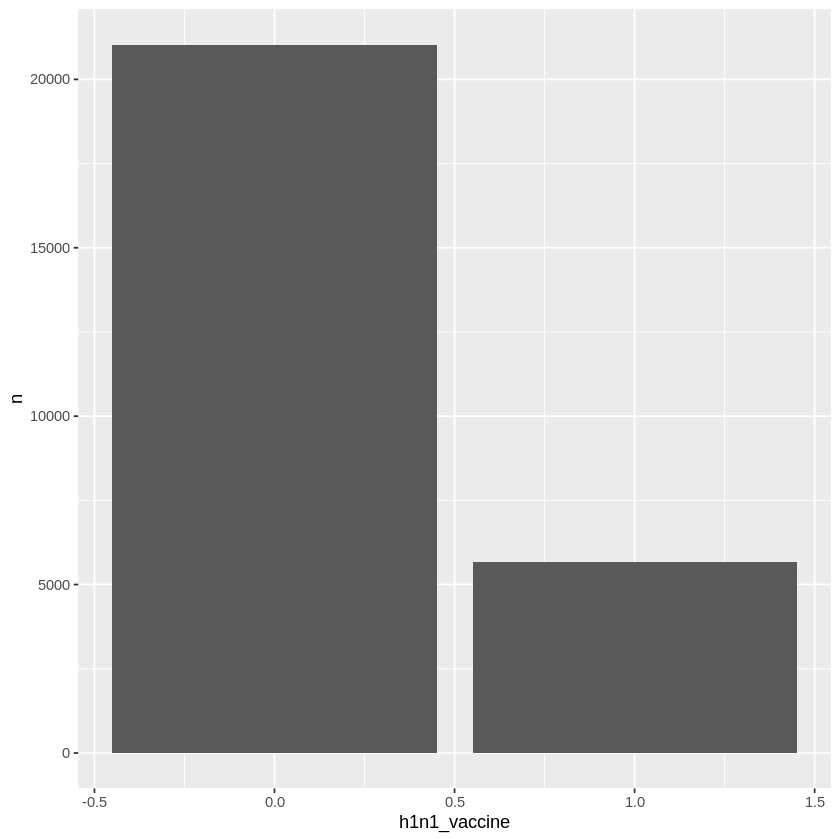

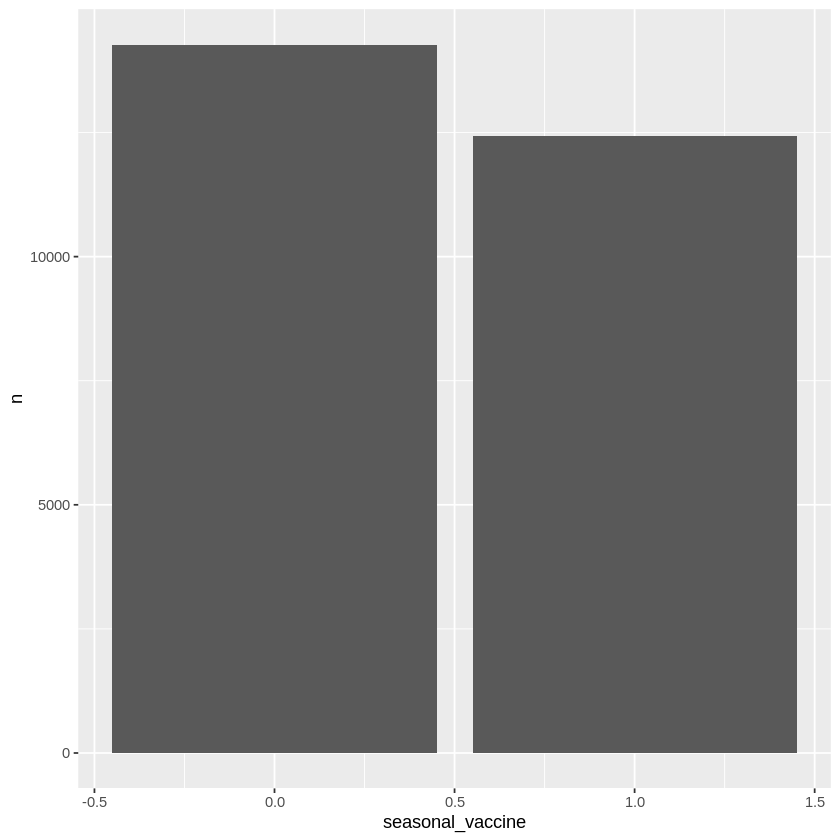

In [110]:
h1n1_label=labels_df%>% count(h1n1_vaccine, sort = TRUE)
seasonal_label=labels_df%>% count(seasonal_vaccine, sort = TRUE)
h1n1_label
seasonal_label
p<-ggplot(data=h1n1_label, aes(x=h1n1_vaccine, y=n)) +
  geom_bar(stat="identity")
p

p<-ggplot(data=seasonal_label, aes(x=seasonal_vaccine, y=n)) +
  geom_bar(stat="identity")
p

We see that around 80% of the person are not vaccined against h1n1 when around 55% are not vaccinated against the seasonal flu. We see then see that for h1n1 a precision under 80% will be a failure for a classification algorithm when a precision above 60% will already be a progress with regards to seasonal flu. That being said lets start our feature engineering.

## Feature engineering and missing value imputaion

In [111]:
category_list=c()
not_category=c()
for (feature in colnames(training_df)){
  if (typeof(training_df[feature][[1]])=="character"){
    category_list<-c(category_list,feature)
  }
  else{
    not_category<-c(not_category, feature)  
  }    
}

not_category <- not_category[not_category!="respondent_id"]
all_features=c(category_list, not_category)

dummy_df <- training_df

#all_features

In [112]:
#replace empty strings by NA

for (col in category_list){
    dummy_df[,col][dummy_df[,col] == ""] <- NA
}

Mode <- function(x){
  #convert NA to most common value
  distinct_value <- unique(x[!is.na(x)])

  distinct_value[which.max(tabulate(match(x, distinct_value)))]
}

In [113]:
#convert categorical to numerical
for (c in category_list){
    
    dummy_df[[c]] <- unclass(factor(dummy_df[[c]]))
}

for (col in category_list){
    dummy_df[,col][is.na(dummy_df[,col])] <- Mode(dummy_df[,col])
}



head(dummy_df)

respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,⋯,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,1,0,0,0,0,0,0,1,1,⋯,1,2,9,3,0,0,13,20,0,0
1,3,2,0,1,0,1,0,1,1,⋯,2,1,2,1,0,0,13,20,0,1
2,1,1,0,1,0,0,0,0,0,⋯,1,1,10,1,2,0,15,22,0,0
3,1,1,0,1,0,1,1,0,0,⋯,2,2,6,2,0,0,13,20,0,1
4,2,1,0,1,0,1,1,0,1,⋯,1,1,10,1,1,0,19,6,0,0
5,3,1,0,1,0,1,0,0,1,⋯,1,1,1,2,2,3,16,19,0,0


In [114]:
df <- sapply(dummy_df[,all_features], as.numeric)

#Correlation matrix with Pearson method
cormat <- round(cor(df, method='pearson', use='complete.obs'),2)


#Put Correaltion matrix in a form suitable to build heatmap
melted_cormat <- melt(cormat)


summary(df)

   age_group       education          race           sex        income_poverty 
 Min.   :1.000   Min.   :1.000   Min.   :1.00   Min.   :1.000   Min.   :1.000  
 1st Qu.:2.000   1st Qu.:2.000   1st Qu.:4.00   1st Qu.:1.000   1st Qu.:1.000  
 Median :3.000   Median :3.000   Median :4.00   Median :1.000   Median :2.000  
 Mean   :3.186   Mean   :2.764   Mean   :3.57   Mean   :1.406   Mean   :1.788  
 3rd Qu.:5.000   3rd Qu.:4.000   3rd Qu.:4.00   3rd Qu.:2.000   3rd Qu.:3.000  
 Max.   :5.000   Max.   :4.000   Max.   :4.00   Max.   :2.000   Max.   :3.000  
                                                                               
 marital_status   rent_or_own    employment_status hhs_geo_region 
 Min.   :1.000   Min.   :1.000   Min.   :1.000     Min.   : 1.00  
 1st Qu.:1.000   1st Qu.:1.000   1st Qu.:1.000     1st Qu.: 4.00  
 Median :1.000   Median :1.000   Median :1.000     Median : 6.00  
 Mean   :1.492   Mean   :1.222   Mean   :1.547     Mean   : 5.83  
 3rd Qu.:2.000   3rd Qu.:

In [115]:
#normalizing the data
normalized_df <- df

replace_na_with_mean_value<-function(vec) {
    mean_vec<-mean(vec,na.rm=T)
    vec[is.na(vec)]<-mean_vec
    vec
}

for (col in not_category){
  normalized_df[ , col][is.na(normalized_df[ , col])] <- mean(normalized_df[ , col], na.rm = TRUE)
}


for (col in all_features){
  norm_factor=max(normalized_df[,col])
  normalized_df[,col]<-round((normalized_df[,col])/norm_factor, digits=3)
  
}

## Feature selection
We chose to use the mrMR feature selection technique for two of our three model. An other personnalized feature selection has been used for the last one which will be detailed later in this work.
Here only the ordering with regard to mrMR method is indicated. Wrapper method are then applied to eventually chose for a subsample of this features with repect to this order.

In [116]:
training_set <- read.csv("normalized_data.csv")


#mrmr filter

MRMR <- function(target_variable) {

  training_set <- read.csv("normalized_data.csv")
  
  n <- ncol(training_set)
  n_var=n-3
    
  input_variables <- training_set[,1:n_var]
  
  output_variable <- training_set[,target_variable]
  
  correlation<-abs(cor(input_variables,output_variable))
  selected<-c()
  candidates<-1:n_var
  
  for (j in 1:n_var) {
    redundancy_score<-numeric(length(candidates))
    
    if (length(selected)>0) {
      # Compute the correlation between the selected variables and the candidates on the training set
      cor_selected_candidates<-cor(training_set[,selected,drop=F],training_set[,candidates,drop=F])
      # Compute the mean correlation for each candidate variable, across the selected variables
      redundancy_score<-apply(cor_selected_candidates,2,mean)
    }
    
    # mRMR: minimum Redundancy Maximum Relevancy
    mRMR_score<-correlation[candidates]-redundancy_score
    
    
    # Select the candidate variable that maximises the mRMR score
    selected_current<-candidates[which.max(mRMR_score)]
    selected<-c(selected,selected_current)
    # Remove the selected variables from the candidates
    candidates<-setdiff(candidates,selected_current)
    
    
  }
  
  return(features <- all_features[selected])

}


seasonal_features <- MRMR("seasonal_vaccine")
h1n1_features <-MRMR("h1n1_vaccine")

seasonal_features
h1n1_features

[1] "opinion_seas_sick_from_vacc" "education"                  
 [3] "employment_status"           "chronic_med_condition"      
 [5] "opinion_seas_risk"           "household_children"         
 [7] "opinion_h1n1_vacc_effective" "income_poverty"             
 [9] "health_insurance"            "opinion_h1n1_sick_from_vacc"
[11] "rent_or_own"                 "sex"                        
[13] "opinion_h1n1_risk"           "child_under_6_months"       
[15] "behavioral_antiviral_meds"   "employment_occupation"      
[17] "doctor_recc_seasonal"        "doctor_recc_h1n1"           
[19] "h1n1_knowledge"              "marital_status"             
[21] "race"                        "behavioral_large_gatherings"
[23] "h1n1_concern"                "household_adults"           
[25] "census_msa"                  "employment_industry"        
[27] "behavioral_face_mask"        "behavioral_wash_hands"      
[29] "hhs_geo_region"              "age_group"                  
[31] "health_worker"               "behavioral_outside_home"    
[33] "behavioral_avoidance"        "behavioral_touch_face"      
[35] "opinion_seas_vacc_effective"

[1] "doctor_recc_seasonal"        "opinion_h1n1_risk"          
 [3] "h1n1_concern"                "health_insurance"           
 [5] "opinion_h1n1_sick_from_vacc" "employment_occupation"      
 [7] "opinion_h1n1_vacc_effective" "opinion_seas_sick_from_vacc"
 [9] "behavioral_antiviral_meds"   "rent_or_own"                
[11] "chronic_med_condition"       "income_poverty"             
[13] "opinion_seas_risk"           "health_worker"              
[15] "race"                        "behavioral_wash_hands"      
[17] "child_under_6_months"        "sex"                        
[19] "employment_status"           "h1n1_knowledge"             
[21] "household_children"          "doctor_recc_h1n1"           
[23] "education"                   "behavioral_avoidance"       
[25] "marital_status"              "behavioral_large_gatherings"
[27] "opinion_seas_vacc_effective" "census_msa"                 
[29] "employment_industry"         "age_group"                  
[31] "behavioral_face_mask"        "hhs_geo_region"             
[33] "household_adults"            "behavioral_touch_face"      
[35] "behavioral_outside_home"

# Model selection

The packages to be used for the model selection and implementation are given. Here follow these eight packages along with a short description:

a. **Stats/ridge** (linear/ridge models) - Ridge regression is almost like linear regression (sum of squares), except that few bias are integrated. It results that variance is significantly decreasing. The equation for Ridge regression penalty is sum of squared residuals + lambda x slope^2.

b. **Nnet** (neural networks)  – Simulates several densely interconnected cells. The computer can therefore learn, recognize patterns and make decisions.

c. **Tree/rpart** (decision trees)  – Can easily model nonlinear relationship. Decision trees model data as a tree of hierarchical branches. They make branches until they reach leaves that represent predictions. Unfortunately, decision trees suffer from a major flaw. If you allow them to grow limitlessly, they can completely memorize the training data, just from creating more and more and more branches.

d. **randomForest** (random forest)  – addresses decision tree issues. It trains a large number of strong decision trees and combine their predictions through bagging (i.e. using complex base models and try to smooth out their prediction). There are two sources of randomness: each tree is only allowed to choose from a random subset of features to split on (leading to feature selection) and each tree is only trained on a random subset of observation (process called resampling).

e. **RSNNS** (radial basis functions) – R Stuttgart Neural Network Simulator , is a comprehensive application for neural network model building, training and testing. The package provides high flexibility for using neural network in R (with interface and tools for visualization and analysis of training).

f. **Lazy**  – Learning method in which the generalization of the training data is delayed till a query is made to the system. Lazy classifiers are most useful for large, continuously changing datasets with few attributes. They do not have training phase.

g. **e1071** - Functions for latent class analysis, short time Fourier transform, fuzzy clustering, support vector machines, shortest path computation, bagged clustering, naive Bayes classifier, generalized k-nearest neighbour.

h. **glmnet** (Lasso/elasticNet models)  – Lasso regression is almost the same as ridge regression, except that the ridge regression penalty used the absolute value of the slope. The equation is then sum of squared residuals + lambda x abs(slope). Elastic net regression is the combination of lasso and ridge regression.


The following criteria must be considered to select machine learning methods adapted to a specific problem: 

- *Objective*: classification or regression. Regression forecasts future by estimating the relationship between variables. Classification identifies what category new information belongs in. 

- *Interpretability*: ability to explain its prediction. Algorithm lacking the ability to explain its decision pattern is called a black box.

- *Number of data points and features*: size of the data and number of features. Neural network can handle big dataset. Support vector machine can work with limited number of features.

- *Data format*: numerical, categorical. 

- *Linearity of data*: linear, non linear. 

- *Training and prediction time*: time take by the algorithm to learn and create the model, time to predict the result based on the model.

- *Other criteria¨*: memory requirements, etc.

The machine learning methods provided by the mandatory packages have been defined according to the previous criteria. The problem stated by Flu Shot Learning: Predicting H1N1 and Seasonal Influenza Vaccines is a classification problem with 37 features and approximately 26,000 labels. There is no need to optimize training or prediction time. Based on these criteria, we decided to implement the following three models:

Model 1: RandomForest 

Model 2: K-Nearest Neighbours 

Model 3: Neural network 

## Model 1 - RandomForest



In [117]:
RandomForest <- function(target_variable){
  training_set <- read.csv("normalized_data.csv")
  
  n_trees <- c(100, 200, 300, 400, 500)
  

  if (target_variable == "h1n1_vaccine"){
    target_variable <- ncol(training_set)-1
  }
  else{
    target_variable <- ncol(training_set)
  }
  
  features <- MRMR(target_variable)
  
  spam_idx <- sample(1:nrow(training_set))
  half_split <- floor(nrow(training_set)/2)
  
  
  sample <- 5:length(features)
  print(sample)
  
  results <- matrix(,nrow=length(features)-5, ncol=length(n_trees))
  
  
  for (j in sample){
    print(j)
    
    
    accuracy_vec <- array(0,length(n_trees))
    
    for (i in 1:length(n_trees)){ 

      
      
      train_data <- training_set[spam_idx[1:half_split],]
      
      test_data <- training_set[spam_idx[(half_split+1):nrow(training_set)],]
      
      model <- randomForest(x=train_data[,features[1:j]],
                            y=as.factor(train_data[,c(target_variable)]),
                            xtest=test_data[,features[1:j]],
                            ytest=as.factor(test_data[,c(target_variable)]),
                            ntree=n_trees[i])
      
      accuracy_vec[i] = (model$test$confusion[1,1]+model$test$confusion[2,2])/sum(model$test$confusion)
    }
    results[j-5,] <- accuracy_vec
  }
  
  return(results)
}

In [118]:
res <- RandomForest("h1n1_vaccine")

res2 <- RandomForest("seasonal_vaccine")

write.table(res, file="h1n1_RandomForest.txt", row.names=FALSE, col.names=FALSE)
write.table(res2, file="Seasonal_RandomForest.txt", row.names=FALSE, col.names=FALSE)



heatmap <- reshape2::melt(res, c("Features", "N_tree"), value.name = "z")

ggplot(data=heatmap,aes(x=Features,y=N_tree,fill=z))+
  geom_tile()

heatmap2 <- reshape2::melt(res2, c("Features", "N_tree"), value.name = "z")

ggplot(data=heatmap2,aes(x=Features,y=N_tree,fill=z))+
  geom_tile()

 [1]  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
[26] 30 31 32 33 34 35
[1] 5


ERROR: Error in randomForest(x = train_data[, features[1:j]], y = as.factor(train_data[, : impossible de trouver la fonction "randomForest"


In [119]:
print("The best parameters for the h1n1 classification is (dont forget to add +5 to the number of features and x100 for ntree) :")
which(res == max(res), arr.ind = TRUE)

print("The best parameters for the seasonal classification is :")

which(res2 == max(res2), arr.ind = TRUE)

[1] "The best parameters for the h1n1 classification is (dont forget to add +5 to the number of features and x100 for ntree) :"


ERROR: Error in which(res == max(res), arr.ind = TRUE): objet 'res' introuvable


In [120]:
Submit <- function(){

  features_seasonal <- MRMR("seasonal_vaccine")
  features_h1n1 <- MRMR("h1n1_vaccine")
  
  
  training_set <- read.csv("normalized_data.csv")
  test_set <- read.csv("normalized_testset.csv")
  
  training_seasonal <-training_set[,features_seasonal[1:35]]
  training_seasonal[,"seasonal_vaccine"] <- training_set[,"seasonal_vaccine"]
  
  training_h1n1 <-training_set[,features_h1n1[1:34]]
  training_h1n1[,"h1n1_vaccine"] <- training_set[,"h1n1_vaccine"]
  
  
  pred_set_seasonal <- test_set[,features_seasonal[1:34]]
  pred_set_h1n1 <- test_set[, features_h1n1[1:35]]
  
  
  training_seasonal$seasonal_vaccine <- as.factor(training_seasonal$seasonal_vaccine)
  
  training_h1n1$h1n1_vaccine <- as.factor(training_h1n1$h1n1_vaccine)
  
  model_seasonal <- randomForest(seasonal_vaccine~., data=training_seasonal, ntree=300)
  
  model_h1n1 <- randomForest(h1n1_vaccine~., data=training_h1n1, ntree=300)

  prediction_seasonal <- predict(model_seasonal, pred_set_seasonal, type="prob")
  
  prediction_h1n1 <- predict(model_h1n1, pred_set_h1n1, type="prob")
  
  

  
  testset <- read.csv("test_set_features.csv")

  submit <- data.frame(respondent_id=c(testset[,"respondent_id"]), h1n1_vaccine=c(prediction_h1n1[,2])
                       ,seasonal_vaccine=c(prediction_seasonal[,2]))
  
  
  write.csv(submit, "submission_file.csv", row.names=FALSE)
  
}

Submit()

Warning message in file(file, "rt"):
“impossible d'ouvrir le fichier 'normalized_testset.csv' : Aucun fichier ou dossier de ce type”


ERROR: Error in file(file, "rt"): impossible d'ouvrir la connexion


## Model 2 - KNN

Since the K-Nearest Neighbors algorithm is an algorithm which works well when there are low overlapping between the different class and which doesen't like unnormalized data. A personnalized feature preprocessing, engineering and selection has been achieved for this method. The feature selection is based on the Linear Discriminant Analysis (LDA) which replaced the mrMR method for feature selection.

### Feature preprocessing for KNN

Instead of hotcoding for categorical variable dummy coding has been achieved missing value are thus not needed to be handled anymore for categorical value and we replaced missing values in numerical feature with the mean of the feature. 

In [121]:
#Dataframe creation to use dplyr workframe :

feature_df<-dplyr::tibble(training_feature)
labels_df<-dplyr::tibble(training_label)
training_df<-dplyr::inner_join(feature_df,labels_df)
test_df<-dplyr::tibble(test_set)

#Before doing dummy coding we can hotcode 'age_group' and 'education' which are actually expression of continuous
#variable
age_list=unique(training_df$age_group)
education_list=unique(training_df$education)
age_list
education_list
training_df$age_group = as.numeric(factor(training_df$age_group,levels = c('18 - 34 Years', '35 - 44 Years', '45 - 54 Years','55 - 64 Years','65+ Years'),labels = c(0,1,2,3,4)))
training_df$education = as.numeric(factor(training_df$education,levels = c('','< 12 Years', '12 Years', 'Some College','College Graduate'),labels = c(0,1,2,3,4)))


#Converting categorical to binary and converting NaN value to mean -> fastDummies::dummy_cols does the job
category_list=c()
for (feature in colnames(training_df)){
  if (typeof(training_df[feature][[1]])=="character"){
    category_list<-c(category_list,feature)
  }
}
category_list

#Create dummy variable and suppress one dummy per categorycal feature to avoid future colinearity problem
#with regard to LDA (this handle missing value imputation for categorical)
dummy_df<-fastDummies::dummy_cols(training_df,remove_first_dummy = TRUE)
no_category_df<-dplyr::select(dummy_df,!all_of(category_list))

# Replace NaN value for numerical features with the mean of the feature
replace_na_with_mean_value<-function(vec) {
  mean_vec<-mean(vec,na.rm=T)
  vec[is.na(vec)]<-mean_vec
  vec
}
df_preprocessed<-data.frame(apply(no_category_df,2,replace_na_with_mean_value))

Joining, by = "respondent_id"


[1] "55 - 64 Years" "35 - 44 Years" "18 - 34 Years" "65+ Years"    
[5] "45 - 54 Years"

[1] "< 12 Years"       "12 Years"         "College Graduate" "Some College"    
[5] ""

[1] "race"                  "sex"                   "income_poverty"       
 [4] "marital_status"        "rent_or_own"           "employment_status"    
 [7] "hhs_geo_region"        "census_msa"            "employment_industry"  
[10] "employment_occupation"

### Feature selection

Before applying the LDA feature selection we look for correlation between the feature to avoid redundance of information since LDA does not take care of it. 

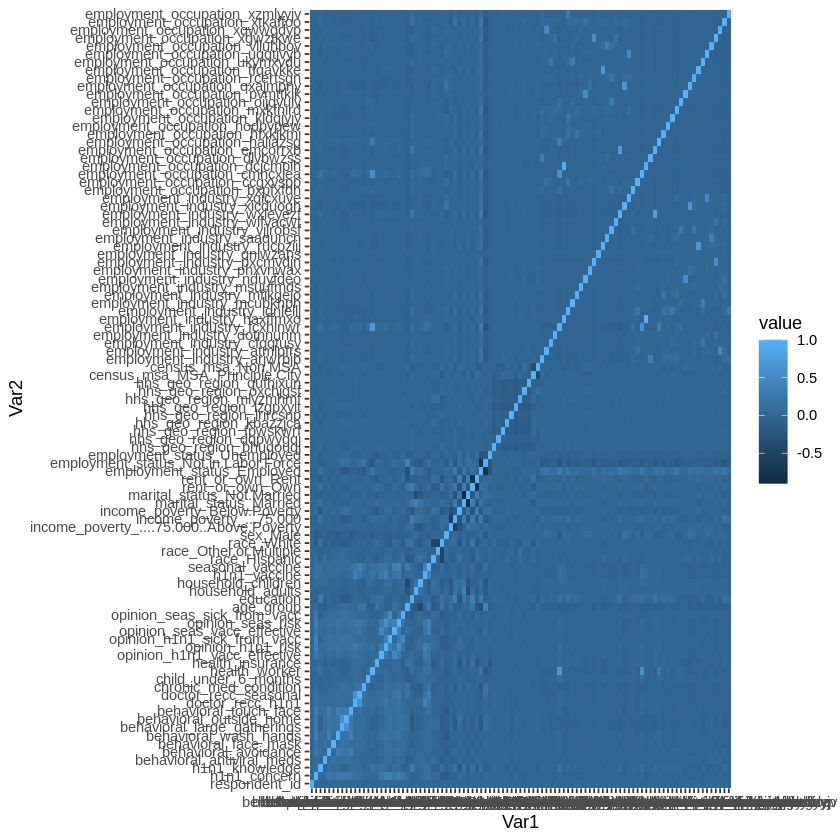

In [122]:
#Correlation matrix with Pearson method
cormat <- round(cor(df_preprocessed, method='pearson'),2)

#Put Correaltion matrix in a form suitable to build heatmap
melted_cormat <- melt(cormat)

#Heatmap
pearson_heatmap<-ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()
pearson_heatmap

In [123]:
#Check for highly correlated value (>0.8)
high_correl_variable<-dplyr::filter(melted_cormat,abs(value)>0.8)
high_correl_variable<-dplyr::filter(high_correl_variable,Var1!=Var2)
high_correl_variable

Var1,Var2,value
<fct>,<fct>,<dbl>
marital_status_Not.Married,marital_status_Married,-0.90
marital_status_Married,marital_status_Not.Married,-0.90
rent_or_own_Rent,rent_or_own_Own,-0.82
rent_or_own_Own,rent_or_own_Rent,-0.82
employment_occupation_dcjcmpih,employment_industry_haxffmxo,1.00
employment_industry_haxffmxo,employment_occupation_dcjcmpih,1.00


We chose to suppress arbitrarily one of the two highly correlated feature.

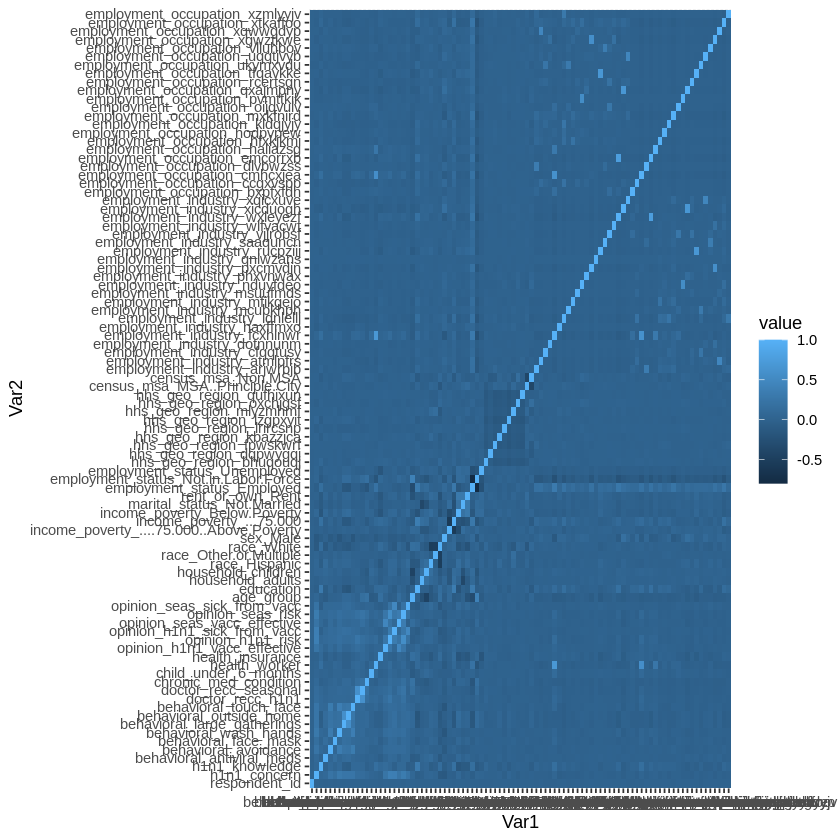

In [124]:
# When two feature are highly correlated we could keep only one of the two <- only old character field are concerned 
droped_variable<-c('marital_status_Married','employment_occupation_dcjcmpih','rent_or_own_Own')
first_selection_df<-dplyr::select(df_preprocessed,-all_of(droped_variable))
first_selection_df<-dplyr::select(first_selection_df,-c('h1n1_vaccine','seasonal_vaccine'))

#Rebuild new Heatmap after feature suppression
cormat <- round(cor(first_selection_df, method='pearson'),2)
melted_cormat <- melt(cormat)
pearson_heatmap<-ggplot(data = melted_cormat, aes(x=Var1, y=Var2, fill=value)) + 
  geom_tile()
pearson_heatmap

#### The personalized LDA usage
Now that this has been achieved, lets dive into Linear Discriminant Analysis. In its boolean two class version ($C_1$,$C_2$), the aim of LDA is to find the axis which would best separate the two class when projecting all the point onto it. As it is represented in the following image for a two feature exemple 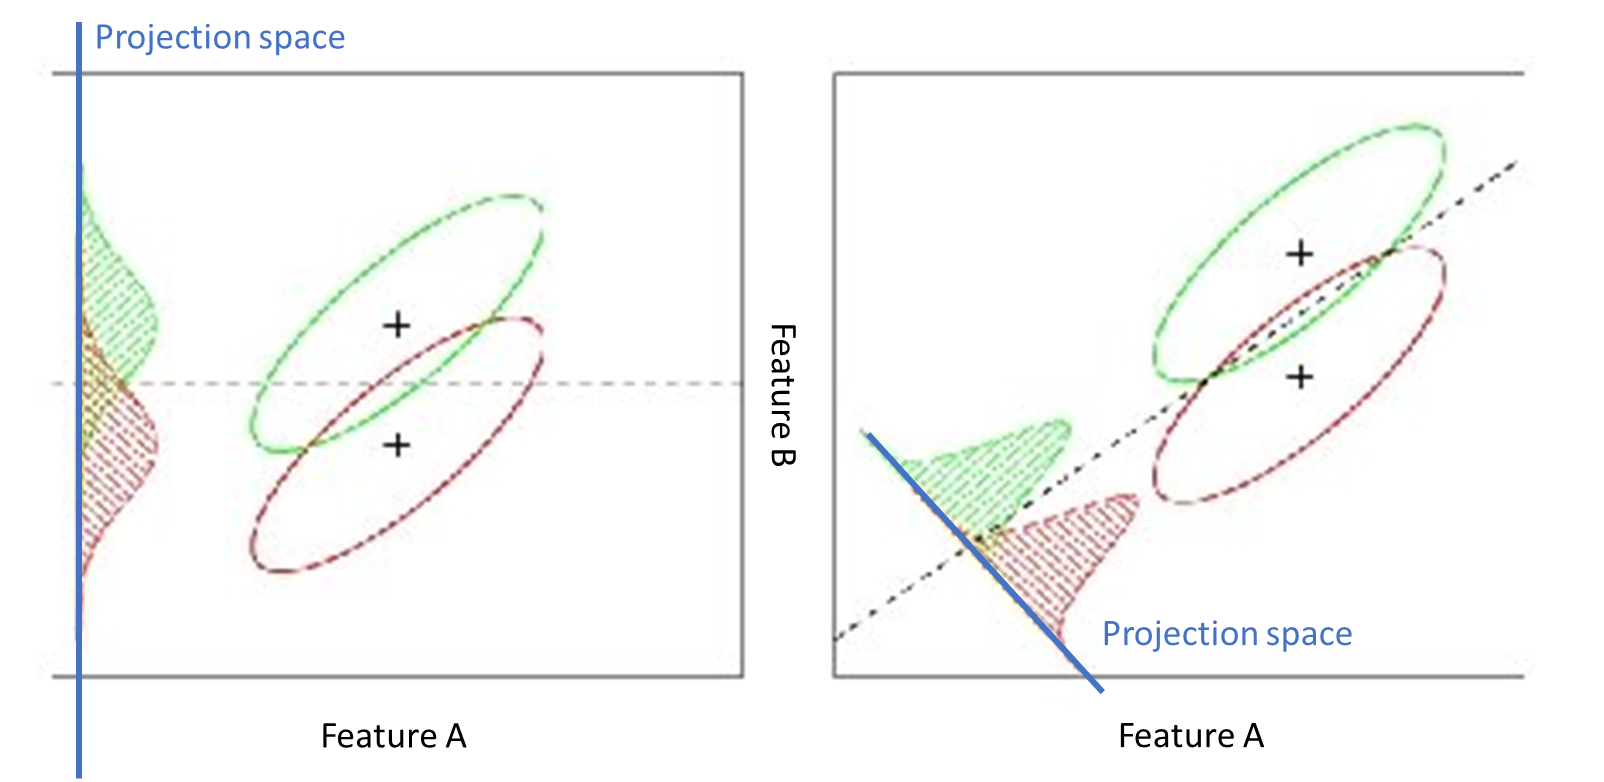
On the left the y axis is chosen as projection space on the right the best projection for separating the data is chosen.

In its mathematical formulation this is retranscribed, after projecting points onto the linear subspace of director vector $v_p$, as maximising the squared distance between the two class centroid $(\mu_1-\mu_2)^2$ while minimizing their respective variance $\sigma_1^2+\sigma_2^2$. These two quantity can be rewrited in terms of the between-class scatter matrix $S_b$ and the within-class scater matrix $S_w$ as
\begin{equation*}
\begin{aligned}
(\mu_1-\mu_2)^2&=v_p^tS_bv_p\\
\sigma_1^2+\sigma_2^2&=v_p^tS_wv_p
\end{aligned}
\end{equation*} 

where $S_b$ and $S_w$ can be written in term of the real class mean $m_1$ and $m_2$ as

\begin{equation*}
\begin{aligned}
S_b&=(m_1-m_2)(m_1-m_2)^t\\
S_w&=\sum_{x_i\in C_1}(x_i-m_1)(x_i-m_1)^t+\sum_{x_i\in C_2}(x_i-m_2)(x_i-m_2)^t
\end{aligned}
\end{equation*}

The whole picture can then be resumed as an optimization problem of the form

\begin{equation*}
\begin{aligned}
\max_{v:|v|=1} \frac{v^TS_bv}{v^TS_wv}
\end{aligned}
\end{equation*}

Which can be solved by looking at the eigenvalue problem 

\begin{equation}
\begin{aligned}
\lambda_pv_p&=S_w^{-1}S_bv_p\\
&=S_w^{-1}(m_1-m_2)\underbrace{(m_1-m_2)^tv_p}_{scalar}\\
\Rightarrow\  v_p&\propto S_w^{-1}(m_1-m_2)
\end{aligned}
\end{equation}
This algorithm is usually used to classify the data with repect to a singel treshold after projecting the data on the right defined by $v_p$ but we chose to use $v_p$ as a tool to select useful feature for the KNN algorithm.

Indeed since $v_p$ represent the direction who would lead to the least overlaping between our two class, it means that its component are a direct inverse measure of the overlaping of each class with respect to the different feature directions. We can then chose to only keep feature whose component in $v_p$ are higher than an arbitrary threshold $x_t$ which then becomes an hyperparameter of our model.

That being said lets start the LDA fetaure selection, it is common to normalize and center the data before applying the above technique :

In [125]:
#Normalization of the feature to [0,1]

for (feature in colnames(first_selection_df)){
  if (feature!='respondent_id'){
  norm_factor=max(first_selection_df[feature])
  first_selection_df[feature]<-(first_selection_df[feature])/norm_factor
  }
}
#Get the mean of each feature to be able to center the data and get the id out of the way
mean_vector<-apply(dplyr::select(first_selection_df,-'respondent_id'),2,mean)
head(mean_vector)

#Center the data
centered_df<-sweep(dplyr::select(first_selection_df,-'respondent_id'),MARGIN = 2,STATS = mean_vector,FUN = '-')
#Bring the id back
centered_df['respondent_id']<-first_selection_df['respondent_id']

#Check that it is indeed centered
mean_centered<-apply(centered_df,2,mean)
head(mean_centered)

h1n1_concern            h1n1_knowledge behavioral_antiviral_meds 
               0.53949527                0.63126622                0.04884367 
     behavioral_avoidance      behavioral_face_mask     behavioral_wash_hands 
               0.72561229                0.06898231                0.82561410

h1n1_concern            h1n1_knowledge behavioral_antiviral_meds 
            -1.508495e-17             -3.687323e-17              1.512812e-18 
     behavioral_avoidance      behavioral_face_mask     behavioral_wash_hands 
            -5.085459e-17             -1.078969e-18              3.550875e-17

Lets compute $m_1$, $m_2$ and separate the point coordinate $x_i$ with repect to their class appartenance

In [126]:
#Bringing the labels back in the picture
h1n1_centered<-dplyr::inner_join(centered_df,df_preprocessed[c('respondent_id','h1n1_vaccine')])
seasonal_centered<-dplyr::inner_join(centered_df,df_preprocessed[c('respondent_id','seasonal_vaccine')])

#Get the mean when grouping with respect to label value (=mean per category m_1 and m_2) :  
h1n1_col_means_class<-h1n1_centered%>% group_by(h1n1_vaccine)%>% summarise(across(.cols = -c('respondent_id'), .fns = mean))
seasonal_col_means_class<-seasonal_centered%>% group_by(seasonal_vaccine)%>% summarise(across(.cols = -c('respondent_id'), .fns = mean))

h1n1_m0<-data.matrix(dplyr::select(h1n1_col_means_class%>%filter(h1n1_vaccine==0),-'h1n1_vaccine'))
h1n1_m1<-data.matrix(dplyr::select(h1n1_col_means_class%>%filter(h1n1_vaccine==1),-'h1n1_vaccine'))
  
seasonal_m0<-data.matrix(dplyr::select(seasonal_col_means_class%>%filter(seasonal_vaccine==0),-'seasonal_vaccine'))
seasonal_m1<-data.matrix(dplyr::select(seasonal_col_means_class%>%filter(seasonal_vaccine==1),-'seasonal_vaccine'))
#Get the covariance matrix for each -> create matrix

centered_h1n1_0<-data.matrix(dplyr::select(h1n1_centered %>% filter(h1n1_vaccine==0),-c('respondent_id','h1n1_vaccine')))
centered_h1n1_1<-data.matrix(dplyr::select(h1n1_centered %>% filter(h1n1_vaccine==1),-c('respondent_id','h1n1_vaccine')))

centered_seasonal_0<-data.matrix(dplyr::select(seasonal_centered %>% filter(seasonal_vaccine==0),-c('respondent_id','seasonal_vaccine')))
centered_seasonal_1<-data.matrix(dplyr::select(seasonal_centered %>% filter(seasonal_vaccine==1),-c('respondent_id','seasonal_vaccine')))

Joining, by = "respondent_id"
Joining, by = "respondent_id"


We have now all what is needed to define $S_b$ and $S_w$ 

In [127]:
#Get the between-class scatter matrix S_b
h1n1_Sb<-(t(h1n1_m0-h1n1_m1))%*%(h1n1_m0-h1n1_m1)
seasonal_Sb<-(t(seasonal_m0-seasonal_m1))%*%(seasonal_m0-seasonal_m1)
# Get the  within-class scatter matrix S_w
h1n1_cov0 <- (t(centered_h1n1_0) %*% centered_h1n1_0)
h1n1_cov1 <- (t(centered_h1n1_1) %*% centered_h1n1_1)

seasonal_cov0 <- (t(centered_seasonal_0) %*% centered_seasonal_0)
seasonal_cov1 <- (t(centered_seasonal_1) %*% centered_seasonal_1)

h1n1_Sw <- h1n1_cov0 + h1n1_cov1
seasonal_Sw = seasonal_cov0 + seasonal_cov1

All what remains to do is to invert $S_w$ and compute $v_p$ 

In [128]:
#Obtain the director vector of the best linear projection

#first invert Sw 
Sw_invert_h1n1<-inv(h1n1_Sw)
Sw_invert_seasonal<-inv((seasonal_Sw))

#Our director vector will be proportionnal to

v_h1n1_unormalized<-Sw_invert_h1n1%*%t(h1n1_m0-h1n1_m1)
v_seasonal_unormalized<-Sw_invert_seasonal%*%t(seasonal_m0-seasonal_m1)

#Lets noramlize it

v_h1n1<-v_h1n1_unormalized/sqrt((t(v_h1n1_unormalized)%*%v_h1n1_unormalized)[1])
v_seasonal<-v_seasonal_unormalized/sqrt((t(v_seasonal_unormalized)%*%v_seasonal_unormalized)[1])

We can now chose an arbitrary threshold $x_t$ and select feature whose component in $v_p$ are bigger than $x_t$

In [129]:
#Lets choose an arbitrary tresholds x_t to keep only component(=feature) of the vector who are above it 
#threshold=0.05 

selector_h1n1<-abs(v_h1n1)>0.05
selector_seasonal<-abs(v_seasonal)>0.05

LDA_dummy_feature_h1n1<-colnames(dplyr::select(centered_df,-'respondent_id')[,selector_h1n1[,1]])
LDA_dummy_feature_seasonal<-colnames(dplyr::select(centered_df,-'respondent_id')[,selector_seasonal[,1]])

#The actual kept feature
LDA_dummy_feature_h1n1
LDA_dummy_feature_seasonal

[1] "h1n1_concern"                   "doctor_recc_h1n1"              
 [3] "doctor_recc_seasonal"           "child_under_6_months"          
 [5] "health_worker"                  "health_insurance"              
 [7] "opinion_h1n1_vacc_effective"    "opinion_h1n1_risk"             
 [9] "opinion_seas_risk"              "opinion_seas_sick_from_vacc"   
[11] "age_group"                      "race_Other.or.Multiple"        
[13] "employment_status_Employed"     "employment_industry_arjwrbjb"  
[15] "employment_industry_fcxhlnwr"   "employment_industry_haxffmxo"  
[17] "employment_industry_nduyfdeo"   "employment_industry_phxvnwax"  
[19] "employment_industry_rucpziij"   "employment_industry_saaquncn"  
[21] "employment_industry_wxleyezf"   "employment_industry_xicduogh"  
[23] "employment_occupation_hfxkjkmi" "employment_occupation_pvmttkik"
[25] "employment_occupation_qxajmpny" "employment_occupation_rcertsgn"
[27] "employment_occupation_tfqavkke"

[1] "h1n1_knowledge"                 "doctor_recc_h1n1"              
 [3] "doctor_recc_seasonal"           "health_worker"                 
 [5] "health_insurance"               "opinion_seas_vacc_effective"   
 [7] "opinion_seas_risk"              "opinion_seas_sick_from_vacc"   
 [9] "age_group"                      "education"                     
[11] "race_Other.or.Multiple"         "race_White"                    
[13] "employment_status_Employed"     "employment_status_Unemployed"  
[15] "employment_industry_arjwrbjb"   "employment_industry_atmlpfrs"  
[17] "employment_industry_dotnnunm"   "employment_industry_fcxhlnwr"  
[19] "employment_industry_haxffmxo"   "employment_industry_mfikgejo"  
[21] "employment_industry_msuufmds"   "employment_industry_phxvnwax"  
[23] "employment_industry_pxcmvdjn"   "employment_industry_wlfvacwt"  
[25] "employment_industry_xicduogh"   "employment_occupation_bxpfxfdn"
[27] "employment_occupation_oijqvulv" "employment_occupation_qxajmpny"
[29] "employment_occupation_ukymxvdu" "employment_occupation_uqqtjvyb"
[31] "employment_occupation_xgwztkwe"

In [130]:
# Since many of this feature are boolean created from categorical feature we can group them back under the original feature name
LDA_feature_h1n1<-c(colnames(feature_df[,colnames(feature_df)%in%LDA_dummy_feature_h1n1]),'employment_industry','age_group','employment_occupation')
LDA_feature_seasonal<-c(colnames(feature_df[,colnames(feature_df)%in%LDA_dummy_feature_seasonal]),'employment_industry','age_group','employment_occupation')

LDA_feature_h1n1
LDA_feature_seasonal

#Lets then only select the relevant feature from our LDA feature selection for our future classification
h1n1_centered=dplyr::select(h1n1_centered,all_of(LDA_dummy_feature_h1n1))
seasonal_centered=dplyr::select(seasonal_centered,all_of(LDA_dummy_feature_seasonal))

[1] "h1n1_concern"                "doctor_recc_h1n1"           
 [3] "doctor_recc_seasonal"        "child_under_6_months"       
 [5] "health_worker"               "health_insurance"           
 [7] "opinion_h1n1_vacc_effective" "opinion_h1n1_risk"          
 [9] "opinion_seas_risk"           "opinion_seas_sick_from_vacc"
[11] "age_group"                   "employment_industry"        
[13] "age_group"                   "employment_occupation"

[1] "h1n1_knowledge"              "doctor_recc_h1n1"           
 [3] "doctor_recc_seasonal"        "health_worker"              
 [5] "health_insurance"            "opinion_seas_vacc_effective"
 [7] "opinion_seas_risk"           "opinion_seas_sick_from_vacc"
 [9] "age_group"                   "education"                  
[11] "employment_industry"         "age_group"                  
[13] "employment_occupation"

Now that this preprocessing has been achieved we can start hard coding our KNN algorithm. The principle of this algorithm is rather simple. And does not require any training procedure. It is a deterministic algorithm which 

In [131]:
#KNN algorithm. Remark: creation of a ball-tree could greatly enhance trainign speed but hardcode one 
#would take me way to much time.

#future apply is a parallelization package for apply() function
library(future.apply)
plan(multisession)


#Minkowski metrix p=1 : Manhatan distance, p=2 : euclidean distance
minkowski<-function(a,b,p){
  sum((abs(b-a)^p)^(1/p))
}

#Nearest neighbor algorithm for a point.
nearest_neighbors = function(obs,train_matrix, k, FUN,p,flu_type,id){
  distance =future_apply(train_matrix,1, FUN,obs,p)
  distances = sort(distance,method='quick')
  neighbor_ind = which(distance %in% distances[1:k])
  #Define probability as the mean of the label value of the neighbors  
  if (flu_type=='h1n1_vaccine'){
    proba=mean(id$h1n1_vaccine[neighbor_ind])
  }
  if (flu_type=='seasonal_vaccine'){
    proba=mean(id$seasonal_vaccine[neighbor_ind])
  }
  return(proba)
  }
#Application of nearest neighbors to each point of the test set
knn_proba=function(test_matrix_1,train_matrix_1,k,p,flu_type,id){
  proba_matrix=future_apply(test_matrix_1,1,nearest_neighbors,train_matrix_1,k,minkowski,p,flu_type,id)
  return(proba_matrix)
}

Lets now make use AUC as the metric for tuning our two hyperparameter $p_{mink}$ and $n_{neighbor}$ using leave one out technique on our training set

Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "5"                                      
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.803400324319249"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "5"                                      
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.795819559132229"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "10"                                     
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.823296020381512"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "10"                                     
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.81473968469252"                       


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "25"                                     
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.828862704676428"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "25"                                     
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.830421082264819"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "50"                                     
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.835506292927972"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "50"                                     
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.835054018805329"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "100"                                    
[3] "neighbors and minkowski metrix of order"
[4] "1"                                      
[5] "is"                                     
[6] "0.835858720539783"                      


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



[1] "AUC-ROC curves for"                     
[2] "100"                                    
[3] "neighbors and minkowski metrix of order"
[4] "2"                                      
[5] "is"                                     
[6] "0.836782078043798"                      
[1] "our best hyperparameter are k="  "100"                            
[3] "for minkowski distance of order" "2"                              
[1] "The corresponding ROC curves are :"


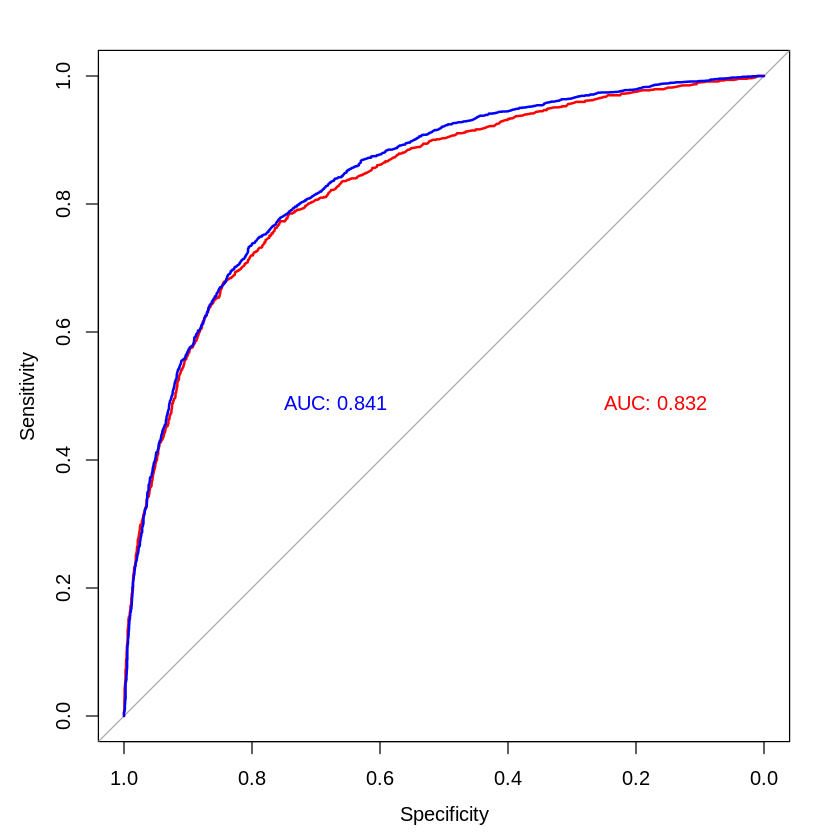

In [21]:
#DISCLAIMER : THIS BLOCK WILL TAKE MORE THAN AN HOUR TO RUN, DO NOT RUN IT!!!

#library pROC to plot ROC curve and compute AUC for hyperparameter tuning
library(pROC)

#Put the data in matricial form for commodity.
h1n1_matrix=data.matrix(h1n1_centered)
seasonal_matrix=data.matrix(seasonal_centered)

#Start of leave one out hyperparameter tuning.
best_mean=0
for (nbr_neighbor in c(5,10,25,50,100)){
  for (p_mink in c(1,2)){
    #Define train and test sample from training sample for leave one out computation of AUC of the ROC curves
    training_id.samples = training_label$respondent_id%>%createDataPartition(p = 0.8, list = FALSE)
    train_h1n1.data  = h1n1_matrix[training_id.samples, ]
    test_h1n1.data = h1n1_matrix[-training_id.samples, ]
    train_seasonal.data  = seasonal_matrix[training_id.samples, ]
    test_seasonal.data = seasonal_matrix[-training_id.samples, ]
    test_label_frame=training_label[-training_id.samples,]
    training_label_frame=training_label[training_id.samples,]
      
    # Build the model proba.
    h1n1_proba=knn_proba(test_h1n1.data,train_h1n1.data,nbr_neighbor,p_mink,'h1n1_vaccine',training_label_frame)
    seasonal_proba=knn_proba(test_seasonal.data,train_seasonal.data,nbr_neighbor,p_mink,'seasonal_vaccine',training_label_frame)
    
    #Compute the AUC-ROC curve.
    roc_h1n1=roc(test_label_frame$h1n1_vaccine, h1n1_proba,auc=TRUE)
    roc_seasonal=roc(test_label_frame$seasonal_vaccine, seasonal_proba,auc=TRUE)
    actual_mean=mean(mean(c(auc(roc_h1n1),auc(roc_seasonal))))
    print(unlist(list('AUC-ROC curves for' , nbr_neighbor,'neighbors and minkowski metrix of order',p_mink,'is',actual_mean)))
    if (actual_mean>best_mean)
    {
      best_mean=actual_mean
      best_roc_h1n1=roc_h1n1
      best_roc_seasonal=roc_seasonal
      p_best=p_mink
      n_best=nbr_neighbor
    }
  }
}
#Plot best ROC curve with AUC
print(unlist(list('our best hyperparameter are k=',n_best,'for minkowski distance of order',p_best)))
print('The corresponding ROC curves are :')
plot.roc(best_roc_h1n1,print.auc=TRUE,print.auc.x=0.25, print.auc.y=0.5,col='red')
plot.roc(best_roc_seasonal,add=TRUE,print.auc=TRUE,print.auc.x=0.75, print.auc.y=0.5,col = 'blue')

Lets then keep in memory the result of our best model applied to the test set in case we want to submit it. To do so we need to make the test set go through the LDA preprocessing pipeline :

In [132]:
#First need to put the test data in the same form as the training set = data pipeline
test_df$age_group = as.numeric(factor(test_df$age_group,levels = c('18 - 34 Years', '35 - 44 Years', '45 - 54 Years','55 - 64 Years','65+ Years'),labels = c(0,1,2,3,4)))
test_df$education = as.numeric(factor(test_df$education,levels = c('','< 12 Years', '12 Years', 'Some College','College Graduate'),labels = c(0,1,2,3,4)))

test_dummy_df<-fastDummies::dummy_cols(test_df,remove_first_dummy = TRUE)
test_int_df<-dplyr::select(test_dummy_df,!category_list)
test_df_preprocessed<-data.frame(apply(test_int_df,2,replace_na_with_mean_value))
test_selection_df<-dplyr::select(test_df_preprocessed,-droped_variable)

for (feature in colnames(test_selection_df)){
  if (feature!='respondent_id'){
    norm_factor=max(test_selection_df[feature])
    test_selection_df[feature]<-(test_selection_df[feature])/norm_factor
  }
}
test_mean_vector<-apply(dplyr::select(test_selection_df,-'respondent_id'),2,mean)
test_centered_df<-sweep(dplyr::select(test_selection_df,-'respondent_id'),MARGIN = 2,STATS = test_mean_vector,FUN = '-')
test_mean_centered<-apply(test_centered_df,2,mean)

test_centered_h1n1=dplyr::select(test_centered_df,all_of(LDA_dummy_feature_h1n1))
test_centered_seasonal=dplyr::select(test_centered_df,all_of(LDA_dummy_feature_seasonal))


test_h1n1_matrix=data.matrix(test_centered_h1n1)
test_seasonal_matrix=data.matrix(test_centered_seasonal)

In [135]:
#Write the best model for submitting
#Select only the relevant feature from LDA.
h1n1_centered=dplyr::select(h1n1_centered,all_of(LDA_dummy_feature_h1n1))
seasonal_centered=dplyr::select(seasonal_centered,all_of(LDA_dummy_feature_seasonal))

h1n1_matrix=data.matrix(h1n1_centered)
seasonal_matrix=data.matrix(seasonal_centered)
#Put the data in matricial form for commodity.
h1n1_best=knn_proba(test_h1n1_matrix,h1n1_matrix,100,2,'h1n1_vaccine',training_label)
seasonal_best=knn_proba(test_seasonal_matrix,seasonal_matrix,100,2,'seasonal_vaccine',training_label)
full_matrix=do.call("cbind", list(test_set$respondent_id, h1n1_best,seasonal_best))
knn_return_frame=tibble('respondent_id'=full_matrix[,1],'h1n1_vaccine'=full_matrix[,2],'seasonal_vaccine'=full_matrix[,3])
write.csv(knn_return_frame,'knn_best', row.names = FALSE)

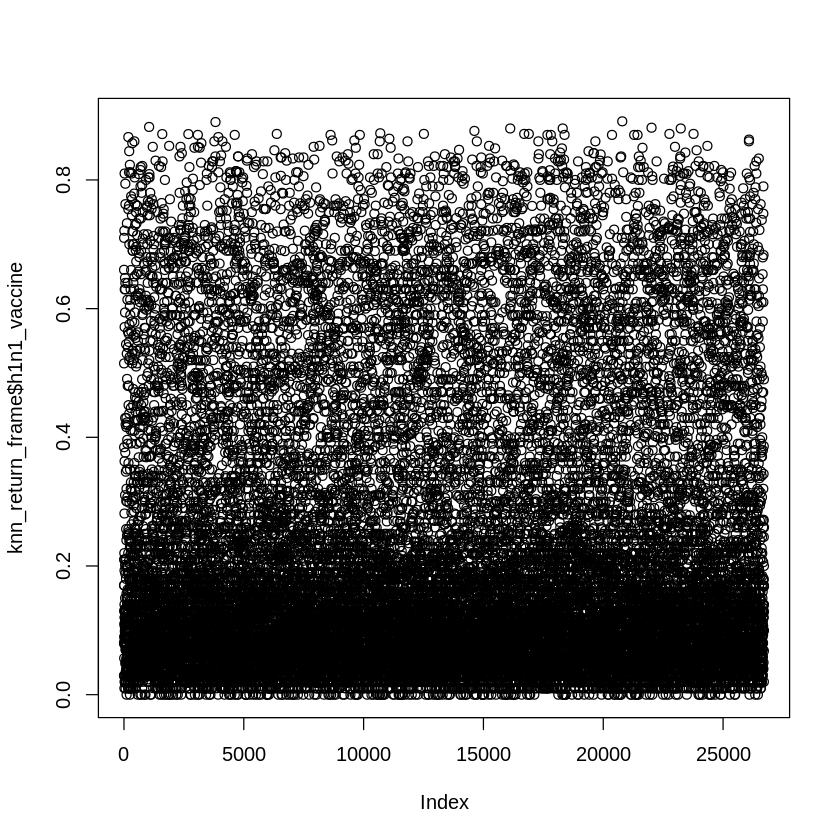

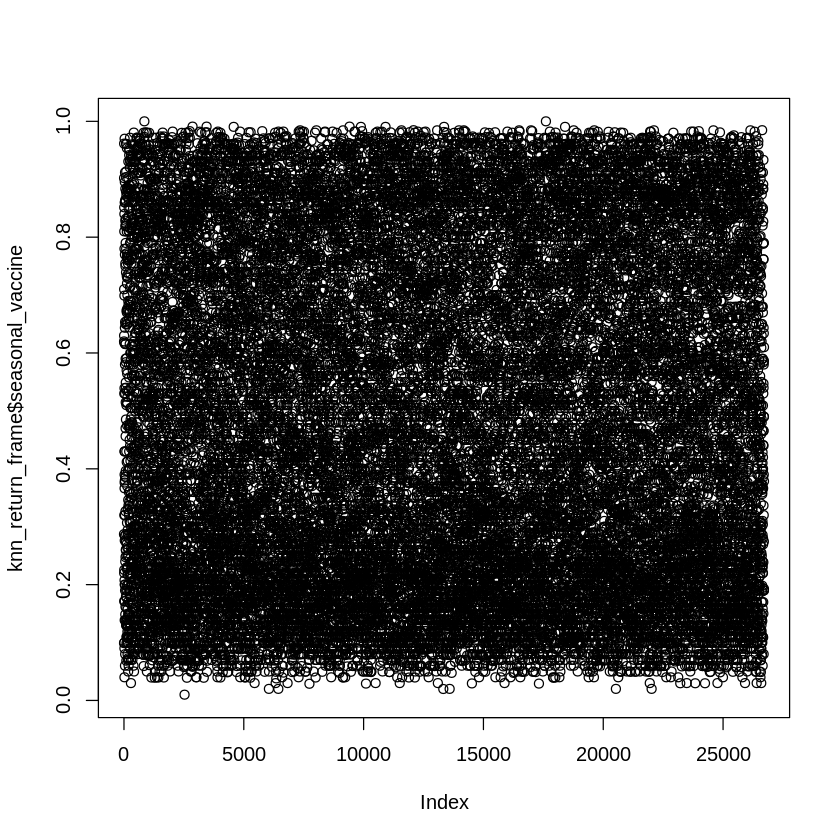

In [136]:
plot(knn_return_frameturn_frame$h1n1_vaccine)
plot(knn_return_frame$seasonal_vaccine)

There is still one "pseudo-hyperparameter" which we still not toyed with which is the arbitrary treshold of $x_t$ for the component of $v_p$ to keep. As it has been achieved for the other method a wrapping method for chosing the best threshold $x_t$ could be proceded but since the other method achieve significantly better result this would probably be a loss of time and we stop our hyperparameter tuning here. 

Final best hyperparmater for $x_t$=0.05 :

\begin{equation}
\begin{aligned}
n_{neighbor}&=100\\
p_{min}k&=2
\end{aligned}
\end{equation}
The high number of neighbor is a good news since it means that our model has low variance. This means that we could guess that the AUC of the ROC curve we would obtain by submitting our file will not be too far that the one obtained with the leave one out validation procedure.

## Model 3 - Neural network (Nnet)



In [176]:
#Load data from usual pipeline
training_set<-read.csv('normalized_data.csv',header=TRUE)
training_label<-read.csv('training_set_labels.csv',header=TRUE)
test_set_norm<-read.csv('normalized_test.csv',header=TRUE)

In [177]:
#remove the id_respondent column for datasets to be used in the nnet function
training_set <- training_set[,2:36]

#nnet will work with one single final neuron. Select the relevant label neuron
label_h1n1 <- as.numeric(training_label[,2])
label_seasonal <- as.numeric(training_label[,3])

nnet is a function computing a neural network trained on a training set to be categorized based on training labels. The S3 default method is used. In that case, the main inputs are:

   - x - data.frame of training inputs
   - y - data.frame of targeted values
   - weights - case weights for each example (if missing, defaults to 1) In our project, we decide to use the default value
   - size - defines the number of intermediate neurons. It seems that the number of weights cannot exceed a certain amount, therefore the total number of neurons (first and second layer) is also limited.
   - na.action - to define actions in case of na. As datasets are completed, this function is not needed
   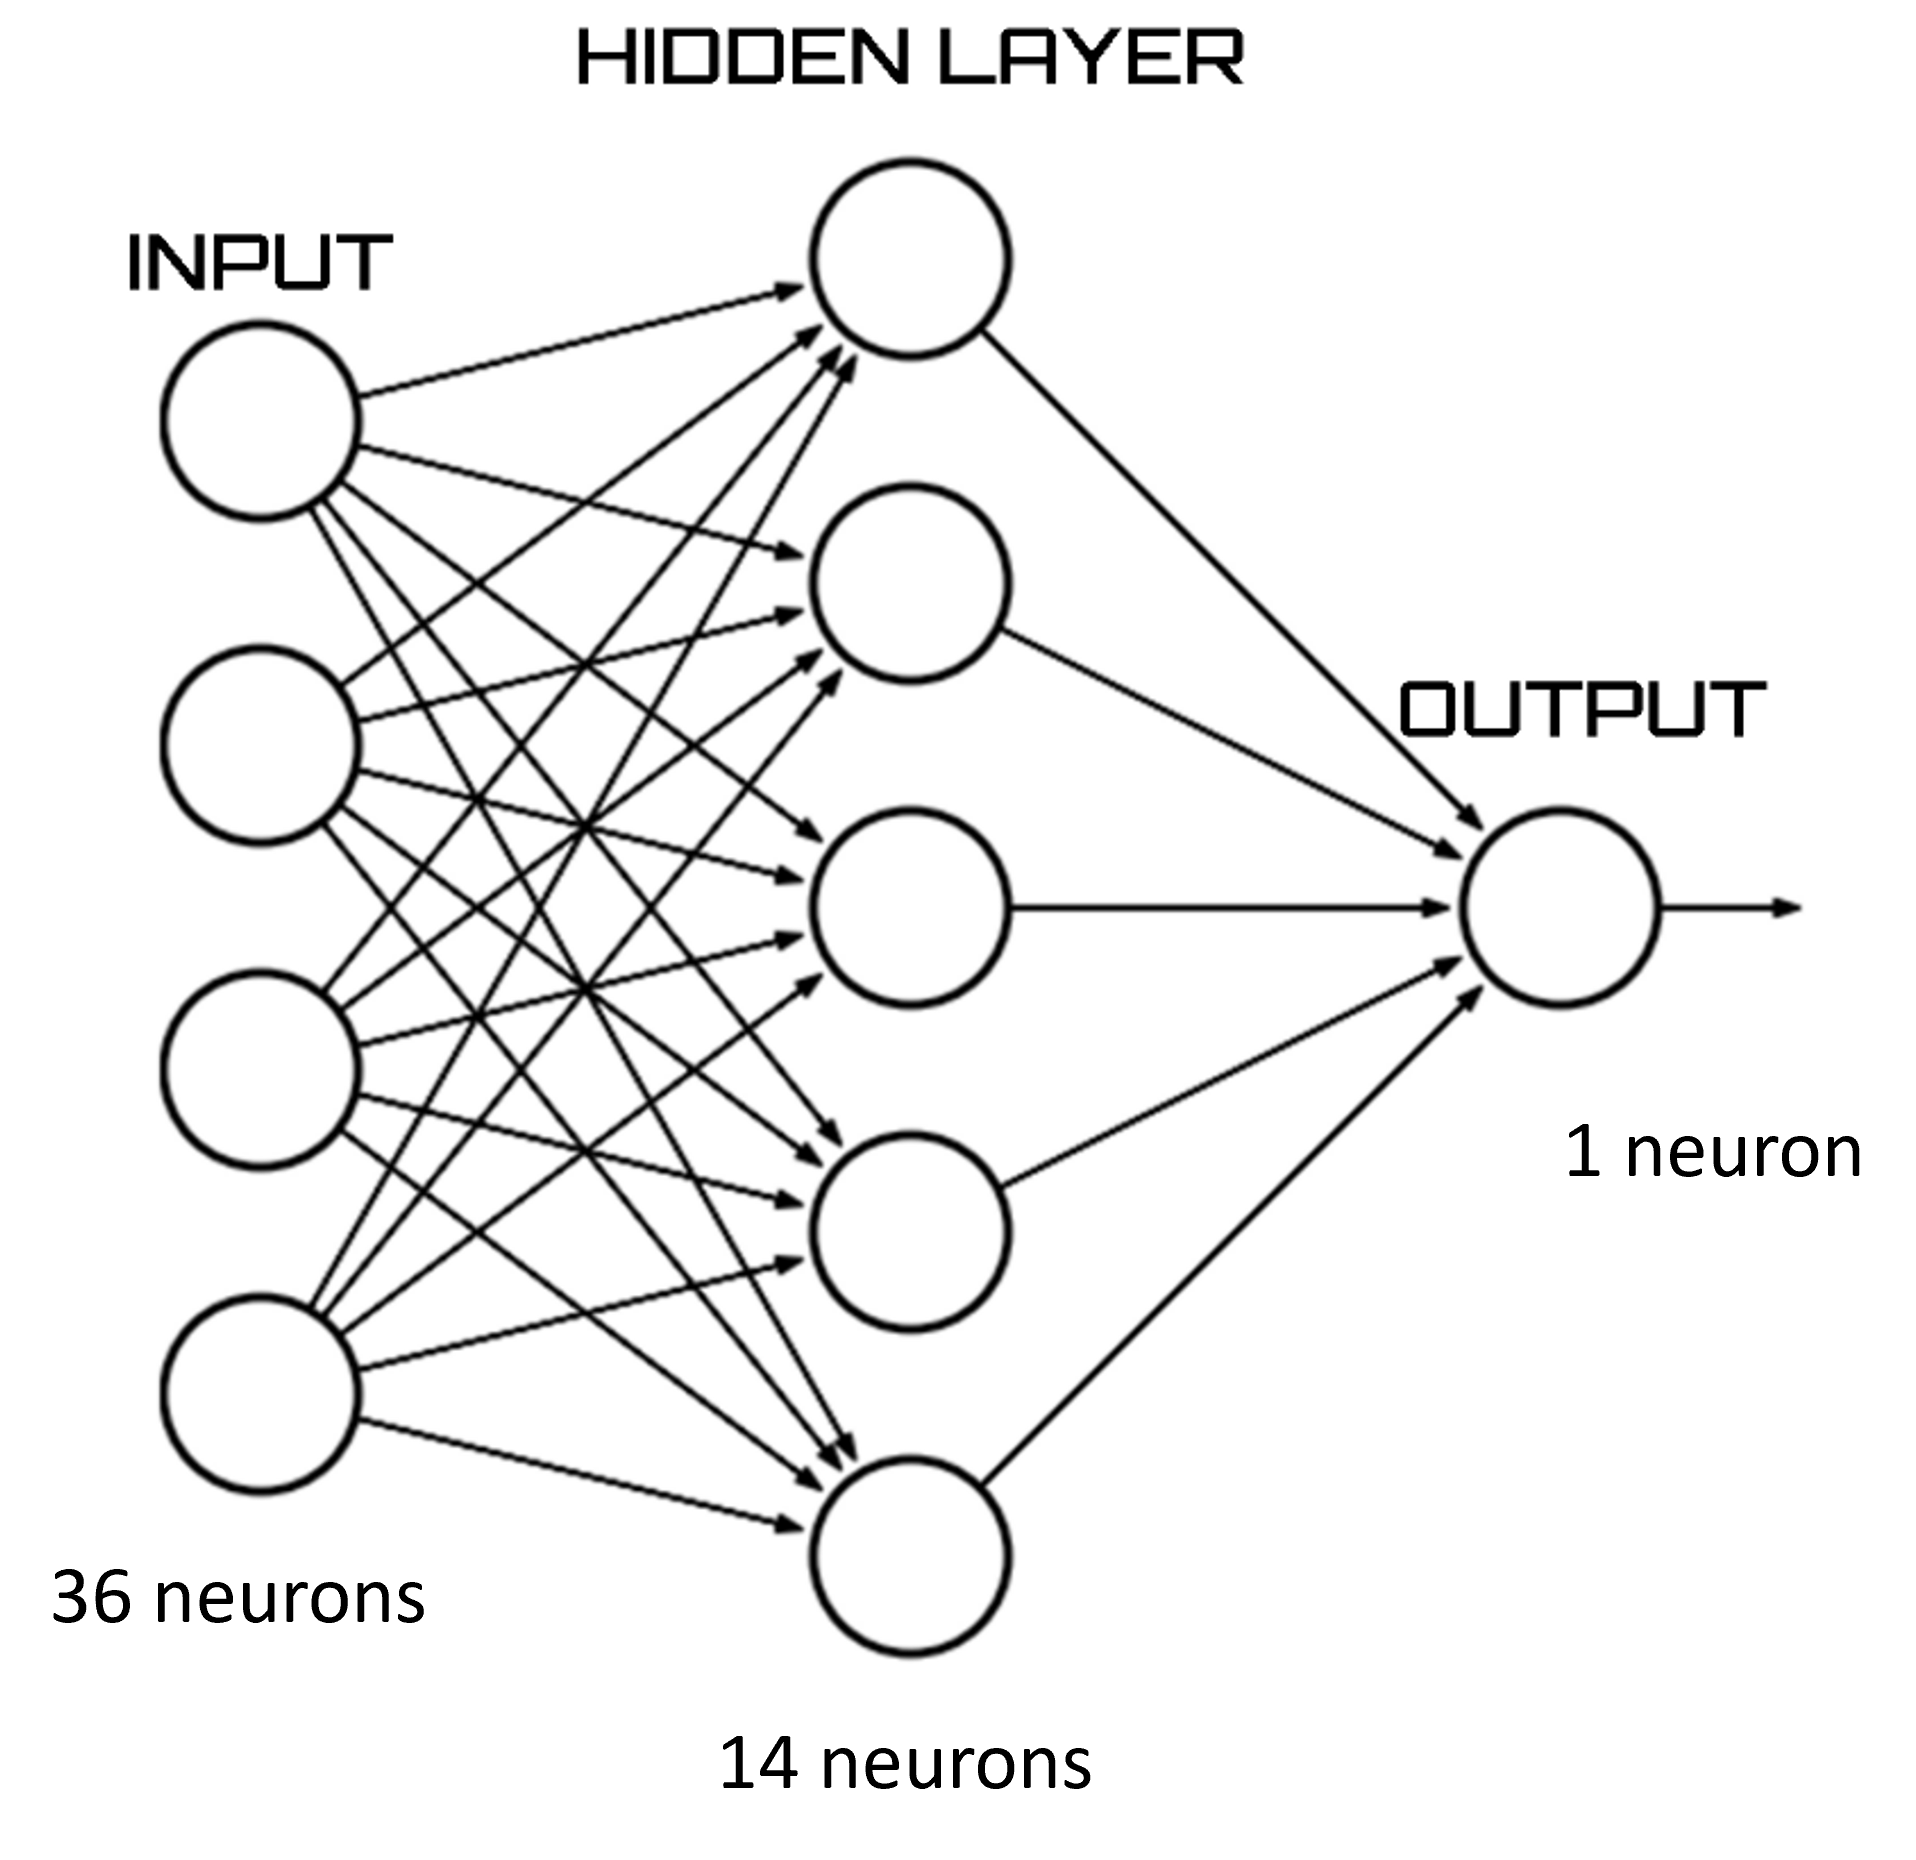

In [ ]:
#create data.frame and csv submission file
submit<-data.frame(training_label[,1],ypred_h1n1,ypred_seasonal)
write.csv(submit,"C:/Users/Admin/Documents/ULB/Cours/INFO-F422/Projet/submit.csv", row.names = TRUE)

# weights:  71
initial  value 6442.599351 
iter  10 value 3286.224870
iter  20 value 3040.267448
iter  30 value 2949.716438
iter  40 value 2915.684761
iter  50 value 2907.020267
iter  60 value 2904.030252
iter  70 value 2902.975163
iter  80 value 2902.514782
iter  90 value 2901.999023
iter 100 value 2901.808237
final  value 2901.808237 
stopped after 100 iterations
# weights:  71
initial  value 6094.784209 
iter  10 value 4500.198728
iter  20 value 4419.941238
iter  30 value 4335.965056
iter  40 value 4305.793261
iter  50 value 4290.713385
iter  60 value 4286.265394
iter  70 value 4284.524178
iter  80 value 4283.156795
iter  90 value 4282.153482
iter 100 value 4281.442994
final  value 4281.442994 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.767657063294252"        
# weights:  71
initial  value 3848.197813 
iter  10 value 3044.307375
iter  20 value 2878.666684
iter  30 value 2867.320027
iter  40 value 2860.137483
iter  50 value 2858.685029
iter  60 value 2855.494282
iter  70 value 2849.047490
iter  80 value 2847.124556
iter  90 value 2845.515136
iter 100 value 2844.514676
final  value 2844.514676 
stopped after 100 iterations
# weights:  71
initial  value 6222.973551 
iter  10 value 4337.401031
iter  20 value 4291.974748
iter  30 value 4242.145738
iter  40 value 4226.964231
iter  50 value 4213.779254
iter  60 value 4211.169116
iter  70 value 4208.898668
iter  80 value 4206.779586
iter  90 value 4205.338939
iter 100 value 4203.124527
final  value 4203.124527 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.768252630598954"        
# weights:  71
initial  value 4506.729785 
iter  10 value 3510.776510
iter  20 value 3155.649461
iter  30 value 2876.567156
iter  40 value 2847.492087
iter  50 value 2823.305539
iter  60 value 2804.357855
iter  70 value 2800.548257
iter  80 value 2797.802845
iter  90 value 2787.285827
iter 100 value 2774.736592
final  value 2774.736592 
stopped after 100 iterations
# weights:  71
initial  value 5385.603325 
iter  10 value 4342.813259
iter  20 value 4295.774913
iter  30 value 4237.072844
iter  40 value 4200.013418
iter  50 value 4189.490582
iter  60 value 4184.526159
iter  70 value 4180.767578
iter  80 value 4178.322589
iter  90 value 4175.771666
iter 100 value 4173.212608
final  value 4173.212608 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.790178098445127"        
# weights:  71
initial  value 3665.280293 
iter  10 value 3051.414318
iter  20 value 2852.165892
iter  30 value 2832.024754
iter  40 value 2818.892169
iter  50 value 2782.755242
iter  60 value 2759.165346
iter  70 value 2754.466120
iter  80 value 2752.288907
iter  90 value 2751.042922
iter 100 value 2749.534449
final  value 2749.534449 
stopped after 100 iterations
# weights:  71
initial  value 7126.076520 
iter  10 value 4338.116444
iter  20 value 4293.031508
iter  30 value 4248.526180
iter  40 value 4199.968169
iter  50 value 4178.816364
iter  60 value 4170.614685
iter  70 value 4163.590375
iter  80 value 4159.983842
iter  90 value 4157.788497
iter 100 value 4156.116587
final  value 4156.116587 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.7796047582494"          
# weights:  141
initial  value 5631.237128 
iter  10 value 3396.120157
iter  20 value 3071.254659
iter  30 value 2969.468474
iter  40 value 2945.094132
iter  50 value 2938.834567
iter  60 value 2935.385390
iter  70 value 2933.715935
iter  80 value 2932.615316
iter  90 value 2931.845556
iter 100 value 2931.319684
final  value 2931.319684 
stopped after 100 iterations
# weights:  141
initial  value 6824.462635 
iter  10 value 4348.268700
iter  20 value 4324.434559
iter  30 value 4299.784376
iter  40 value 4289.494169
iter  50 value 4285.317026
iter  60 value 4281.756660
iter  70 value 4280.824906
iter  80 value 4280.461047
iter  90 value 4280.066045
iter 100 value 4279.645599
final  value 4279.645599 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.770600936323481"        
# weights:  141
initial  value 10723.373209 
iter  10 value 4101.417354
iter  20 value 3047.376211
iter  30 value 2898.027855
iter  40 value 2830.536633
iter  50 value 2810.362939
iter  60 value 2802.443447
iter  70 value 2798.812835
iter  80 value 2796.260755
iter  90 value 2795.132535
iter 100 value 2794.346964
final  value 2794.346964 
stopped after 100 iterations
# weights:  141
initial  value 5165.700856 
iter  10 value 4335.647138
iter  20 value 4273.923198
iter  30 value 4236.345516
iter  40 value 4218.843532
iter  50 value 4210.707054
iter  60 value 4205.213812
iter  70 value 4202.341992
iter  80 value 4200.655736
iter  90 value 4198.308895
iter 100 value 4195.434379
final  value 4195.434379 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.787973127268893"        
# weights:  141
initial  value 8776.571387 
iter  10 value 4549.059181
iter  20 value 4489.439788
iter  30 value 2986.037388
iter  40 value 2858.469812
iter  50 value 2845.145631
iter  60 value 2837.105166
iter  70 value 2831.256469
iter  80 value 2822.737190
iter  90 value 2807.536843
iter 100 value 2801.721559
final  value 2801.721559 
stopped after 100 iterations
# weights:  141
initial  value 5580.771440 
iter  10 value 4314.131664
iter  20 value 4263.713976
iter  30 value 4210.007303
iter  40 value 4177.941098
iter  50 value 4164.582538
iter  60 value 4157.108285
iter  70 value 4152.314167
iter  80 value 4145.526728
iter  90 value 4142.119728
iter 100 value 4139.437172
final  value 4139.437172 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.766615770420607"        
# weights:  141
initial  value 5629.999508 
iter  10 value 4520.192079
iter  20 value 4519.174056
iter  30 value 3747.824740
iter  40 value 2976.300328
iter  50 value 2847.519059
iter  60 value 2815.447252
iter  70 value 2796.160755
iter  80 value 2783.922776
iter  90 value 2776.395369
iter 100 value 2765.626720
final  value 2765.626720 
stopped after 100 iterations
# weights:  141
initial  value 5445.705738 
iter  10 value 4356.420624
iter  20 value 4311.858427
iter  30 value 4256.539273
iter  40 value 4227.665753
iter  50 value 4210.378332
iter  60 value 4197.566352
iter  70 value 4189.323544
iter  80 value 4183.275900
iter  90 value 4179.545485
iter 100 value 4176.686828
final  value 4176.686828 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.775369678603206"        
# weights:  211
initial  value 3670.695009 
iter  10 value 3086.511032
iter  20 value 2970.348854
iter  30 value 2944.870091
iter  40 value 2940.684960
iter  50 value 2938.733113
iter  60 value 2938.100173
iter  70 value 2937.761698
iter  80 value 2937.460334
iter  90 value 2937.254379
iter 100 value 2937.116155
final  value 2937.116155 
stopped after 100 iterations
# weights:  211
initial  value 5651.451212 
iter  10 value 4361.399034
iter  20 value 4324.556729
iter  30 value 4304.554711
iter  40 value 4294.265252
iter  50 value 4289.109877
iter  60 value 4286.188349
iter  70 value 4284.763276
iter  80 value 4283.728340
iter  90 value 4283.176767
iter 100 value 4282.851222
final  value 4282.851222 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.771027287092572"        
# weights:  211
initial  value 3806.050722 
iter  10 value 3047.570294
iter  20 value 2921.669325
iter  30 value 2884.203865
iter  40 value 2868.409294
iter  50 value 2856.201123
iter  60 value 2851.785421
iter  70 value 2849.091980
iter  80 value 2847.545863
iter  90 value 2846.443266
iter 100 value 2845.974306
final  value 2845.974306 
stopped after 100 iterations
# weights:  211
initial  value 9416.187505 
iter  10 value 4823.392938
iter  20 value 4375.871085
iter  30 value 4334.137247
iter  40 value 4299.830604
iter  50 value 4257.058344
iter  60 value 4240.033333
iter  70 value 4233.662024
iter  80 value 4230.490631
iter  90 value 4227.179641
iter 100 value 4224.186492
final  value 4224.186492 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.781664365909778"        
# weights:  211
initial  value 6327.107998 
iter  10 value 4585.544941
iter  20 value 3161.837549
iter  30 value 2954.744602
iter  40 value 2870.189969
iter  50 value 2842.328686
iter  60 value 2829.218400
iter  70 value 2821.423916
iter  80 value 2816.071609
iter  90 value 2813.372844
iter 100 value 2811.627936
final  value 2811.627936 
stopped after 100 iterations
# weights:  211
initial  value 5747.593744 
iter  10 value 4316.978752
iter  20 value 4244.532920
iter  30 value 4198.482910
iter  40 value 4179.085665
iter  50 value 4169.009566
iter  60 value 4163.139457
iter  70 value 4157.793834
iter  80 value 4152.714340
iter  90 value 4148.988444
iter 100 value 4147.488458
final  value 4147.488458 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.771521901035379"        
# weights:  211
initial  value 4239.555311 
iter  10 value 3004.850812
iter  20 value 2842.288264
iter  30 value 2824.195170
iter  40 value 2805.646948
iter  50 value 2794.683700
iter  60 value 2788.971702
iter  70 value 2783.751599
iter  80 value 2777.972339
iter  90 value 2773.948019
iter 100 value 2770.953646
final  value 2770.953646 
stopped after 100 iterations
# weights:  211
initial  value 5361.751311 
iter  10 value 4327.707635
iter  20 value 4262.874602
iter  30 value 4213.424712
iter  40 value 4195.186345
iter  50 value 4183.925552
iter  60 value 4174.987095
iter  70 value 4167.410545
iter  80 value 4160.515287
iter  90 value 4153.907029
iter 100 value 4149.460306
final  value 4149.460306 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "5"                        
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.770298149519126"        
# weights:  121
initial  value 3555.281454 
iter  10 value 2905.213012
iter  20 value 2832.286169
iter  30 value 2804.415313
iter  40 value 2784.811539
iter  50 value 2781.247460
iter  60 value 2779.449396
iter  70 value 2778.501389
iter  80 value 2777.661879
iter  90 value 2777.123817
iter 100 value 2776.874505
final  value 2776.874505 
stopped after 100 iterations
# weights:  121
initial  value 5327.838963 
iter  10 value 4154.853303
iter  20 value 4131.875114
iter  30 value 4110.479411
iter  40 value 4089.467868
iter  50 value 4082.482395
iter  60 value 4078.510950
iter  70 value 4076.482067
iter  80 value 4074.078250
iter  90 value 4073.309195
iter 100 value 4072.915516
final  value 4072.915516 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.789667115209611"        
# weights:  121
initial  value 5695.606402 
iter  10 value 4498.215397
iter  20 value 2962.641800
iter  30 value 2816.214237
iter  40 value 2723.244906
iter  50 value 2689.592137
iter  60 value 2668.638340
iter  70 value 2660.599450
iter  80 value 2657.698031
iter  90 value 2654.775513
iter 100 value 2651.927822
final  value 2651.927822 
stopped after 100 iterations
# weights:  121
initial  value 6284.487101 
iter  10 value 4170.752769
iter  20 value 4096.286625
iter  30 value 4060.438640
iter  40 value 4023.763139
iter  50 value 4007.371583
iter  60 value 3997.451464
iter  70 value 3984.805342
iter  80 value 3977.907047
iter  90 value 3974.231762
iter 100 value 3972.328603
final  value 3972.328603 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.791791802416341"        
# weights:  121
initial  value 4579.101968 
iter  10 value 4534.367369
iter  20 value 2906.906909
iter  30 value 2678.582799
iter  40 value 2636.377977
iter  50 value 2617.744509
iter  60 value 2595.454383
iter  70 value 2580.091024
iter  80 value 2566.532324
iter  90 value 2556.693059
iter 100 value 2548.003235
final  value 2548.003235 
stopped after 100 iterations
# weights:  121
initial  value 5387.448579 
iter  10 value 4142.092936
iter  20 value 4075.202391
iter  30 value 4026.308849
iter  40 value 3989.920027
iter  50 value 3968.491735
iter  60 value 3944.319741
iter  70 value 3936.169398
iter  80 value 3932.515662
iter  90 value 3930.132877
iter 100 value 3928.664729
final  value 3928.664729 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.799677172782799"        
# weights:  121
initial  value 9406.752287 
iter  10 value 3493.191683
iter  20 value 2843.550426
iter  30 value 2670.451426
iter  40 value 2619.677211
iter  50 value 2585.557447
iter  60 value 2567.527321
iter  70 value 2561.889258
iter  80 value 2559.654582
iter  90 value 2555.561024
iter 100 value 2549.866284
final  value 2549.866284 
stopped after 100 iterations
# weights:  121
initial  value 5515.565011 
iter  10 value 4175.497168
iter  20 value 4124.439135
iter  30 value 4075.863808
iter  40 value 4007.803920
iter  50 value 3979.877747
iter  60 value 3963.638611
iter  70 value 3951.446673
iter  80 value 3942.847683
iter  90 value 3939.477163
iter 100 value 3936.120867
final  value 3936.120867 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.804984392991349"        
# weights:  241
initial  value 7345.685167 
iter  10 value 3504.774952
iter  20 value 2996.022247
iter  30 value 2898.803092
iter  40 value 2834.264284
iter  50 value 2807.464456
iter  60 value 2794.531618
iter  70 value 2790.328196
iter  80 value 2787.112824
iter  90 value 2785.248655
iter 100 value 2784.057802
final  value 2784.057802 
stopped after 100 iterations
# weights:  241
initial  value 6138.878516 
iter  10 value 4388.376498
iter  20 value 4323.049276
iter  30 value 4272.515724
iter  40 value 4223.975119
iter  50 value 4176.312526
iter  60 value 4141.526712
iter  70 value 4130.662970
iter  80 value 4123.158817
iter  90 value 4118.910153
iter 100 value 4115.243914
final  value 4115.243914 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.801915931605022"        
# weights:  241
initial  value 3945.021659 
iter  10 value 2893.049920
iter  20 value 2758.461791
iter  30 value 2725.304341
iter  40 value 2707.638465
iter  50 value 2697.256335
iter  60 value 2691.677584
iter  70 value 2686.848816
iter  80 value 2684.098595
iter  90 value 2682.357436
iter 100 value 2680.996198
final  value 2680.996198 
stopped after 100 iterations
# weights:  241
initial  value 7586.132634 
iter  10 value 4170.263131
iter  20 value 4095.961250
iter  30 value 4062.175022
iter  40 value 4037.176054
iter  50 value 4023.915397
iter  60 value 4017.276972
iter  70 value 4006.044426
iter  80 value 3996.737449
iter  90 value 3989.557630
iter 100 value 3985.985347
final  value 3985.985347 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.799505412378058"        
# weights:  241
initial  value 10690.021857 
iter  10 value 4536.927069
iter  20 value 3419.011631
iter  30 value 2912.610844
iter  40 value 2711.391627
iter  50 value 2625.745545
iter  60 value 2592.603105
iter  70 value 2571.556963
iter  80 value 2562.173613
iter  90 value 2555.905006
iter 100 value 2549.070238
final  value 2549.070238 
stopped after 100 iterations
# weights:  241
initial  value 6066.160849 
iter  10 value 4154.676392
iter  20 value 4090.947268
iter  30 value 4051.847388
iter  40 value 4010.221352
iter  50 value 3984.470253
iter  60 value 3974.321701
iter  70 value 3959.059425
iter  80 value 3945.707511
iter  90 value 3936.910988
iter 100 value 3930.970977
final  value 3930.970977 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.811311349796974"        
# weights:  241
initial  value 9087.682532 
iter  10 value 4530.542699
iter  20 value 2840.860136
iter  30 value 2705.283571
iter  40 value 2669.274683
iter  50 value 2647.804279
iter  60 value 2628.655204
iter  70 value 2605.192642
iter  80 value 2581.300767
iter  90 value 2546.478563
iter 100 value 2526.240572
final  value 2526.240572 
stopped after 100 iterations
# weights:  241
initial  value 5368.703045 
iter  10 value 4116.490902
iter  20 value 4056.122376
iter  30 value 3999.607415
iter  40 value 3965.196844
iter  50 value 3943.418001
iter  60 value 3920.954099
iter  70 value 3907.978375
iter  80 value 3895.345726
iter  90 value 3883.352561
iter 100 value 3872.619248
final  value 3872.619248 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.796105918805028"        
# weights:  361
initial  value 7521.702197 
iter  10 value 3394.849715
iter  20 value 2932.081560
iter  30 value 2845.042079
iter  40 value 2813.973723
iter  50 value 2792.125169
iter  60 value 2784.385557
iter  70 value 2780.654446
iter  80 value 2778.973882
iter  90 value 2778.193781
iter 100 value 2777.509216
final  value 2777.509216 
stopped after 100 iterations
# weights:  361
initial  value 5937.959292 
iter  10 value 4151.997607
iter  20 value 4110.712953
iter  30 value 4081.211702
iter  40 value 4068.780511
iter  50 value 4061.861834
iter  60 value 4059.089044
iter  70 value 4056.317708
iter  80 value 4054.532156
iter  90 value 4053.628416
iter 100 value 4053.309582
final  value 4053.309582 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.781325091514693"        
# weights:  361
initial  value 5112.710866 
iter  10 value 3403.800057
iter  20 value 2905.983186
iter  30 value 2808.619358
iter  40 value 2760.533907
iter  50 value 2739.394924
iter  60 value 2721.529894
iter  70 value 2708.657329
iter  80 value 2702.446723
iter  90 value 2696.553985
iter 100 value 2681.855042
final  value 2681.855042 
stopped after 100 iterations
# weights:  361
initial  value 6418.866660 
iter  10 value 4184.392112
iter  20 value 4134.333018
iter  30 value 4101.046543
iter  40 value 4073.502148
iter  50 value 4054.585876
iter  60 value 4040.703899
iter  70 value 4031.060211
iter  80 value 4024.738697
iter  90 value 4019.439981
iter 100 value 4015.430747
final  value 4015.430747 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.820494819158305"        
# weights:  361
initial  value 5446.297937 
iter  10 value 4557.229218
iter  20 value 2886.745730
iter  30 value 2724.506817
iter  40 value 2681.814196
iter  50 value 2652.984333
iter  60 value 2632.338751
iter  70 value 2616.309906
iter  80 value 2603.512814
iter  90 value 2593.399429
iter 100 value 2586.636878
final  value 2586.636878 
stopped after 100 iterations
# weights:  361
initial  value 5413.910678 
iter  10 value 4128.153341
iter  20 value 4079.726172
iter  30 value 4029.186068
iter  40 value 3997.760902
iter  50 value 3974.734462
iter  60 value 3949.472743
iter  70 value 3931.368769
iter  80 value 3915.014268
iter  90 value 3907.218404
iter 100 value 3900.521472
final  value 3900.521472 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.79000389540111"         
# weights:  361
initial  value 3517.819061 
iter  10 value 2876.018102
iter  20 value 2764.980843
iter  30 value 2700.225651
iter  40 value 2674.701482
iter  50 value 2646.744112
iter  60 value 2623.277416
iter  70 value 2614.933496
iter  80 value 2607.317920
iter  90 value 2599.548331
iter 100 value 2591.674809
final  value 2591.674809 
stopped after 100 iterations
# weights:  361
initial  value 5670.241549 
iter  10 value 4135.594929
iter  20 value 4083.842493
iter  30 value 4022.022855
iter  40 value 3989.097349
iter  50 value 3969.032162
iter  60 value 3946.377356
iter  70 value 3927.628266
iter  80 value 3913.931437
iter  90 value 3904.813475
iter 100 value 3894.470376
final  value 3894.470376 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "10"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.797300592449685"        
# weights:  211
initial  value 6804.465175 
iter  10 value 3763.573907
iter  20 value 3084.208738
iter  30 value 2962.144940
iter  40 value 2811.137379
iter  50 value 2746.831231
iter  60 value 2709.545861
iter  70 value 2692.853965
iter  80 value 2682.881077
iter  90 value 2676.318473
iter 100 value 2671.485124
final  value 2671.485124 
stopped after 100 iterations
# weights:  211
initial  value 5440.312663 
iter  10 value 4074.725861
iter  20 value 3836.340776
iter  30 value 3756.096440
iter  40 value 3727.895265
iter  50 value 3709.639492
iter  60 value 3699.826135
iter  70 value 3693.838515
iter  80 value 3688.938593
iter  90 value 3685.286356
iter 100 value 3683.039996
final  value 3683.039996 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.82695479855599"         
# weights:  211
initial  value 3661.607563 
iter  10 value 2951.202698
iter  20 value 2791.179292
iter  30 value 2685.224371
iter  40 value 2622.449853
iter  50 value 2597.276055
iter  60 value 2586.034265
iter  70 value 2575.587756
iter  80 value 2565.605407
iter  90 value 2557.429329
iter 100 value 2551.516644
final  value 2551.516644 
stopped after 100 iterations
# weights:  211
initial  value 5527.133497 
iter  10 value 3769.936208
iter  20 value 3716.368850
iter  30 value 3678.234106
iter  40 value 3644.080490
iter  50 value 3615.472246
iter  60 value 3600.385942
iter  70 value 3590.577548
iter  80 value 3586.231282
iter  90 value 3581.851061
iter 100 value 3577.507589
final  value 3577.507589 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.822476610215489"        
# weights:  211
initial  value 4864.212919 
iter  10 value 3618.690512
iter  20 value 2956.345417
iter  30 value 2721.058909
iter  40 value 2606.492918
iter  50 value 2567.378246
iter  60 value 2549.539388
iter  70 value 2536.687418
iter  80 value 2522.374353
iter  90 value 2515.679101
iter 100 value 2510.729177
final  value 2510.729177 
stopped after 100 iterations
# weights:  211
initial  value 5468.887651 
iter  10 value 3782.738668
iter  20 value 3709.448443
iter  30 value 3675.130800
iter  40 value 3630.743990
iter  50 value 3602.063710
iter  60 value 3578.558988
iter  70 value 3558.404550
iter  80 value 3532.919346
iter  90 value 3524.766770
iter 100 value 3521.593151
final  value 3521.593151 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.828458936453775"        
# weights:  211
initial  value 6967.091863 
iter  10 value 4428.720269
iter  20 value 3318.082843
iter  30 value 3083.546964
iter  40 value 2862.791976
iter  50 value 2743.392176
iter  60 value 2625.659503
iter  70 value 2595.606966
iter  80 value 2572.323788
iter  90 value 2558.497606
iter 100 value 2547.813828
final  value 2547.813828 
stopped after 100 iterations
# weights:  211
initial  value 6094.333654 
iter  10 value 3867.663309
iter  20 value 3730.511880
iter  30 value 3667.242033
iter  40 value 3611.716476
iter  50 value 3576.908595
iter  60 value 3559.588668
iter  70 value 3538.465790
iter  80 value 3532.511744
iter  90 value 3521.820508
iter 100 value 3516.907688
final  value 3516.907688 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.819254992902218"        
# weights:  421
initial  value 8897.612407 
iter  10 value 3767.640968
iter  20 value 3016.786788
iter  30 value 2886.265181
iter  40 value 2793.647613
iter  50 value 2741.323131
iter  60 value 2721.613362
iter  70 value 2704.674178
iter  80 value 2693.678423
iter  90 value 2686.554099
iter 100 value 2681.642754
final  value 2681.642754 
stopped after 100 iterations
# weights:  421
initial  value 8234.697724 
iter  10 value 3827.214946
iter  20 value 3774.390103
iter  30 value 3731.199332
iter  40 value 3715.683943
iter  50 value 3704.692197
iter  60 value 3699.927664
iter  70 value 3696.594227
iter  80 value 3690.663655
iter  90 value 3686.063901
iter 100 value 3681.265306
final  value 3681.265306 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.822051443723219"        
# weights:  421
initial  value 7833.488576 
iter  10 value 4594.708813
iter  20 value 2965.148914
iter  30 value 2811.073661
iter  40 value 2710.485445
iter  50 value 2647.246068
iter  60 value 2611.282158
iter  70 value 2591.156097
iter  80 value 2580.904903
iter  90 value 2570.791501
iter 100 value 2559.556785
final  value 2559.556785 
stopped after 100 iterations
# weights:  421
initial  value 7680.600468 
iter  10 value 3808.308752
iter  20 value 3746.653473
iter  30 value 3702.314315
iter  40 value 3672.042042
iter  50 value 3631.195186
iter  60 value 3602.578875
iter  70 value 3583.860736
iter  80 value 3568.951206
iter  90 value 3557.552999
iter 100 value 3548.039308
final  value 3548.039308 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.815691635033657"        
# weights:  421
initial  value 5418.107996 
iter  10 value 4468.692912
iter  20 value 2882.550545
iter  30 value 2760.118154
iter  40 value 2653.758032
iter  50 value 2573.931728
iter  60 value 2532.996176
iter  70 value 2504.847138
iter  80 value 2446.243744
iter  90 value 2418.422227
iter 100 value 2395.722195
final  value 2395.722195 
stopped after 100 iterations
# weights:  421
initial  value 6524.983801 
iter  10 value 3787.288179
iter  20 value 3698.611396
iter  30 value 3635.968305
iter  40 value 3596.270707
iter  50 value 3569.621785
iter  60 value 3545.228711
iter  70 value 3526.698068
iter  80 value 3504.599098
iter  90 value 3480.864348
iter 100 value 3462.544148
final  value 3462.544148 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.819100024218995"        
# weights:  421
initial  value 3531.700038 
iter  10 value 2904.450726
iter  20 value 2736.434549
iter  30 value 2621.092552
iter  40 value 2576.891700
iter  50 value 2550.798562
iter  60 value 2527.947781
iter  70 value 2506.919178
iter  80 value 2492.437752
iter  90 value 2480.934528
iter 100 value 2471.476877
final  value 2471.476877 
stopped after 100 iterations
# weights:  421
initial  value 10479.795859 
iter  10 value 3995.840984
iter  20 value 3764.101291
iter  30 value 3668.557382
iter  40 value 3627.528512
iter  50 value 3588.084355
iter  60 value 3557.184512
iter  70 value 3538.132123
iter  80 value 3524.752088
iter  90 value 3511.100154
iter 100 value 3489.937148
final  value 3489.937148 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.805801033445892"        
# weights:  631
initial  value 13219.989502 
iter  10 value 4632.060322
iter  20 value 3140.376273
iter  30 value 2870.662839
iter  40 value 2765.166968
iter  50 value 2725.245673
iter  60 value 2701.743017
iter  70 value 2688.799313
iter  80 value 2682.260661
iter  90 value 2679.260186
iter 100 value 2677.472187
final  value 2677.472187 
stopped after 100 iterations
# weights:  631
initial  value 5421.508585 
iter  10 value 3848.157674
iter  20 value 3774.355209
iter  30 value 3725.740851
iter  40 value 3701.885748
iter  50 value 3682.885201
iter  60 value 3670.610002
iter  70 value 3661.583363
iter  80 value 3655.950822
iter  90 value 3652.958921
iter 100 value 3650.992098
final  value 3650.992098 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.807951416584354"        
# weights:  631
initial  value 3874.613548 
iter  10 value 2829.143563
iter  20 value 2751.843457
iter  30 value 2659.436512
iter  40 value 2627.169706
iter  50 value 2601.045326
iter  60 value 2581.120624
iter  70 value 2563.000792
iter  80 value 2552.318660
iter  90 value 2545.462857
iter 100 value 2539.466876
final  value 2539.466876 
stopped after 100 iterations
# weights:  631
initial  value 6842.974704 
iter  10 value 3798.835545
iter  20 value 3737.580019
iter  30 value 3690.989262
iter  40 value 3655.562718
iter  50 value 3628.075257
iter  60 value 3604.894835
iter  70 value 3590.241864
iter  80 value 3578.373296
iter  90 value 3566.203255
iter 100 value 3554.912983
final  value 3554.912983 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.826209162643793"        
# weights:  631
initial  value 7976.155979 
iter  10 value 4539.698760
iter  20 value 2932.293245
iter  30 value 2783.802483
iter  40 value 2666.437104
iter  50 value 2607.708241
iter  60 value 2553.835750
iter  70 value 2501.504089
iter  80 value 2467.027621
iter  90 value 2440.346240
iter 100 value 2419.430625
final  value 2419.430625 
stopped after 100 iterations
# weights:  631
initial  value 5861.982150 
iter  10 value 3771.595783
iter  20 value 3697.709838
iter  30 value 3644.564787
iter  40 value 3597.704533
iter  50 value 3563.181545
iter  60 value 3523.650615
iter  70 value 3487.614076
iter  80 value 3463.797669
iter  90 value 3445.394703
iter 100 value 3425.024440
final  value 3425.024440 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.825820693762034"        
# weights:  631
initial  value 7024.151898 
iter  10 value 4474.008659
iter  20 value 3121.252750
iter  30 value 2761.953442
iter  40 value 2639.278090
iter  50 value 2584.925011
iter  60 value 2543.199578
iter  70 value 2508.582697
iter  80 value 2488.562881
iter  90 value 2464.364991
iter 100 value 2421.732050
final  value 2421.732050 
stopped after 100 iterations
# weights:  631
initial  value 6517.971102 
iter  10 value 3770.461365
iter  20 value 3701.049575
iter  30 value 3651.675909
iter  40 value 3593.667119
iter  50 value 3548.449385
iter  60 value 3508.759880
iter  70 value 3468.156131
iter  80 value 3437.527136
iter  90 value 3413.026916
iter 100 value 3389.373739
final  value 3389.373739 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "19"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.817030329848292"        
# weights:  271
initial  value 7582.954269 
iter  10 value 4242.967006
iter  20 value 3189.915126
iter  30 value 2855.241813
iter  40 value 2648.960648
iter  50 value 2585.946597
iter  60 value 2543.106783
iter  70 value 2514.675737
iter  80 value 2494.797245
iter  90 value 2478.423328
iter 100 value 2465.794693
final  value 2465.794693 
stopped after 100 iterations
# weights:  271
initial  value 6503.523597 
iter  10 value 3784.293733
iter  20 value 3733.235071
iter  30 value 3709.396519
iter  40 value 3689.968654
iter  50 value 3671.960288
iter  60 value 3658.963242
iter  70 value 3650.714369
iter  80 value 3645.955349
iter  90 value 3641.028147
iter 100 value 3638.678678
final  value 3638.678678 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.841811861428183"        
# weights:  271
initial  value 5244.405791 
iter  10 value 3878.775722
iter  20 value 2863.151174
iter  30 value 2673.182656
iter  40 value 2552.238247
iter  50 value 2482.094168
iter  60 value 2460.785757
iter  70 value 2433.273038
iter  80 value 2383.830199
iter  90 value 2357.384030
iter 100 value 2345.666136
final  value 2345.666136 
stopped after 100 iterations
# weights:  271
initial  value 6894.228694 
iter  10 value 3814.921405
iter  20 value 3717.641207
iter  30 value 3657.749511
iter  40 value 3618.448919
iter  50 value 3600.596275
iter  60 value 3583.980402
iter  70 value 3569.180302
iter  80 value 3559.298776
iter  90 value 3551.914738
iter 100 value 3547.081741
final  value 3547.081741 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.844649436686689"        
# weights:  271
initial  value 5211.908894 
iter  10 value 4557.500488
iter  20 value 3293.710455
iter  30 value 2608.295648
iter  40 value 2533.559562
iter  50 value 2460.266631
iter  60 value 2397.103961
iter  70 value 2374.668857
iter  80 value 2358.216711
iter  90 value 2326.205031
iter 100 value 2289.623360
final  value 2289.623360 
stopped after 100 iterations
# weights:  271
initial  value 5366.334665 
iter  10 value 3777.485687
iter  20 value 3695.962897
iter  30 value 3655.513835
iter  40 value 3616.054583
iter  50 value 3586.580430
iter  60 value 3559.596402
iter  70 value 3532.726263
iter  80 value 3511.618770
iter  90 value 3499.653618
iter 100 value 3489.954073
final  value 3489.954073 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.841561786315093"        
# weights:  271
initial  value 8084.539565 
iter  10 value 4595.336895
iter  20 value 3016.225556
iter  30 value 2633.545880
iter  40 value 2484.415140
iter  50 value 2409.654248
iter  60 value 2368.934103
iter  70 value 2341.881774
iter  80 value 2320.434699
iter  90 value 2312.996415
iter 100 value 2307.396482
final  value 2307.396482 
stopped after 100 iterations
# weights:  271
initial  value 5621.483612 
iter  10 value 3786.275266
iter  20 value 3686.727919
iter  30 value 3634.685855
iter  40 value 3582.805576
iter  50 value 3553.730568
iter  60 value 3526.179516
iter  70 value 3499.449103
iter  80 value 3485.291555
iter  90 value 3478.642180
iter 100 value 3473.646689
final  value 3473.646689 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.83114460146752"         
# weights:  541
initial  value 13144.331243 
iter  10 value 3845.206526
iter  20 value 3018.959301
iter  30 value 2805.365072
iter  40 value 2677.725573
iter  50 value 2584.195879
iter  60 value 2524.977626
iter  70 value 2495.832836
iter  80 value 2478.338224
iter  90 value 2468.520707
iter 100 value 2460.200644
final  value 2460.200644 
stopped after 100 iterations
# weights:  541
initial  value 6489.035392 
iter  10 value 3962.340387
iter  20 value 3806.432443
iter  30 value 3767.275010
iter  40 value 3739.315848
iter  50 value 3712.337335
iter  60 value 3695.197327
iter  70 value 3680.280197
iter  80 value 3670.425071
iter  90 value 3661.838842
iter 100 value 3655.871176
final  value 3655.871176 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.847711794924482"        
# weights:  541
initial  value 3906.438046 
iter  10 value 2619.135636
iter  20 value 2507.322069
iter  30 value 2425.905571
iter  40 value 2381.979031
iter  50 value 2342.017990
iter  60 value 2307.446984
iter  70 value 2289.096673
iter  80 value 2275.561310
iter  90 value 2260.103652
iter 100 value 2248.705014
final  value 2248.705014 
stopped after 100 iterations
# weights:  541
initial  value 6122.678698 
iter  10 value 3782.388474
iter  20 value 3690.710010
iter  30 value 3647.373865
iter  40 value 3595.164911
iter  50 value 3563.951948
iter  60 value 3536.092091
iter  70 value 3511.172828
iter  80 value 3495.968121
iter  90 value 3484.567720
iter 100 value 3474.417289
final  value 3474.417289 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.838664773688722"        
# weights:  541
initial  value 5330.232319 
iter  10 value 4084.134159
iter  20 value 2739.383180
iter  30 value 2566.800484
iter  40 value 2469.664786
iter  50 value 2384.962969
iter  60 value 2341.412492
iter  70 value 2303.887848
iter  80 value 2279.407798
iter  90 value 2264.263707
iter 100 value 2251.800519
final  value 2251.800519 
stopped after 100 iterations
# weights:  541
initial  value 5410.017927 
iter  10 value 3755.504548
iter  20 value 3693.961261
iter  30 value 3642.589352
iter  40 value 3593.785486
iter  50 value 3531.470348
iter  60 value 3492.553404
iter  70 value 3466.880083
iter  80 value 3441.478582
iter  90 value 3412.731916
iter 100 value 3395.556150
final  value 3395.556150 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.83096197546093"         
# weights:  541
initial  value 3815.978471 
iter  10 value 2593.256124
iter  20 value 2490.821476
iter  30 value 2387.136191
iter  40 value 2330.933519
iter  50 value 2280.361057
iter  60 value 2224.863408
iter  70 value 2187.483941
iter  80 value 2161.177617
iter  90 value 2136.691821
iter 100 value 2115.375581
final  value 2115.375581 
stopped after 100 iterations
# weights:  541
initial  value 5583.114924 
iter  10 value 3795.019343
iter  20 value 3669.761663
iter  30 value 3611.170416
iter  40 value 3564.463348
iter  50 value 3507.709517
iter  60 value 3464.430038
iter  70 value 3425.826231
iter  80 value 3400.330529
iter  90 value 3381.520107
iter 100 value 3364.722563
final  value 3364.722563 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.823378515565347"        
# weights:  811
initial  value 9993.114939 
iter  10 value 3341.908486
iter  20 value 2695.196514
iter  30 value 2617.945235
iter  40 value 2577.597950
iter  50 value 2540.118827
iter  60 value 2517.110577
iter  70 value 2506.922214
iter  80 value 2500.511034
iter  90 value 2492.828233
iter 100 value 2486.569098
final  value 2486.569098 
stopped after 100 iterations
# weights:  811
initial  value 5595.574881 
iter  10 value 3912.662742
iter  20 value 3783.541912
iter  30 value 3730.369542
iter  40 value 3703.919774
iter  50 value 3691.268894
iter  60 value 3680.435841
iter  70 value 3672.648333
iter  80 value 3663.360215
iter  90 value 3652.946668
iter 100 value 3646.454656
final  value 3646.454656 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.831792592286078"        
# weights:  811
initial  value 13644.852971 
iter  10 value 4605.447628
iter  20 value 2662.098152
iter  30 value 2550.887836
iter  40 value 2461.171754
iter  50 value 2416.209189
iter  60 value 2385.456095
iter  70 value 2360.431183
iter  80 value 2340.149601
iter  90 value 2326.283131
iter 100 value 2316.397432
final  value 2316.397432 
stopped after 100 iterations
# weights:  811
initial  value 5237.873002 
iter  10 value 3749.819087
iter  20 value 3682.679130
iter  30 value 3621.900225
iter  40 value 3577.125031
iter  50 value 3544.019977
iter  60 value 3511.754809
iter  70 value 3489.859193
iter  80 value 3470.481658
iter  90 value 3455.005837
iter 100 value 3443.153316
final  value 3443.153316 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.822472418338455"        
# weights:  811
initial  value 8221.946670 
iter  10 value 4601.339086
iter  20 value 3990.489849
iter  30 value 2612.380958
iter  40 value 2532.879865
iter  50 value 2416.513189
iter  60 value 2369.655209
iter  70 value 2343.012917
iter  80 value 2312.488055
iter  90 value 2269.208077
iter 100 value 2220.808920
final  value 2220.808920 
stopped after 100 iterations
# weights:  811
initial  value 8598.239299 
iter  10 value 3804.601056
iter  20 value 3673.572019
iter  30 value 3623.691784
iter  40 value 3561.289645
iter  50 value 3519.960675
iter  60 value 3475.680681
iter  70 value 3429.417980
iter  80 value 3388.951329
iter  90 value 3353.841597
iter 100 value 3329.630509
final  value 3329.630509 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.836249251540162"        
# weights:  811
initial  value 4410.795371 
iter  10 value 2587.961617
iter  20 value 2451.237195
iter  30 value 2314.559407
iter  40 value 2243.599810
iter  50 value 2194.450177
iter  60 value 2156.040355
iter  70 value 2125.528178
iter  80 value 2103.806487
iter  90 value 2076.129929
iter 100 value 2059.579438
final  value 2059.579438 
stopped after 100 iterations
# weights:  811
initial  value 5631.074538 
iter  10 value 3731.212717
iter  20 value 3661.797563
iter  30 value 3601.271532
iter  40 value 3538.769736
iter  50 value 3489.679753
iter  60 value 3449.240312
iter  70 value 3397.844443
iter  80 value 3354.410722
iter  90 value 3311.223331
iter 100 value 3277.933983
final  value 3277.933983 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "25"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.819562148484448"        
# weights:  371
initial  value 5403.326042 
iter  10 value 3424.104467
iter  20 value 2692.601057
iter  30 value 2618.360388
iter  40 value 2572.956528
iter  50 value 2529.764006
iter  60 value 2505.957579
iter  70 value 2490.361224
iter  80 value 2478.478369
iter  90 value 2470.337866
iter 100 value 2465.318278
final  value 2465.318278 
stopped after 100 iterations
# weights:  371
initial  value 8197.116951 
iter  10 value 3846.765735
iter  20 value 3518.821846
iter  30 value 3406.528888
iter  40 value 3363.639278
iter  50 value 3343.884854
iter  60 value 3334.443414
iter  70 value 3329.609985
iter  80 value 3324.584288
iter  90 value 3318.493469
iter 100 value 3316.195873
final  value 3316.195873 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.839634148856945"        
# weights:  371
initial  value 8298.792951 
iter  10 value 4554.156496
iter  20 value 2733.767097
iter  30 value 2597.255606
iter  40 value 2503.720063
iter  50 value 2385.993310
iter  60 value 2336.206030
iter  70 value 2287.029185
iter  80 value 2253.329258
iter  90 value 2238.179380
iter 100 value 2226.634813
final  value 2226.634813 
stopped after 100 iterations
# weights:  371
initial  value 5438.054904 
iter  10 value 3564.959935
iter  20 value 3490.931570
iter  30 value 3455.071964
iter  40 value 3434.854000
iter  50 value 3418.493617
iter  60 value 3397.178736
iter  70 value 3370.152293
iter  80 value 3340.640475
iter  90 value 3304.149899
iter 100 value 3277.654701
final  value 3277.654701 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.851795378937314"        
# weights:  371
initial  value 3892.286390 
iter  10 value 2615.976496
iter  20 value 2512.994567
iter  30 value 2426.480149
iter  40 value 2293.231129
iter  50 value 2238.290378
iter  60 value 2212.265682
iter  70 value 2196.011100
iter  80 value 2186.101325
iter  90 value 2172.661101
iter 100 value 2156.863345
final  value 2156.863345 
stopped after 100 iterations
# weights:  371
initial  value 7612.783865 
iter  10 value 4315.615314
iter  20 value 3596.115270
iter  30 value 3384.759610
iter  40 value 3308.007997
iter  50 value 3277.584417
iter  60 value 3262.341067
iter  70 value 3251.855434
iter  80 value 3244.184138
iter  90 value 3239.630605
iter 100 value 3213.227637
final  value 3213.227637 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.847514559421811"        
# weights:  371
initial  value 3878.692292 
iter  10 value 3007.424143
iter  20 value 2559.070540
iter  30 value 2445.223439
iter  40 value 2378.118167
iter  50 value 2359.430647
iter  60 value 2337.684189
iter  70 value 2316.649103
iter  80 value 2297.689050
iter  90 value 2288.520852
iter 100 value 2280.235988
final  value 2280.235988 
stopped after 100 iterations
# weights:  371
initial  value 5764.300343 
iter  10 value 3533.141497
iter  20 value 3329.469129
iter  30 value 3272.359205
iter  40 value 3221.216781
iter  50 value 3193.852342
iter  60 value 3180.800850
iter  70 value 3146.702056
iter  80 value 3120.396924
iter  90 value 3107.558974
iter 100 value 3099.048900
final  value 3099.048900 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "10"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.842024357976425"        
# weights:  741
initial  value 13152.058065 
iter  10 value 4683.211136
iter  20 value 2818.036587
iter  30 value 2619.434817
iter  40 value 2547.681850
iter  50 value 2500.957925
iter  60 value 2466.174416
iter  70 value 2440.200514
iter  80 value 2429.034002
iter  90 value 2417.967352
iter 100 value 2408.412230
final  value 2408.412230 
stopped after 100 iterations
# weights:  741
initial  value 5619.877811 
iter  10 value 3524.640472
iter  20 value 3426.701818
iter  30 value 3373.599442
iter  40 value 3343.692243
iter  50 value 3321.184557
iter  60 value 3307.838148
iter  70 value 3297.798987
iter  80 value 3291.374853
iter  90 value 3284.824110
iter 100 value 3279.756477
final  value 3279.756477 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.851978401761108"        
# weights:  741
initial  value 8768.913684 
iter  10 value 4678.578682
iter  20 value 3183.063535
iter  30 value 2705.158171
iter  40 value 2572.324570
iter  50 value 2476.910164
iter  60 value 2387.728204
iter  70 value 2315.846153
iter  80 value 2287.085813
iter  90 value 2268.215944
iter 100 value 2251.500862
final  value 2251.500862 
stopped after 100 iterations
# weights:  741
initial  value 5504.909670 
iter  10 value 3557.598549
iter  20 value 3366.125179
iter  30 value 3310.399684
iter  40 value 3276.111253
iter  50 value 3241.595226
iter  60 value 3197.613357
iter  70 value 3160.556660
iter  80 value 3129.899919
iter  90 value 3112.560367
iter 100 value 3099.910462
final  value 3099.910462 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.84741327606415"         
# weights:  741
initial  value 8167.656215 
iter  10 value 4618.653705
iter  20 value 3184.472771
iter  30 value 2621.523296
iter  40 value 2528.159781
iter  50 value 2438.842669
iter  60 value 2313.078554
iter  70 value 2240.836845
iter  80 value 2205.156641
iter  90 value 2175.167519
iter 100 value 2151.905424
final  value 2151.905424 
stopped after 100 iterations
# weights:  741
initial  value 5644.475794 
iter  10 value 3483.159673
iter  20 value 3340.297552
iter  30 value 3283.852202
iter  40 value 3239.962304
iter  50 value 3195.117559
iter  60 value 3143.158570
iter  70 value 3102.672170
iter  80 value 3065.777248
iter  90 value 3035.679903
iter 100 value 3013.111200
final  value 3013.111200 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.838350379243721"        
# weights:  741
initial  value 7050.544721 
iter  10 value 4532.787346
iter  20 value 2958.617443
iter  30 value 2601.479598
iter  40 value 2455.695578
iter  50 value 2338.534773
iter  60 value 2253.970639
iter  70 value 2208.025830
iter  80 value 2163.897816
iter  90 value 2127.282790
iter 100 value 2090.857618
final  value 2090.857618 
stopped after 100 iterations
# weights:  741
initial  value 5771.909618 
iter  10 value 3440.346094
iter  20 value 3336.687682
iter  30 value 3272.011397
iter  40 value 3221.966783
iter  50 value 3170.713769
iter  60 value 3123.591393
iter  70 value 3082.885362
iter  80 value 3045.764376
iter  90 value 3023.211877
iter 100 value 3002.616107
final  value 3002.616107 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "20"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.837859517280377"        
# weights:  1111
initial  value 4563.908642 
iter  10 value 2885.496680
iter  20 value 2698.111790
iter  30 value 2607.868207
iter  40 value 2542.658564
iter  50 value 2498.924287
iter  60 value 2462.825137
iter  70 value 2436.828188
iter  80 value 2418.624595
iter  90 value 2405.401651
iter 100 value 2396.311950
final  value 2396.311950 
stopped after 100 iterations
# weights:  1111
initial  value 5547.533257 
iter  10 value 3549.399548
iter  20 value 3425.573028
iter  30 value 3372.612590
iter  40 value 3348.215198
iter  50 value 3334.235566
iter  60 value 3321.915719
iter  70 value 3314.080258
iter  80 value 3306.723555
iter  90 value 3298.781409
iter 100 value 3294.536969
final  value 3294.536969 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.5"                      
[7] "is"                        "0.848620535285909"        
# weights:  1111
initial  value 7879.377081 
iter  10 value 4613.605246
iter  20 value 2683.408837
iter  30 value 2572.524911
iter  40 value 2490.947295
iter  50 value 2408.010126
iter  60 value 2339.608030
iter  70 value 2300.946708
iter  80 value 2266.843155
iter  90 value 2244.163875
iter 100 value 2223.101488
final  value 2223.101488 
stopped after 100 iterations
# weights:  1111
initial  value 8045.079642 
iter  10 value 3473.379038
iter  20 value 3361.214410
iter  30 value 3303.706579
iter  40 value 3254.625723
iter  50 value 3210.965331
iter  60 value 3180.965095
iter  70 value 3149.676610
iter  80 value 3122.845739
iter  90 value 3105.516162
iter 100 value 3085.706827
final  value 3085.706827 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.1"                      
[7] "is"                        "0.855478859698824"        
# weights:  1111
initial  value 14330.340264 
iter  10 value 3566.175983
iter  20 value 2692.056709
iter  30 value 2577.915201
iter  40 value 2470.649082
iter  50 value 2333.088201
iter  60 value 2248.420899
iter  70 value 2199.843523
iter  80 value 2156.469595
iter  90 value 2115.303286
iter 100 value 2075.034994
final  value 2075.034994 
stopped after 100 iterations
# weights:  1111
initial  value 5862.056269 
iter  10 value 3499.891709
iter  20 value 3354.759769
iter  30 value 3282.226825
iter  40 value 3225.979773
iter  50 value 3170.004163
iter  60 value 3113.400666
iter  70 value 3049.517815
iter  80 value 3002.812731
iter  90 value 2960.009349
iter 100 value 2924.288577
final  value 2924.288577 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.01"                     
[7] "is"                        "0.841068145066075"        
# weights:  1111
initial  value 14952.635504 
iter  10 value 4607.389230
iter  20 value 4534.509665
iter  30 value 3504.345419
iter  40 value 2768.985107
iter  50 value 2553.264831
iter  60 value 2459.273888
iter  70 value 2270.950130
iter  80 value 2222.479509
iter  90 value 2178.204349
iter 100 value 2151.986647
final  value 2151.986647 
stopped after 100 iterations
# weights:  1111
initial  value 5629.159074 
iter  10 value 3445.570818
iter  20 value 3332.273656
iter  30 value 3270.354044
iter  40 value 3218.071078
iter  50 value 3166.773017
iter  60 value 3109.616639
iter  70 value 3052.727977
iter  80 value 2982.639613
iter  90 value 2916.485339
iter 100 value 2864.967190
final  value 2864.967190 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "AUC-ROC curves for"        "35"                       
[3] "nbre features"             "30"                       
[5] "neurons and decay rate of" "0.001"                    
[7] "is"                        "0.82975932593292"         
[1] "our best hyperparameter are nbre features="
[2] "35"                                        
[3] "for intermediary neuron size"              
[4] "30"                                        
[5] "and decay rate"                            
[6] "0.1"                                       
[1] "The corresponding ROC curves are :"


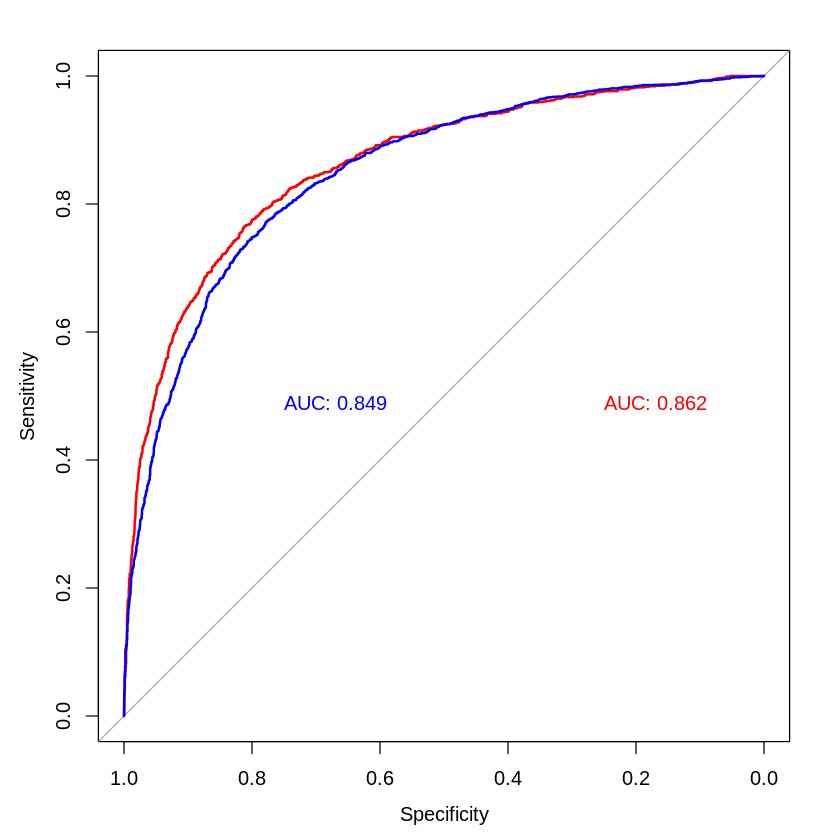

In [46]:
#Start of leave one out hyperparameter tuning.
h1n1_features=MRMR("h1n1_vaccine")
seasonal_features=MRMR("seasonal_vaccine")
best_mean=0
training_matrix=data.matrix(training_set)
test_matrix=data.matrix(test_set_norm)
for (nbr_features in c(5,10,19,25,35)){
    for (size_neurons in c(10,20,30)){
        for(decay_rate in c(0.5,0.1,0.01,0.001)){
            #Define train and test sample from training sample.
            training_label.samples <- training_label$respondent_id%>%createDataPartition(p = 0.8, list = FALSE)  
            train_h1n1.data = training_matrix[training_label.samples,h1n1_features[1:nbr_features]]
            test_h1n1.data = training_matrix[-training_label.samples, h1n1_features[1:nbr_features]]
            train_seasonal.data = training_matrix[training_label.samples,seasonal_features[1:nbr_features]]
            test_seasonal.data = training_matrix[-training_label.samples, seasonal_features[1:nbr_features]]
            test_label_frame=training_label[-training_label.samples,]
            training_label_frame=training_label[training_label.samples,]
            # Build the model proba.
            mynet_h1n1<-nnet(x=train_h1n1.data,y=training_label_frame$h1n1_vaccine, size=size_neurons,decay=decay_rate, maxit=100,MaxNWts=2000)
            ypred_h1n1 <- predict (mynet_h1n1, test_h1n1.data)
            mynet_seasonal<-nnet(x=train_seasonal.data,y=training_label_frame$seasonal_vaccine, size=size_neurons,decay=decay_rate, maxit=100,MaxNWts=2000)
            ypred_seasonal <- predict (mynet_seasonal, test_seasonal.data)
            #Compute the AUC-ROC curve.
            roc_h1n1=roc(test_label_frame$h1n1_vaccine, ypred_h1n1,auc=TRUE)
            roc_seasonal=roc(test_label_frame$seasonal_vaccine, ypred_seasonal,auc=TRUE)
            actual_mean=mean(mean(c(auc(roc_h1n1),auc(roc_seasonal))))
            print(unlist(list('AUC-ROC curves for' , nbr_features,'nbre features',size_neurons,'neurons and decay rate of',decay_rate,'is',actual_mean)))
            if (actual_mean>best_mean)
                {
                best_mean=actual_mean
                best_roc_h1n1=roc_h1n1
                best_roc_seasonal=roc_seasonal
                f_best=nbr_features
                best_decay_rate=decay_rate
                size_best=size_neurons

                }
            }
        }
    }
#Plot best ROC curve with AUC
print(unlist(list('our best hyperparameter are nbre features=',f_best,'for intermediary neuron size',size_best,'and decay rate',best_decay_rate)))
print('The corresponding ROC curves are :')
plot.roc(best_roc_h1n1,print.auc=TRUE,print.auc.x=0.25, print.auc.y=0.5,col='red')
plot.roc(best_roc_seasonal,add=TRUE,print.auc=TRUE,print.auc.x=0.75, print.auc.y=0.5,col = 'blue)

We see that the best AUC are obtained when feature used are between 25 and 35 the result have a relatively low dependance on the decay_rate. Nevertheless a non zero value is almost mandatory for the NN to get close enough to an interesting (local) minimum for the loss function and the biggest value of 0.5 tend to achieve better precision. Indeed even if it is not shown in this report we tried to train the algorithm without decay rate and the neural network almost always got stuck in trivial classification for the seasonal flu. We also see that the effect of the number of neuron of the hidden layer is hidden by the random nature of the neural network. 

To select the best Number of hidden layer and chose best number of features lets train the neural network a couple of time with the adding of 30 features to see which is the more stable :

# weights:  271
initial  value 5724.789910 
iter  10 value 3192.391427
iter  20 value 2761.415223
iter  30 value 2687.192458
iter  40 value 2595.881972
iter  50 value 2538.656538
iter  60 value 2502.410150
iter  70 value 2478.441248
iter  80 value 2464.960838
iter  90 value 2456.030371
iter 100 value 2451.935414
final  value 2451.935414 
stopped after 100 iterations
# weights:  271
initial  value 5716.945166 
iter  10 value 3829.849484
iter  20 value 3765.946169
iter  30 value 3723.501764
iter  40 value 3693.472840
iter  50 value 3673.701026
iter  60 value 3654.918282
iter  70 value 3645.263909
iter  80 value 3641.450503
iter  90 value 3639.130866
iter 100 value 3637.453354
final  value 3637.453354 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.843432915094781"      
# weights:  271
initial  value 8334.479056 
iter  10 value 3649.241885
iter  20 value 2905.518411
iter  30 value 2725.570188
iter  40 value 2634.829288
iter  50 value 2583.805133
iter  60 value 2537.350147
iter  70 value 2474.846378
iter  80 value 2451.526904
iter  90 value 2442.555510
iter 100 value 2437.459283
final  value 2437.459283 
stopped after 100 iterations
# weights:  271
initial  value 5432.431414 
iter  10 value 3881.513934
iter  20 value 3805.398460
iter  30 value 3755.641810
iter  40 value 3714.459859
iter  50 value 3695.312700
iter  60 value 3686.994380
iter  70 value 3679.497323
iter  80 value 3674.209948
iter  90 value 3668.845899
iter 100 value 3664.839460
final  value 3664.839460 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.841589223090994"      
# weights:  271
initial  value 5229.652851 
iter  10 value 3529.120196
iter  20 value 2930.316073
iter  30 value 2766.780657
iter  40 value 2596.530194
iter  50 value 2511.109483
iter  60 value 2472.034686
iter  70 value 2458.203044
iter  80 value 2449.641463
iter  90 value 2444.496399
iter 100 value 2439.252632
final  value 2439.252632 
stopped after 100 iterations
# weights:  271
initial  value 5917.065774 
iter  10 value 3897.369202
iter  20 value 3778.544955
iter  30 value 3729.191883
iter  40 value 3695.993980
iter  50 value 3674.098339
iter  60 value 3664.463295
iter  70 value 3657.144425
iter  80 value 3649.734066
iter  90 value 3643.830547
iter 100 value 3639.333583
final  value 3639.333583 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.840378323132953"      
# weights:  541
initial  value 15082.462923 
iter  10 value 3839.919511
iter  20 value 2858.808353
iter  30 value 2763.456712
iter  40 value 2687.587518
iter  50 value 2594.219123
iter  60 value 2542.894114
iter  70 value 2515.226439
iter  80 value 2483.190722
iter  90 value 2461.555617
iter 100 value 2451.849051
final  value 2451.849051 
stopped after 100 iterations
# weights:  541
initial  value 7743.998101 
iter  10 value 3821.742166
iter  20 value 3736.939467
iter  30 value 3699.865321
iter  40 value 3680.977552
iter  50 value 3669.418833
iter  60 value 3659.365232
iter  70 value 3652.740993
iter  80 value 3649.253553
iter  90 value 3646.891052
iter 100 value 3645.071409
final  value 3645.071409 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.84051876959224"       
# weights:  541
initial  value 12205.292130 
iter  10 value 4440.528309
iter  20 value 2886.891024
iter  30 value 2707.770874
iter  40 value 2625.164731
iter  50 value 2569.270866
iter  60 value 2539.603329
iter  70 value 2524.903357
iter  80 value 2506.513112
iter  90 value 2495.032309
iter 100 value 2487.127463
final  value 2487.127463 
stopped after 100 iterations
# weights:  541
initial  value 5201.787355 
iter  10 value 3885.271517
iter  20 value 3792.087291
iter  30 value 3741.001059
iter  40 value 3710.011744
iter  50 value 3686.343631
iter  60 value 3674.168413
iter  70 value 3659.667850
iter  80 value 3650.826051
iter  90 value 3642.219805
iter 100 value 3637.965624
final  value 3637.965624 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.849900024073406"      
# weights:  541
initial  value 5338.027805 
iter  10 value 2838.247841
iter  20 value 2663.820456
iter  30 value 2619.318531
iter  40 value 2565.650335
iter  50 value 2522.626147
iter  60 value 2496.704308
iter  70 value 2468.757281
iter  80 value 2454.880544
iter  90 value 2447.705318
iter 100 value 2443.308909
final  value 2443.308909 
stopped after 100 iterations
# weights:  541
initial  value 5544.649915 
iter  10 value 3885.803761
iter  20 value 3776.701586
iter  30 value 3736.771636
iter  40 value 3709.330767
iter  50 value 3688.203253
iter  60 value 3674.559911
iter  70 value 3659.082433
iter  80 value 3651.201100
iter  90 value 3647.313150
iter 100 value 3645.160651
final  value 3645.160651 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.848242049404993"      
# weights:  811
initial  value 4113.588512 
iter  10 value 2724.829764
iter  20 value 2586.603067
iter  30 value 2530.857722
iter  40 value 2505.189771
iter  50 value 2485.590894
iter  60 value 2475.666370
iter  70 value 2469.666873
iter  80 value 2465.815522
iter  90 value 2463.968344
iter 100 value 2463.032600
final  value 2463.032600 
stopped after 100 iterations
# weights:  811
initial  value 8056.758952 
iter  10 value 3886.746394
iter  20 value 3764.179381
iter  30 value 3719.766305
iter  40 value 3691.335313
iter  50 value 3673.632706
iter  60 value 3663.148309
iter  70 value 3655.925909
iter  80 value 3649.148723
iter  90 value 3643.438727
iter 100 value 3638.809937
final  value 3638.809937 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.826688084609963"      
# weights:  811
initial  value 4424.262958 
iter  10 value 2867.992245
iter  20 value 2706.123126
iter  30 value 2632.057987
iter  40 value 2575.831195
iter  50 value 2530.873118
iter  60 value 2504.957098
iter  70 value 2488.634267
iter  80 value 2474.920581
iter  90 value 2468.237491
iter 100 value 2464.052058
final  value 2464.052058 
stopped after 100 iterations
# weights:  811
initial  value 5833.218114 
iter  10 value 3835.833996
iter  20 value 3754.590080
iter  30 value 3708.730910
iter  40 value 3680.760354
iter  50 value 3664.744299
iter  60 value 3653.616069
iter  70 value 3642.274325
iter  80 value 3636.232157
iter  90 value 3629.126331
iter 100 value 3624.157211
final  value 3624.157211 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.844597702649192"      
# weights:  811
initial  value 5293.622498 
iter  10 value 3461.180515
iter  20 value 2632.029147
iter  30 value 2577.061984
iter  40 value 2533.785599
iter  50 value 2495.978436
iter  60 value 2472.965172
iter  70 value 2459.869784
iter  80 value 2450.820142
iter  90 value 2442.508454
iter 100 value 2437.176508
final  value 2437.176508 
stopped after 100 iterations
# weights:  811
initial  value 7296.558855 
iter  10 value 3970.986919
iter  20 value 3811.142276
iter  30 value 3755.259913
iter  40 value 3716.182503
iter  50 value 3692.311114
iter  60 value 3675.340158
iter  70 value 3657.405940
iter  80 value 3644.751642
iter  90 value 3631.586091
iter 100 value 3625.197705
final  value 3625.197705 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "25"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.843265062774968"      
# weights:  321
initial  value 8111.791866 
iter  10 value 3861.615902
iter  20 value 3011.281439
iter  30 value 2736.376697
iter  40 value 2604.626693
iter  50 value 2542.453174
iter  60 value 2518.140428
iter  70 value 2501.933869
iter  80 value 2485.846359
iter  90 value 2473.921078
iter 100 value 2461.846059
final  value 2461.846059 
stopped after 100 iterations
# weights:  321
initial  value 6026.621997 
iter  10 value 4015.219313
iter  20 value 3874.016074
iter  30 value 3778.828050
iter  40 value 3636.499941
iter  50 value 3563.097351
iter  60 value 3539.200980
iter  70 value 3528.734429
iter  80 value 3522.180098
iter  90 value 3517.223548
iter 100 value 3514.745862
final  value 3514.745862 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.847184769525195"      
# weights:  321
initial  value 3945.800007 
iter  10 value 2814.255708
iter  20 value 2618.243083
iter  30 value 2555.832045
iter  40 value 2523.751636
iter  50 value 2502.181325
iter  60 value 2489.509207
iter  70 value 2479.179180
iter  80 value 2474.120468
iter  90 value 2469.404984
iter 100 value 2466.607516
final  value 2466.607516 
stopped after 100 iterations
# weights:  321
initial  value 5217.946803 
iter  10 value 3766.912739
iter  20 value 3642.454247
iter  30 value 3599.006528
iter  40 value 3573.671607
iter  50 value 3554.112750
iter  60 value 3533.324346
iter  70 value 3521.461351
iter  80 value 3513.550049
iter  90 value 3507.133429
iter 100 value 3501.712795
final  value 3501.712795 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.83099634542835"       
# weights:  321
initial  value 4162.419575 
iter  10 value 2701.592852
iter  20 value 2603.499430
iter  30 value 2569.825147
iter  40 value 2507.215423
iter  50 value 2475.812414
iter  60 value 2454.365810
iter  70 value 2443.953341
iter  80 value 2435.317143
iter  90 value 2429.031279
iter 100 value 2425.548609
final  value 2425.548609 
stopped after 100 iterations
# weights:  321
initial  value 7791.208832 
iter  10 value 3876.982994
iter  20 value 3684.839527
iter  30 value 3617.233038
iter  40 value 3586.169379
iter  50 value 3570.131049
iter  60 value 3562.408306
iter  70 value 3558.933151
iter  80 value 3547.515296
iter  90 value 3532.308066
iter 100 value 3520.021498
final  value 3520.021498 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.847223521052759"      
# weights:  641
initial  value 5845.392113 
iter  10 value 3312.502369
iter  20 value 2838.833222
iter  30 value 2711.277126
iter  40 value 2585.055878
iter  50 value 2533.889381
iter  60 value 2510.393134
iter  70 value 2492.210593
iter  80 value 2480.576386
iter  90 value 2469.573015
iter 100 value 2460.015772
final  value 2460.015772 
stopped after 100 iterations
# weights:  641
initial  value 7921.238407 
iter  10 value 3804.945124
iter  20 value 3654.676864
iter  30 value 3605.408749
iter  40 value 3576.870462
iter  50 value 3555.093285
iter  60 value 3537.226500
iter  70 value 3526.273376
iter  80 value 3517.212312
iter  90 value 3509.008207
iter 100 value 3504.444851
final  value 3504.444851 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.850835314279826"      
# weights:  641
initial  value 5818.265144 
iter  10 value 2967.532489
iter  20 value 2592.709316
iter  30 value 2563.338201
iter  40 value 2536.706871
iter  50 value 2504.590929
iter  60 value 2474.485637
iter  70 value 2458.408711
iter  80 value 2450.109459
iter  90 value 2442.670469
iter 100 value 2435.966307
final  value 2435.966307 
stopped after 100 iterations
# weights:  641
initial  value 5698.732649 
iter  10 value 3694.164701
iter  20 value 3625.753534
iter  30 value 3574.505452
iter  40 value 3550.962245
iter  50 value 3536.793316
iter  60 value 3528.725458
iter  70 value 3517.254187
iter  80 value 3509.092079
iter  90 value 3503.920910
iter 100 value 3499.924514
final  value 3499.924514 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.852432927372626"      
# weights:  641
initial  value 7595.785030 
iter  10 value 3434.408070
iter  20 value 2695.076049
iter  30 value 2614.759338
iter  40 value 2543.521068
iter  50 value 2509.906452
iter  60 value 2474.162755
iter  70 value 2449.653574
iter  80 value 2430.589079
iter  90 value 2415.370277
iter 100 value 2408.800093
final  value 2408.800093 
stopped after 100 iterations
# weights:  641
initial  value 5093.949817 
iter  10 value 3700.020838
iter  20 value 3598.349159
iter  30 value 3541.098879
iter  40 value 3521.007219
iter  50 value 3509.620678
iter  60 value 3500.681498
iter  70 value 3495.505110
iter  80 value 3492.678384
iter  90 value 3490.410563
iter 100 value 3488.341064
final  value 3488.341064 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.845388577711982"      
# weights:  961
initial  value 7537.297707 
iter  10 value 3652.002763
iter  20 value 2589.207162
iter  30 value 2540.741975
iter  40 value 2509.809903
iter  50 value 2475.684182
iter  60 value 2446.536851
iter  70 value 2432.183261
iter  80 value 2422.940866
iter  90 value 2413.316894
iter 100 value 2403.891340
final  value 2403.891340 
stopped after 100 iterations
# weights:  961
initial  value 8838.051934 
iter  10 value 6353.398611
iter  20 value 5037.761539
iter  30 value 3707.416877
iter  40 value 3598.703771
iter  50 value 3563.884315
iter  60 value 3543.424148
iter  70 value 3527.577517
iter  80 value 3516.051870
iter  90 value 3508.748400
iter 100 value 3502.338530
final  value 3502.338530 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.842784638400004"      
# weights:  961
initial  value 4134.396179 
iter  10 value 2722.895369
iter  20 value 2617.456723
iter  30 value 2562.896916
iter  40 value 2520.799851
iter  50 value 2490.195652
iter  60 value 2475.645576
iter  70 value 2456.591987
iter  80 value 2446.063185
iter  90 value 2436.635214
iter 100 value 2426.734738
final  value 2426.734738 
stopped after 100 iterations
# weights:  961
initial  value 6050.567605 
iter  10 value 3712.325567
iter  20 value 3627.179493
iter  30 value 3585.762162
iter  40 value 3561.294632
iter  50 value 3546.259548
iter  60 value 3536.888055
iter  70 value 3529.946336
iter  80 value 3522.203389
iter  90 value 3518.452616
iter 100 value 3515.669892
final  value 3515.669892 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.852932890980284"      
# weights:  961
initial  value 14468.941946 
iter  10 value 3660.998264
iter  20 value 3000.729553
iter  30 value 2804.002859
iter  40 value 2616.283513
iter  50 value 2561.394497
iter  60 value 2519.473215
iter  70 value 2495.330567
iter  80 value 2476.600144
iter  90 value 2463.780831
iter 100 value 2453.789687
final  value 2453.789687 
stopped after 100 iterations
# weights:  961
initial  value 6249.052031 
iter  10 value 3745.051291
iter  20 value 3641.488118
iter  30 value 3582.769187
iter  40 value 3559.357480
iter  50 value 3542.536552
iter  60 value 3529.049250
iter  70 value 3518.966953
iter  80 value 3507.723097
iter  90 value 3498.277703
iter 100 value 3493.158592
final  value 3493.158592 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "30"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.848625417326111"      
# weights:  371
initial  value 8143.354649 
iter  10 value 4006.862059
iter  20 value 2965.741259
iter  30 value 2719.577155
iter  40 value 2629.805064
iter  50 value 2583.456797
iter  60 value 2566.341557
iter  70 value 2525.712239
iter  80 value 2502.301199
iter  90 value 2480.757923
iter 100 value 2465.584052
final  value 2465.584052 
stopped after 100 iterations
# weights:  371
initial  value 6123.171113 
iter  10 value 3844.827006
iter  20 value 3615.492184
iter  30 value 3558.726909
iter  40 value 3483.817487
iter  50 value 3414.020561
iter  60 value 3380.898475
iter  70 value 3369.574128
iter  80 value 3361.852237
iter  90 value 3350.940509
iter 100 value 3340.126573
final  value 3340.126573 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.858615672892678"      
# weights:  371
initial  value 4159.385456 
iter  10 value 2824.801835
iter  20 value 2679.668167
iter  30 value 2634.464085
iter  40 value 2530.162345
iter  50 value 2473.788609
iter  60 value 2453.984021
iter  70 value 2441.851936
iter  80 value 2430.399505
iter  90 value 2422.173409
iter 100 value 2412.804293
final  value 2412.804293 
stopped after 100 iterations
# weights:  371
initial  value 5646.021444 
iter  10 value 3502.263952
iter  20 value 3390.084351
iter  30 value 3358.911969
iter  40 value 3337.469801
iter  50 value 3321.044977
iter  60 value 3312.039430
iter  70 value 3305.014377
iter  80 value 3300.981195
iter  90 value 3296.592510
iter 100 value 3290.736076
final  value 3290.736076 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.846464021444519"      
# weights:  371
initial  value 7190.708073 
iter  10 value 3530.619582
iter  20 value 2833.184014
iter  30 value 2645.799799
iter  40 value 2577.974259
iter  50 value 2516.709862
iter  60 value 2484.686093
iter  70 value 2463.173223
iter  80 value 2447.775753
iter  90 value 2435.308690
iter 100 value 2428.271059
final  value 2428.271059 
stopped after 100 iterations
# weights:  371
initial  value 5460.566563 
iter  10 value 3589.740956
iter  20 value 3457.723742
iter  30 value 3411.024975
iter  40 value 3383.991112
iter  50 value 3370.106473
iter  60 value 3360.312938
iter  70 value 3352.237490
iter  80 value 3343.401103
iter  90 value 3333.017322
iter 100 value 3324.689832
final  value 3324.689832 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "10"                     
[5] "neurons is"              "0.855689358962926"      
# weights:  741
initial  value 8125.499249 
iter  10 value 2906.633861
iter  20 value 2614.125891
iter  30 value 2572.564120
iter  40 value 2526.761495
iter  50 value 2498.796485
iter  60 value 2482.417705
iter  70 value 2475.850722
iter  80 value 2470.330790
iter  90 value 2461.224916
iter 100 value 2456.216701
final  value 2456.216701 
stopped after 100 iterations
# weights:  741
initial  value 7643.936302 
iter  10 value 3573.585301
iter  20 value 3448.720150
iter  30 value 3401.777175
iter  40 value 3368.007854
iter  50 value 3347.369873
iter  60 value 3335.158041
iter  70 value 3324.208759
iter  80 value 3315.778552
iter  90 value 3308.298127
iter 100 value 3302.489669
final  value 3302.489669 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.842952643929644"      
# weights:  741
initial  value 4081.693656 
iter  10 value 2693.082524
iter  20 value 2598.550373
iter  30 value 2558.601867
iter  40 value 2526.743932
iter  50 value 2494.940573
iter  60 value 2471.878237
iter  70 value 2449.604651
iter  80 value 2434.682969
iter  90 value 2424.861041
iter 100 value 2410.736750
final  value 2410.736750 
stopped after 100 iterations
# weights:  741
initial  value 5587.167162 
iter  10 value 3541.473217
iter  20 value 3398.633818
iter  30 value 3353.960032
iter  40 value 3331.487581
iter  50 value 3320.427980
iter  60 value 3303.592334
iter  70 value 3296.755170
iter  80 value 3285.287725
iter  90 value 3278.669447
iter 100 value 3273.915679
final  value 3273.915679 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.850478706880653"      
# weights:  741
initial  value 5419.529228 
iter  10 value 3270.183349
iter  20 value 2600.445088
iter  30 value 2550.430211
iter  40 value 2516.805836
iter  50 value 2483.548651
iter  60 value 2465.029875
iter  70 value 2454.760670
iter  80 value 2442.385072
iter  90 value 2433.748549
iter 100 value 2422.301798
final  value 2422.301798 
stopped after 100 iterations
# weights:  741
initial  value 7198.982850 
iter  10 value 3523.706619
iter  20 value 3420.132072
iter  30 value 3364.133485
iter  40 value 3341.832908
iter  50 value 3330.457698
iter  60 value 3320.461052
iter  70 value 3306.989796
iter  80 value 3299.790199
iter  90 value 3291.710165
iter 100 value 3286.541101
final  value 3286.541101 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "20"                     
[5] "neurons is"              "0.848840275150607"      
# weights:  1111
initial  value 8594.641723 
iter  10 value 3329.679679
iter  20 value 2627.476086
iter  30 value 2579.162623
iter  40 value 2533.805586
iter  50 value 2492.718938
iter  60 value 2458.920327
iter  70 value 2443.904204
iter  80 value 2431.859864
iter  90 value 2422.607874
iter 100 value 2414.388116
final  value 2414.388116 
stopped after 100 iterations
# weights:  1111
initial  value 7713.346398 
iter  10 value 3716.157702
iter  20 value 3546.918863
iter  30 value 3459.931589
iter  40 value 3410.559843
iter  50 value 3378.538680
iter  60 value 3350.732064
iter  70 value 3329.422142
iter  80 value 3313.052050
iter  90 value 3298.054842
iter 100 value 3285.395574
final  value 3285.395574 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.848528900504305"      
# weights:  1111
initial  value 6024.286122 
iter  10 value 3345.759667
iter  20 value 2740.684944
iter  30 value 2632.343648
iter  40 value 2583.543225
iter  50 value 2553.092978
iter  60 value 2517.572624
iter  70 value 2492.345398
iter  80 value 2474.543259
iter  90 value 2459.932032
iter 100 value 2441.339318
final  value 2441.339318 
stopped after 100 iterations
# weights:  1111
initial  value 5851.511580 
iter  10 value 3609.182861
iter  20 value 3457.480549
iter  30 value 3402.184131
iter  40 value 3370.809776
iter  50 value 3346.921283
iter  60 value 3334.991093
iter  70 value 3324.578922
iter  80 value 3316.373094
iter  90 value 3309.796252
iter 100 value 3305.689512
final  value 3305.689512 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.852218595504311"      
# weights:  1111
initial  value 3777.956402 
iter  10 value 2716.319393
iter  20 value 2620.857668
iter  30 value 2542.927401
iter  40 value 2495.234025
iter  50 value 2463.915973
iter  60 value 2439.806151
iter  70 value 2427.613097
iter  80 value 2419.828608
iter  90 value 2412.008082
iter 100 value 2402.950774
final  value 2402.950774 
stopped after 100 iterations
# weights:  1111
initial  value 5210.954532 
iter  10 value 3626.870802
iter  20 value 3462.663902
iter  30 value 3400.612700
iter  40 value 3372.903190
iter  50 value 3348.781561
iter  60 value 3332.780882
iter  70 value 3322.605624
iter  80 value 3315.857632
iter  90 value 3306.676154
iter 100 value 3299.621014
final  value 3299.621014 
stopped after 100 iterations


Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$h1n1_vaccine, ypred_h1n1, auc = TRUE):
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases

Setting levels: control = 0, case = 1

Warning message in roc.default(test_label_frame$seasonal_vaccine, ypred_seasonal, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



[1] "mean AUC-ROC curves for" "35"                     
[3] "nbre features"           "30"                     
[5] "neurons is"              "0.854117532079931"      
[1] "our best hyperparameter are nbre features="
[2] "35"                                        
[3] "for intermediary neuron size"              
[4] "10"                                        
[1] "The corresponding ROC curves are :"


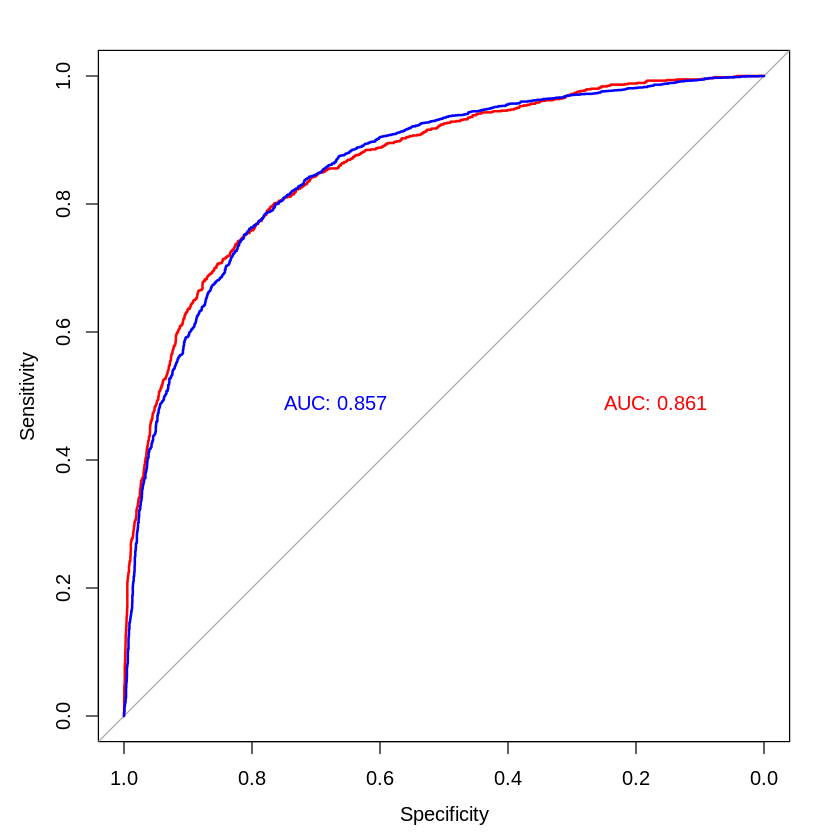

In [38]:
best_mean=0
decay_rate=0.5
for (nbr_features in c(25,30,35)){
    for (size_neurons in c(10,20,30)){
        for (i in c(1,2,3)){
            #Define train and test sample from training sample.
            training_label.samples <- training_label$respondent_id%>%createDataPartition(p = 0.8, list = FALSE)  
            train_h1n1.data = training_matrix[training_label.samples,h1n1_features[1:nbr_features]]
            test_h1n1.data = training_matrix[-training_label.samples, h1n1_features[1:nbr_features]]
            train_seasonal.data = training_matrix[training_label.samples,seasonal_features[1:nbr_features]]
            test_seasonal.data = training_matrix[-training_label.samples, seasonal_features[1:nbr_features]]
            test_label_frame=training_label[-training_label.samples,]
            training_label_frame=training_label[training_label.samples,]
            # Build the model proba.
            mynet_h1n1<-nnet(x=train_h1n1.data,y=training_label_frame$h1n1_vaccine, size=size_neurons,decay=decay_rate, maxit=100,MaxNWts=2000)
            ypred_h1n1 <- predict (mynet_h1n1, test_h1n1.data)
            mynet_seasonal<-nnet(x=train_seasonal.data,y=training_label_frame$seasonal_vaccine, size=size_neurons,decay=decay_rate, maxit=100,MaxNWts=2000)
            ypred_seasonal <- predict (mynet_seasonal, test_seasonal.data)
            #Compute the AUC-ROC curve.
            roc_h1n1=roc(test_label_frame$h1n1_vaccine, ypred_h1n1,auc=TRUE)
            roc_seasonal=roc(test_label_frame$seasonal_vaccine, ypred_seasonal,auc=TRUE)
            actual_mean=mean(mean(c(auc(roc_h1n1),auc(roc_seasonal))))
            print(unlist(list('mean AUC-ROC curves for' , nbr_features,'features and',size_neurons,'neurons is',actual_mean)))
            if (actual_mean>best_mean)
                {
                best_mean=actual_mean
                best_roc_h1n1=roc_h1n1
                best_roc_seasonal=roc_seasonal
                f_best=nbr_features
                best_decay_rate=decay_rate
                size_best=size_neurons

                }
            }
        }
    }
#Plot best ROC curve with AUC
print(unlist(list('our best hyperparameter are nbre features=',f_best,'for intermediary neuron size',size_best)))
print('The corresponding ROC curves are :')
plot.roc(best_roc_h1n1,print.auc=TRUE,print.auc.x=0.25, print.auc.y=0.5,col='red')
plot.roc(best_roc_seasonal,add=TRUE,print.auc=TRUE,print.auc.x=0.75, print.auc.y=0.5,col = 'blue')

We see that our best model use the 35 features but we now get the best result for 10 neurons. Nevertheless the mean AUC seems more stable with 30 neurons. Lets then stick to 
$$decay\_rate=0.5$$
$$n_{feature}=all$$
$$n_{neurons}=30$$
Lets then make one run on the real test and keep it in memory for eventual submission.

# weights:  1201
initial  value 5249.458703 
iter  10 value 4494.398786
iter  20 value 4480.740229
iter  30 value 4384.077967
iter  40 value 2997.645990
iter  50 value 570.240285
iter  60 value 221.218723
iter  70 value 81.786936
iter  80 value 76.409109
iter  90 value 63.896649
iter 100 value 63.424737
final  value 63.424737 
stopped after 100 iterations
# weights:  1201
initial  value 9627.283094 
iter  10 value 7520.038575
iter  20 value 6888.938861
iter  30 value 6736.000291
iter  40 value 6669.706003
iter  50 value 635.505001
iter  60 value 239.176405
iter  70 value 95.385363
iter  80 value 82.609592
iter  90 value 76.391245
iter 100 value 64.937415
final  value 64.937415 
stopped after 100 iterations


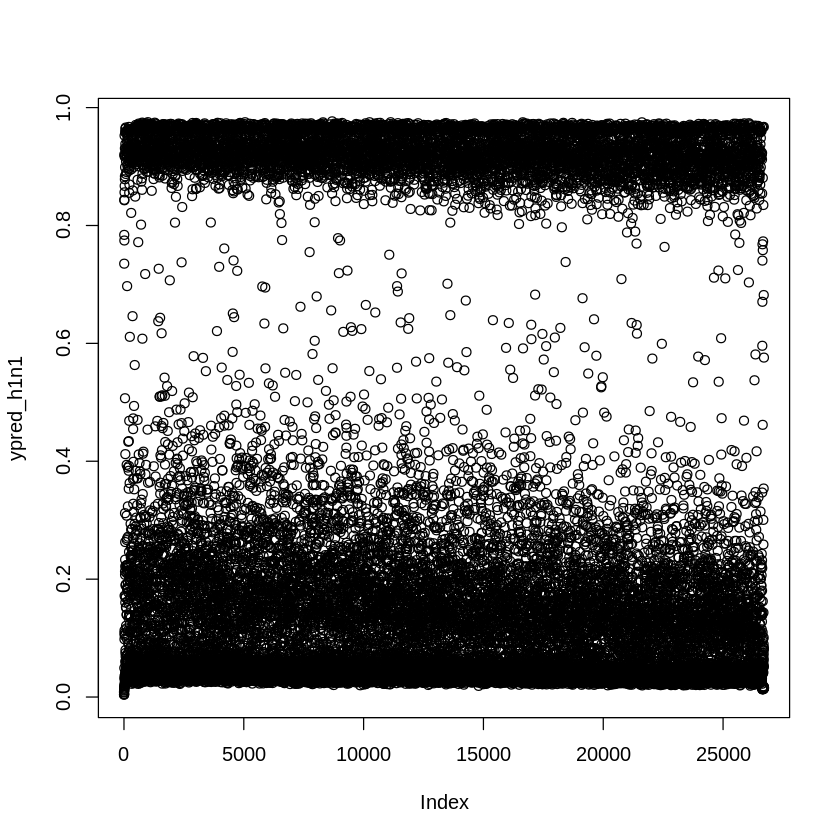

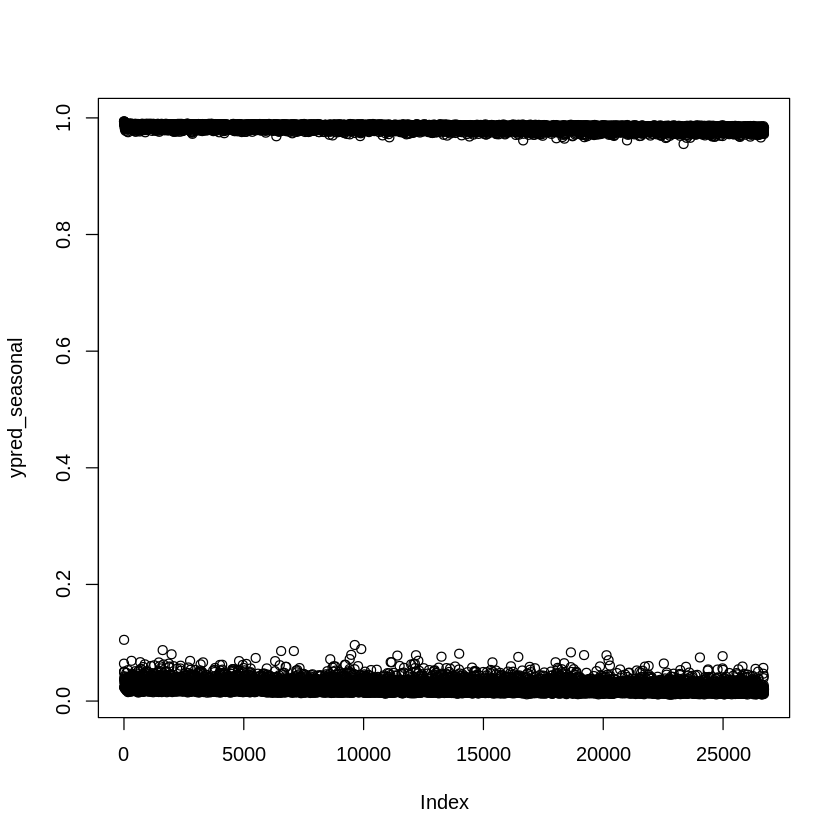

In [58]:
test_matrix=data.matrix(test_set_norm)

mynet_h1n1<-nnet(x=training_matrix,y=label_h1n1, size=30,
                 decay=0.5, maxit=100,MaxNWts=2000)
ypred_h1n1 <- predict (mynet_h1n1, test_matrix)
mynet_seasonal<-nnet(x=training_matrix,y=label_seasonal, size=size_neurons,
                     decay=decay_rate, maxit=100,MaxNWts=2000)
ypred_seasonal <- predict (mynet_seasonal, test_matrix)
plot(ypred_h1n1)
plot(ypred_seasonal)

In [65]:
full_matrix=do.call("cbind", list(test_set$respondent_id, ypred_h1n1,ypred_seasonal))
return_frame=tibble('respondent_id'=full_matrix[,1],'h1n1_vaccine'=full_matrix[,2],'seasonal_vaccine'=full_matrix[,3])
write.csv(return_frame,'nnet_best', row.names = FALSE)

# Alternative models

Since we did not use any gradient boosting technique this section was a good opportunity to make a try with the xgboost library.

Lets directly start with leave one out hyperparameter tuning :

[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.689227 
[1]	train-logloss:0.691782 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.675464780409401" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.689232 
[2]	train-logloss:0.685395 
[1]	train-logloss:0.691825 
[2]	train-logloss:0.690528 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.678515869078508" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.689265 
[2]	train-logloss:0.685459 
[3]	train-logloss:0.681729 
[4]	train-logloss:0.678072 
[5]	train-logloss:0.674486 
[1]	train-logloss:0.691758 
[2]	train-logloss:0.690397 
[3]	train-logloss:0.689062 
[4]	train-logloss:0.687754 
[5]	train-logloss:0.686472 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.672045991497002" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.689214 
[2]	train-logloss:0.685359 
[3]	train-logloss:0.681580 
[4]	train-logloss:0.677876 
[5]	train-logloss:0.674243 
[6]	train-logloss:0.670682 
[7]	train-logloss:0.667189 
[8]	train-logloss:0.663764 
[9]	train-logloss:0.660405 
[10]	train-logloss:0.657110 
[1]	train-logloss:0.691790 
[2]	train-logloss:0.690460 
[3]	train-logloss:0.689156 
[4]	train-logloss:0.687878 
[5]	train-logloss:0.686625 
[6]	train-logloss:0.685397 
[7]	train-logloss:0.684193 
[8]	train-logloss:0.683013 
[9]	train-logloss:0.681857 
[10]	train-logloss:0.680723 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.680404253454344" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.655301 
[1]	train-logloss:0.679988 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.671443768175314" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.655521 
[2]	train-logloss:0.624867 
[1]	train-logloss:0.680015 
[2]	train-logloss:0.669360 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.673369044470649" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.656125 
[2]	train-logloss:0.625964 
[3]	train-logloss:0.600835 
[4]	train-logloss:0.579794 
[5]	train-logloss:0.561740 
[1]	train-logloss:0.680233 
[2]	train-logloss:0.669756 
[3]	train-logloss:0.661236 
[4]	train-logloss:0.654294 
[5]	train-logloss:0.648616 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.732388147458803" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.655860 
[2]	train-logloss:0.625255 
[3]	train-logloss:0.599626 
[4]	train-logloss:0.578279 
[5]	train-logloss:0.560125 
[6]	train-logloss:0.544437 
[7]	train-logloss:0.531162 
[8]	train-logloss:0.519604 
[9]	train-logloss:0.509353 
[10]	train-logloss:0.500696 
[1]	train-logloss:0.680243 
[2]	train-logloss:0.669774 
[3]	train-logloss:0.661260 
[4]	train-logloss:0.654324 
[5]	train-logloss:0.648639 
[6]	train-logloss:0.643974 
[7]	train-logloss:0.640058 
[8]	train-logloss:0.636554 
[9]	train-logloss:0.633596 
[10]	train-logloss:0.630973 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.733779069002819" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.591864 
[1]	train-logloss:0.659127 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.679465725946556" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.592246 
[2]	train-logloss:0.536243 
[1]	train-logloss:0.659527 
[2]	train-logloss:0.642781 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.701001373020391" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.593638 
[2]	train-logloss:0.537378 
[3]	train-logloss:0.503132 
[4]	train-logloss:0.481223 
[5]	train-logloss:0.466579 
[1]	train-logloss:0.657728 
[2]	train-logloss:0.640070 
[3]	train-logloss:0.629985 
[4]	train-logloss:0.623054 
[5]	train-logloss:0.618313 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.754949687680593" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.591626 
[2]	train-logloss:0.535901 
[3]	train-logloss:0.501351 
[4]	train-logloss:0.478573 
[5]	train-logloss:0.463910 
[6]	train-logloss:0.452746 
[7]	train-logloss:0.443619 
[8]	train-logloss:0.436758 
[9]	train-logloss:0.431139 
[10]	train-logloss:0.426557 
[1]	train-logloss:0.657772 
[2]	train-logloss:0.639955 
[3]	train-logloss:0.630037 
[4]	train-logloss:0.623136 
[5]	train-logloss:0.618452 
[6]	train-logloss:0.614015 
[7]	train-logloss:0.610106 
[8]	train-logloss:0.606263 
[9]	train-logloss:0.602725 
[10]	train-logloss:0.598833 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.776893325876005" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.544154 
[1]	train-logloss:0.642634 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.680082270118946" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.544838 
[2]	train-logloss:0.488976 
[1]	train-logloss:0.642390 
[2]	train-logloss:0.627195 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.715210860439835" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.545227 
[2]	train-logloss:0.490037 
[3]	train-logloss:0.459801 
[4]	train-logloss:0.445184 
[5]	train-logloss:0.435041 
[1]	train-logloss:0.641264 
[2]	train-logloss:0.625844 
[3]	train-logloss:0.617018 
[4]	train-logloss:0.610142 
[5]	train-logloss:0.603852 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.768718086286448" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.544784 
[2]	train-logloss:0.488924 
[3]	train-logloss:0.458343 
[4]	train-logloss:0.443118 
[5]	train-logloss:0.432814 
[6]	train-logloss:0.424476 
[7]	train-logloss:0.418710 
[8]	train-logloss:0.413525 
[9]	train-logloss:0.409943 
[10]	train-logloss:0.406925 
[1]	train-logloss:0.642282 
[2]	train-logloss:0.627222 
[3]	train-logloss:0.618509 
[4]	train-logloss:0.611476 
[5]	train-logloss:0.605127 
[6]	train-logloss:0.599370 
[7]	train-logloss:0.593999 
[8]	train-logloss:0.588927 
[9]	train-logloss:0.585189 
[10]	train-logloss:0.581977 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.789139514705013" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.488489 
[1]	train-logloss:0.624635 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.67454421716566"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.488598 
[2]	train-logloss:0.450061 
[1]	train-logloss:0.625702 
[2]	train-logloss:0.615409 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.726093092221956" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.488197 
[2]	train-logloss:0.449500 
[3]	train-logloss:0.425287 
[4]	train-logloss:0.413876 
[5]	train-logloss:0.407883 
[1]	train-logloss:0.623597 
[2]	train-logloss:0.614227 
[3]	train-logloss:0.604516 
[4]	train-logloss:0.594635 
[5]	train-logloss:0.587833 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.775367180444771" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.487449 
[2]	train-logloss:0.449345 
[3]	train-logloss:0.425011 
[4]	train-logloss:0.413015 
[5]	train-logloss:0.406774 
[6]	train-logloss:0.402843 
[7]	train-logloss:0.400505 
[8]	train-logloss:0.398649 
[9]	train-logloss:0.397441 
[10]	train-logloss:0.396495 
[1]	train-logloss:0.624700 
[2]	train-logloss:0.614161 
[3]	train-logloss:0.603874 
[4]	train-logloss:0.595309 
[5]	train-logloss:0.587915 
[6]	train-logloss:0.581970 
[7]	train-logloss:0.576865 
[8]	train-logloss:0.573424 
[9]	train-logloss:0.570343 
[10]	train-logloss:0.568389 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.795761134615631" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688667 
[1]	train-logloss:0.691483 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.734996868849257" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688674 
[2]	train-logloss:0.684289 
[1]	train-logloss:0.691529 
[2]	train-logloss:0.689943 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.731379141419777" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688555 
[2]	train-logloss:0.684053 
[3]	train-logloss:0.679640 
[4]	train-logloss:0.675314 
[5]	train-logloss:0.671072 
[1]	train-logloss:0.691513 
[2]	train-logloss:0.689912 
[3]	train-logloss:0.688343 
[4]	train-logloss:0.686804 
[5]	train-logloss:0.685296 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.729127795955758" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688643 
[2]	train-logloss:0.684228 
[3]	train-logloss:0.679900 
[4]	train-logloss:0.675655 
[5]	train-logloss:0.671492 
[6]	train-logloss:0.667409 
[7]	train-logloss:0.663404 
[8]	train-logloss:0.659473 
[9]	train-logloss:0.655618 
[10]	train-logloss:0.651835 
[1]	train-logloss:0.691521 
[2]	train-logloss:0.689928 
[3]	train-logloss:0.688365 
[4]	train-logloss:0.686834 
[5]	train-logloss:0.685333 
[6]	train-logloss:0.683862 
[7]	train-logloss:0.682419 
[8]	train-logloss:0.681004 
[9]	train-logloss:0.679617 
[10]	train-logloss:0.678258 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.752418781857015" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.650370 
[1]	train-logloss:0.677346 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.734878124405895" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.650459 
[2]	train-logloss:0.615578 
[1]	train-logloss:0.676898 
[2]	train-logloss:0.663695 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.743654805206047" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.650353 
[2]	train-logloss:0.615374 
[3]	train-logloss:0.586873 
[4]	train-logloss:0.562417 
[5]	train-logloss:0.542134 
[1]	train-logloss:0.677354 
[2]	train-logloss:0.664521 
[3]	train-logloss:0.653883 
[4]	train-logloss:0.645096 
[5]	train-logloss:0.637643 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.763445265474604" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.649756 
[2]	train-logloss:0.614358 
[3]	train-logloss:0.585322 
[4]	train-logloss:0.561125 
[5]	train-logloss:0.539767 
[6]	train-logloss:0.521885 
[7]	train-logloss:0.506787 
[8]	train-logloss:0.493652 
[9]	train-logloss:0.482433 
[10]	train-logloss:0.472597 
[1]	train-logloss:0.677222 
[2]	train-logloss:0.664281 
[3]	train-logloss:0.653577 
[4]	train-logloss:0.644675 
[5]	train-logloss:0.637188 
[6]	train-logloss:0.630727 
[7]	train-logloss:0.625293 
[8]	train-logloss:0.620574 
[9]	train-logloss:0.616550 
[10]	train-logloss:0.613058 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.764807862607289" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.577830 
[1]	train-logloss:0.650858 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.729379099600893" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.578168 
[2]	train-logloss:0.516462 
[1]	train-logloss:0.651069 
[2]	train-logloss:0.627974 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.756230000320264" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.577282 
[2]	train-logloss:0.515611 
[3]	train-logloss:0.476311 
[4]	train-logloss:0.452988 
[5]	train-logloss:0.436509 
[1]	train-logloss:0.651101 
[2]	train-logloss:0.628426 
[3]	train-logloss:0.614787 
[4]	train-logloss:0.604520 
[5]	train-logloss:0.596679 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.776489481577154" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.578135 
[2]	train-logloss:0.516775 
[3]	train-logloss:0.477634 
[4]	train-logloss:0.454315 
[5]	train-logloss:0.438401 
[6]	train-logloss:0.427701 
[7]	train-logloss:0.419742 
[8]	train-logloss:0.413661 
[9]	train-logloss:0.408727 
[10]	train-logloss:0.405565 
[1]	train-logloss:0.650518 
[2]	train-logloss:0.627796 
[3]	train-logloss:0.614064 
[4]	train-logloss:0.605356 
[5]	train-logloss:0.598035 
[6]	train-logloss:0.590477 
[7]	train-logloss:0.585936 
[8]	train-logloss:0.582180 
[9]	train-logloss:0.578164 
[10]	train-logloss:0.574844 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.799304708958069" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.521406 
[1]	train-logloss:0.630380 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.72383216741385"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.522989 
[2]	train-logloss:0.462518 
[1]	train-logloss:0.630697 
[2]	train-logloss:0.607868 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.754350634512651" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.522137 
[2]	train-logloss:0.461954 
[3]	train-logloss:0.433686 
[4]	train-logloss:0.419144 
[5]	train-logloss:0.410878 
[1]	train-logloss:0.630085 
[2]	train-logloss:0.607724 
[3]	train-logloss:0.595792 
[4]	train-logloss:0.587886 
[5]	train-logloss:0.581847 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.795219084945685" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.522735 
[2]	train-logloss:0.463104 
[3]	train-logloss:0.434950 
[4]	train-logloss:0.420339 
[5]	train-logloss:0.411612 
[6]	train-logloss:0.405050 
[7]	train-logloss:0.401387 
[8]	train-logloss:0.399079 
[9]	train-logloss:0.397005 
[10]	train-logloss:0.395403 
[1]	train-logloss:0.630328 
[2]	train-logloss:0.607672 
[3]	train-logloss:0.595020 
[4]	train-logloss:0.586403 
[5]	train-logloss:0.578290 
[6]	train-logloss:0.573133 
[7]	train-logloss:0.566466 
[8]	train-logloss:0.563627 
[9]	train-logloss:0.561103 
[10]	train-logloss:0.559321 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.802108608935745" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.457028 
[1]	train-logloss:0.608110 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.728383975683304" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.455865 
[2]	train-logloss:0.422020 
[1]	train-logloss:0.609390 
[2]	train-logloss:0.591036 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.762141059819482" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.456784 
[2]	train-logloss:0.423727 
[3]	train-logloss:0.412328 
[4]	train-logloss:0.402505 
[5]	train-logloss:0.397610 
[1]	train-logloss:0.606789 
[2]	train-logloss:0.589100 
[3]	train-logloss:0.575882 
[4]	train-logloss:0.567413 
[5]	train-logloss:0.562903 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.790231391921888" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.455475 
[2]	train-logloss:0.421467 
[3]	train-logloss:0.410176 
[4]	train-logloss:0.403507 
[5]	train-logloss:0.397720 
[6]	train-logloss:0.394649 
[7]	train-logloss:0.392625 
[8]	train-logloss:0.391351 
[9]	train-logloss:0.390014 
[10]	train-logloss:0.388009 
[1]	train-logloss:0.607582 
[2]	train-logloss:0.590586 
[3]	train-logloss:0.577285 
[4]	train-logloss:0.569608 
[5]	train-logloss:0.564925 
[6]	train-logloss:0.561648 
[7]	train-logloss:0.559013 
[8]	train-logloss:0.557403 
[9]	train-logloss:0.555763 
[10]	train-logloss:0.554373 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.799256242955766" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688344 
[1]	train-logloss:0.691219 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.760892101492173" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688355 
[2]	train-logloss:0.683657 
[1]	train-logloss:0.691212 
[2]	train-logloss:0.689316 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.75032043840293"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688365 
[2]	train-logloss:0.683679 
[3]	train-logloss:0.679084 
[4]	train-logloss:0.674579 
[5]	train-logloss:0.670162 
[1]	train-logloss:0.691198 
[2]	train-logloss:0.689287 
[3]	train-logloss:0.687414 
[4]	train-logloss:0.685578 
[5]	train-logloss:0.683778 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.758563859641531" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688399 
[2]	train-logloss:0.683744 
[3]	train-logloss:0.679182 
[4]	train-logloss:0.674708 
[5]	train-logloss:0.670322 
[6]	train-logloss:0.666020 
[7]	train-logloss:0.661801 
[8]	train-logloss:0.657663 
[9]	train-logloss:0.653603 
[10]	train-logloss:0.649620 
[1]	train-logloss:0.691186 
[2]	train-logloss:0.689264 
[3]	train-logloss:0.687379 
[4]	train-logloss:0.685532 
[5]	train-logloss:0.683722 
[6]	train-logloss:0.681946 
[7]	train-logloss:0.680206 
[8]	train-logloss:0.678499 
[9]	train-logloss:0.676825 
[10]	train-logloss:0.675184 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.760738918305569" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.647665 
[1]	train-logloss:0.674938 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.762353571852363" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.647309 
[2]	train-logloss:0.609915 
[1]	train-logloss:0.674811 
[2]	train-logloss:0.659891 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.760942101704414" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.648057 
[2]	train-logloss:0.611276 
[3]	train-logloss:0.580867 
[4]	train-logloss:0.555517 
[5]	train-logloss:0.534264 
[1]	train-logloss:0.675000 
[2]	train-logloss:0.660221 
[3]	train-logloss:0.648117 
[4]	train-logloss:0.638075 
[5]	train-logloss:0.628733 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.788792652564129" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.647424 
[2]	train-logloss:0.610125 
[3]	train-logloss:0.579354 
[4]	train-logloss:0.553724 
[5]	train-logloss:0.532234 
[6]	train-logloss:0.513997 
[7]	train-logloss:0.498123 
[8]	train-logloss:0.484866 
[9]	train-logloss:0.473399 
[10]	train-logloss:0.463599 
[1]	train-logloss:0.675114 
[2]	train-logloss:0.660434 
[3]	train-logloss:0.648398 
[4]	train-logloss:0.638364 
[5]	train-logloss:0.629250 
[6]	train-logloss:0.621809 
[7]	train-logloss:0.615355 
[8]	train-logloss:0.609928 
[9]	train-logloss:0.605205 
[10]	train-logloss:0.600972 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.790909525216852" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.570050 
[1]	train-logloss:0.644213 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.76112401808309"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.570417 
[2]	train-logloss:0.505772 
[1]	train-logloss:0.642975 
[2]	train-logloss:0.615470 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.769001015805495" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.571056 
[2]	train-logloss:0.506073 
[3]	train-logloss:0.468085 
[4]	train-logloss:0.444051 
[5]	train-logloss:0.428123 
[1]	train-logloss:0.643869 
[2]	train-logloss:0.617720 
[3]	train-logloss:0.601293 
[4]	train-logloss:0.589967 
[5]	train-logloss:0.582233 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.788778512203226" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.570577 
[2]	train-logloss:0.505506 
[3]	train-logloss:0.467368 
[4]	train-logloss:0.442936 
[5]	train-logloss:0.426735 
[6]	train-logloss:0.416148 
[7]	train-logloss:0.408423 
[8]	train-logloss:0.403340 
[9]	train-logloss:0.399435 
[10]	train-logloss:0.396252 
[1]	train-logloss:0.645140 
[2]	train-logloss:0.618622 
[3]	train-logloss:0.602836 
[4]	train-logloss:0.592115 
[5]	train-logloss:0.584611 
[6]	train-logloss:0.578746 
[7]	train-logloss:0.572398 
[8]	train-logloss:0.568564 
[9]	train-logloss:0.564910 
[10]	train-logloss:0.562315 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.806025481898726" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.511679 
[1]	train-logloss:0.619785 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.756159666414938" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.511882 
[2]	train-logloss:0.451946 
[1]	train-logloss:0.621723 
[2]	train-logloss:0.593941 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.77900397047891"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.513761 
[2]	train-logloss:0.454221 
[3]	train-logloss:0.426643 
[4]	train-logloss:0.412574 
[5]	train-logloss:0.404551 
[1]	train-logloss:0.622113 
[2]	train-logloss:0.593390 
[3]	train-logloss:0.581243 
[4]	train-logloss:0.573311 
[5]	train-logloss:0.566719 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.808695944211483" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.512088 
[2]	train-logloss:0.452579 
[3]	train-logloss:0.423712 
[4]	train-logloss:0.409056 
[5]	train-logloss:0.401053 
[6]	train-logloss:0.395523 
[7]	train-logloss:0.392595 
[8]	train-logloss:0.389292 
[9]	train-logloss:0.387403 
[10]	train-logloss:0.385531 
[1]	train-logloss:0.621256 
[2]	train-logloss:0.593788 
[3]	train-logloss:0.580537 
[4]	train-logloss:0.572263 
[5]	train-logloss:0.565455 
[6]	train-logloss:0.560022 
[7]	train-logloss:0.556931 
[8]	train-logloss:0.555176 
[9]	train-logloss:0.553386 
[10]	train-logloss:0.551946 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.805299942133928" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.440166 
[1]	train-logloss:0.594350 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.758103917461119" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.440132 
[2]	train-logloss:0.408219 
[1]	train-logloss:0.594866 
[2]	train-logloss:0.575748 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.787230573942865" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.439999 
[2]	train-logloss:0.407822 
[3]	train-logloss:0.396527 
[4]	train-logloss:0.392215 
[5]	train-logloss:0.388217 
[1]	train-logloss:0.592168 
[2]	train-logloss:0.574979 
[3]	train-logloss:0.566351 
[4]	train-logloss:0.559026 
[5]	train-logloss:0.553128 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.796187421182897" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.439273 
[2]	train-logloss:0.406303 
[3]	train-logloss:0.395028 
[4]	train-logloss:0.390038 
[5]	train-logloss:0.388146 
[6]	train-logloss:0.384926 
[7]	train-logloss:0.381762 
[8]	train-logloss:0.380140 
[9]	train-logloss:0.379135 
[10]	train-logloss:0.377875 
[1]	train-logloss:0.593035 
[2]	train-logloss:0.573799 
[3]	train-logloss:0.564640 
[4]	train-logloss:0.558691 
[5]	train-logloss:0.554325 
[6]	train-logloss:0.550635 
[7]	train-logloss:0.549010 
[8]	train-logloss:0.547766 
[9]	train-logloss:0.545904 
[10]	train-logloss:0.544894 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.798767539894731" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688255 
[1]	train-logloss:0.691067 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.77542088431936"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688265 
[2]	train-logloss:0.683480 
[1]	train-logloss:0.691089 
[2]	train-logloss:0.689071 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.784100398089782" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688221 
[2]	train-logloss:0.683391 
[3]	train-logloss:0.678657 
[4]	train-logloss:0.674015 
[5]	train-logloss:0.669463 
[1]	train-logloss:0.691080 
[2]	train-logloss:0.689054 
[3]	train-logloss:0.687068 
[4]	train-logloss:0.685121 
[5]	train-logloss:0.683211 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.778453424692814" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.688229 
[2]	train-logloss:0.683409 
[3]	train-logloss:0.678682 
[4]	train-logloss:0.674048 
[5]	train-logloss:0.669504 
[6]	train-logloss:0.665047 
[7]	train-logloss:0.660676 
[8]	train-logloss:0.656387 
[9]	train-logloss:0.652180 
[10]	train-logloss:0.648051 
[1]	train-logloss:0.691099 
[2]	train-logloss:0.689092 
[3]	train-logloss:0.687124 
[4]	train-logloss:0.685195 
[5]	train-logloss:0.683304 
[6]	train-logloss:0.681450 
[7]	train-logloss:0.679632 
[8]	train-logloss:0.677860 
[9]	train-logloss:0.676110 
[10]	train-logloss:0.674404 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.782823555785734" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.646399 
[1]	train-logloss:0.673545 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.784683684295262" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.646446 
[2]	train-logloss:0.608280 
[1]	train-logloss:0.673354 
[2]	train-logloss:0.657122 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.778238284771571" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.646479 
[2]	train-logloss:0.608325 
[3]	train-logloss:0.576761 
[4]	train-logloss:0.550424 
[5]	train-logloss:0.528188 
[1]	train-logloss:0.673391 
[2]	train-logloss:0.657273 
[3]	train-logloss:0.644011 
[4]	train-logloss:0.632841 
[5]	train-logloss:0.623206 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.794031868185456" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.646113 
[2]	train-logloss:0.607704 
[3]	train-logloss:0.575917 
[4]	train-logloss:0.549354 
[5]	train-logloss:0.526955 
[6]	train-logloss:0.508090 
[7]	train-logloss:0.491988 
[8]	train-logloss:0.478306 
[9]	train-logloss:0.466585 
[10]	train-logloss:0.456547 
[1]	train-logloss:0.673678 
[2]	train-logloss:0.657737 
[3]	train-logloss:0.644435 
[4]	train-logloss:0.633441 
[5]	train-logloss:0.623762 
[6]	train-logloss:0.615688 
[7]	train-logloss:0.608656 
[8]	train-logloss:0.602766 
[9]	train-logloss:0.597113 
[10]	train-logloss:0.592603 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.79303572026894"  
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.567114 
[1]	train-logloss:0.640012 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.778757253702286" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.567680 
[2]	train-logloss:0.500222 
[1]	train-logloss:0.639487 
[2]	train-logloss:0.609948 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.784654092453207" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.566471 
[2]	train-logloss:0.498641 
[3]	train-logloss:0.458450 
[4]	train-logloss:0.433867 
[5]	train-logloss:0.417902 
[1]	train-logloss:0.639515 
[2]	train-logloss:0.609973 
[3]	train-logloss:0.591593 
[4]	train-logloss:0.579594 
[5]	train-logloss:0.571449 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.789544178136957" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.566745 
[2]	train-logloss:0.498567 
[3]	train-logloss:0.458798 
[4]	train-logloss:0.434176 
[5]	train-logloss:0.418009 
[6]	train-logloss:0.407209 
[7]	train-logloss:0.399869 
[8]	train-logloss:0.394221 
[9]	train-logloss:0.390326 
[10]	train-logloss:0.387083 
[1]	train-logloss:0.639247 
[2]	train-logloss:0.610065 
[3]	train-logloss:0.591768 
[4]	train-logloss:0.580365 
[5]	train-logloss:0.572154 
[6]	train-logloss:0.566647 
[7]	train-logloss:0.560727 
[8]	train-logloss:0.556968 
[9]	train-logloss:0.553841 
[10]	train-logloss:0.551652 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.799820916648196" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.505949 
[1]	train-logloss:0.614530 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.775236904589169" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.508220 
[2]	train-logloss:0.444904 
[1]	train-logloss:0.614769 
[2]	train-logloss:0.584261 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.789080366100042" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.506692 
[2]	train-logloss:0.443230 
[3]	train-logloss:0.416028 
[4]	train-logloss:0.402429 
[5]	train-logloss:0.394996 
[1]	train-logloss:0.613587 
[2]	train-logloss:0.583963 
[3]	train-logloss:0.570147 
[4]	train-logloss:0.561180 
[5]	train-logloss:0.555630 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.804825728727186" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.509186 
[2]	train-logloss:0.445924 
[3]	train-logloss:0.418682 
[4]	train-logloss:0.404563 
[5]	train-logloss:0.397451 
[6]	train-logloss:0.392049 
[7]	train-logloss:0.388265 
[8]	train-logloss:0.386074 
[9]	train-logloss:0.384107 
[10]	train-logloss:0.383024 
[1]	train-logloss:0.614858 
[2]	train-logloss:0.586180 
[3]	train-logloss:0.572165 
[4]	train-logloss:0.563819 
[5]	train-logloss:0.557935 
[6]	train-logloss:0.554237 
[7]	train-logloss:0.549831 
[8]	train-logloss:0.548046 
[9]	train-logloss:0.546316 
[10]	train-logloss:0.544743 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.813775618774465" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.434907 
[1]	train-logloss:0.587529 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.775253130110623" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.432340 
[2]	train-logloss:0.399975 
[1]	train-logloss:0.587115 
[2]	train-logloss:0.568764 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.795785910653383" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.431999 
[2]	train-logloss:0.399975 
[3]	train-logloss:0.390522 
[4]	train-logloss:0.386347 
[5]	train-logloss:0.383016 
[1]	train-logloss:0.586357 
[2]	train-logloss:0.566014 
[3]	train-logloss:0.556954 
[4]	train-logloss:0.551112 
[5]	train-logloss:0.547790 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.801529384233006" 
[1] 21367    10
[1] 5340   10
[1]	train-logloss:0.433181 
[2]	train-logloss:0.399590 
[3]	train-logloss:0.390222 
[4]	train-logloss:0.386230 
[5]	train-logloss:0.382281 
[6]	train-logloss:0.379381 
[7]	train-logloss:0.376753 
[8]	train-logloss:0.374981 
[9]	train-logloss:0.373749 
[10]	train-logloss:0.372755 
[1]	train-logloss:0.585487 
[2]	train-logloss:0.565951 
[3]	train-logloss:0.556651 
[4]	train-logloss:0.552575 
[5]	train-logloss:0.549122 
[6]	train-logloss:0.547005 
[7]	train-logloss:0.544828 
[8]	train-logloss:0.542599 
[9]	train-logloss:0.541080 
[10]	train-logloss:0.540206 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "10"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.808974664359559" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.689195 
[1]	train-logloss:0.691774 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.672416895685493" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.689216 
[2]	train-logloss:0.685362 
[1]	train-logloss:0.691776 
[2]	train-logloss:0.690432 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.675589117768951" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.689161 
[2]	train-logloss:0.685254 
[3]	train-logloss:0.681424 
[4]	train-logloss:0.677669 
[5]	train-logloss:0.673988 
[1]	train-logloss:0.691797 
[2]	train-logloss:0.690466 
[3]	train-logloss:0.689149 
[4]	train-logloss:0.687850 
[5]	train-logloss:0.686565 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.705112223524754" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.689205 
[2]	train-logloss:0.685340 
[3]	train-logloss:0.681552 
[4]	train-logloss:0.677839 
[5]	train-logloss:0.674198 
[6]	train-logloss:0.670628 
[7]	train-logloss:0.667127 
[8]	train-logloss:0.663693 
[9]	train-logloss:0.660326 
[10]	train-logloss:0.657022 
[1]	train-logloss:0.691792 
[2]	train-logloss:0.690463 
[3]	train-logloss:0.689153 
[4]	train-logloss:0.687857 
[5]	train-logloss:0.686580 
[6]	train-logloss:0.685316 
[7]	train-logloss:0.684069 
[8]	train-logloss:0.682836 
[9]	train-logloss:0.681620 
[10]	train-logloss:0.680417 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.707695138494199" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.655723 
[1]	train-logloss:0.680483 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.668373927343145" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.655671 
[2]	train-logloss:0.624812 
[1]	train-logloss:0.680533 
[2]	train-logloss:0.668517 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.749111247453062" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.655781 
[2]	train-logloss:0.625155 
[3]	train-logloss:0.599488 
[4]	train-logloss:0.578106 
[5]	train-logloss:0.559751 
[1]	train-logloss:0.680306 
[2]	train-logloss:0.668229 
[3]	train-logloss:0.658326 
[4]	train-logloss:0.648944 
[5]	train-logloss:0.641251 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.760296290741864" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.656016 
[2]	train-logloss:0.625766 
[3]	train-logloss:0.600436 
[4]	train-logloss:0.579340 
[5]	train-logloss:0.561130 
[6]	train-logloss:0.545670 
[7]	train-logloss:0.532457 
[8]	train-logloss:0.520835 
[9]	train-logloss:0.510953 
[10]	train-logloss:0.502209 
[1]	train-logloss:0.680210 
[2]	train-logloss:0.667955 
[3]	train-logloss:0.657961 
[4]	train-logloss:0.648423 
[5]	train-logloss:0.640648 
[6]	train-logloss:0.633170 
[7]	train-logloss:0.627066 
[8]	train-logloss:0.621192 
[9]	train-logloss:0.616379 
[10]	train-logloss:0.611725 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.765733740593267" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.593047 
[1]	train-logloss:0.658135 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.680563314226653" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.592519 
[2]	train-logloss:0.536790 
[1]	train-logloss:0.658556 
[2]	train-logloss:0.628700 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.739780398074575" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.592436 
[2]	train-logloss:0.536092 
[3]	train-logloss:0.501623 
[4]	train-logloss:0.479523 
[5]	train-logloss:0.464931 
[1]	train-logloss:0.657475 
[2]	train-logloss:0.628312 
[3]	train-logloss:0.613165 
[4]	train-logloss:0.599964 
[5]	train-logloss:0.591453 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.774059082896501" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.592847 
[2]	train-logloss:0.537093 
[3]	train-logloss:0.502658 
[4]	train-logloss:0.480346 
[5]	train-logloss:0.465678 
[6]	train-logloss:0.454452 
[7]	train-logloss:0.445185 
[8]	train-logloss:0.438321 
[9]	train-logloss:0.432674 
[10]	train-logloss:0.427511 
[1]	train-logloss:0.658414 
[2]	train-logloss:0.628422 
[3]	train-logloss:0.613406 
[4]	train-logloss:0.600022 
[5]	train-logloss:0.591462 
[6]	train-logloss:0.585018 
[7]	train-logloss:0.580185 
[8]	train-logloss:0.576614 
[9]	train-logloss:0.573204 
[10]	train-logloss:0.569777 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.79090337505431"  
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.542758 
[1]	train-logloss:0.641748 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.6749048971745"   
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.543775 
[2]	train-logloss:0.488521 
[1]	train-logloss:0.641493 
[2]	train-logloss:0.599806 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.726060977825661" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.544118 
[2]	train-logloss:0.488695 
[3]	train-logloss:0.458512 
[4]	train-logloss:0.443605 
[5]	train-logloss:0.432799 
[1]	train-logloss:0.641732 
[2]	train-logloss:0.600801 
[3]	train-logloss:0.588362 
[4]	train-logloss:0.578189 
[5]	train-logloss:0.572179 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.780059768348803" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.544047 
[2]	train-logloss:0.488343 
[3]	train-logloss:0.457597 
[4]	train-logloss:0.443169 
[5]	train-logloss:0.432846 
[6]	train-logloss:0.424499 
[7]	train-logloss:0.418051 
[8]	train-logloss:0.412543 
[9]	train-logloss:0.407839 
[10]	train-logloss:0.404738 
[1]	train-logloss:0.641164 
[2]	train-logloss:0.600822 
[3]	train-logloss:0.588609 
[4]	train-logloss:0.578575 
[5]	train-logloss:0.572829 
[6]	train-logloss:0.567213 
[7]	train-logloss:0.561395 
[8]	train-logloss:0.557074 
[9]	train-logloss:0.553012 
[10]	train-logloss:0.549655 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.809489037087606" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.489061 
[1]	train-logloss:0.624889 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.675597997703387" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.489080 
[2]	train-logloss:0.450381 
[1]	train-logloss:0.623989 
[2]	train-logloss:0.575477 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.739603249978645" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.485606 
[2]	train-logloss:0.446325 
[3]	train-logloss:0.423233 
[4]	train-logloss:0.411759 
[5]	train-logloss:0.402731 
[1]	train-logloss:0.624638 
[2]	train-logloss:0.576443 
[3]	train-logloss:0.568075 
[4]	train-logloss:0.558144 
[5]	train-logloss:0.551506 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.799733442833577" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.487918 
[2]	train-logloss:0.450045 
[3]	train-logloss:0.427211 
[4]	train-logloss:0.415971 
[5]	train-logloss:0.406827 
[6]	train-logloss:0.401198 
[7]	train-logloss:0.398355 
[8]	train-logloss:0.395451 
[9]	train-logloss:0.394009 
[10]	train-logloss:0.392716 
[1]	train-logloss:0.624558 
[2]	train-logloss:0.575872 
[3]	train-logloss:0.568022 
[4]	train-logloss:0.559400 
[5]	train-logloss:0.549917 
[6]	train-logloss:0.544523 
[7]	train-logloss:0.540411 
[8]	train-logloss:0.536276 
[9]	train-logloss:0.533666 
[10]	train-logloss:0.531263 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.818598722606834" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688722 
[1]	train-logloss:0.690928 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.744820085849133" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688662 
[2]	train-logloss:0.684265 
[1]	train-logloss:0.690911 
[2]	train-logloss:0.688719 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.742014854216648" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688677 
[2]	train-logloss:0.684295 
[3]	train-logloss:0.680000 
[4]	train-logloss:0.675789 
[5]	train-logloss:0.671661 
[1]	train-logloss:0.690907 
[2]	train-logloss:0.688712 
[3]	train-logloss:0.686560 
[4]	train-logloss:0.684451 
[5]	train-logloss:0.682382 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.747045210379212" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688689 
[2]	train-logloss:0.684319 
[3]	train-logloss:0.680035 
[4]	train-logloss:0.675835 
[5]	train-logloss:0.671717 
[6]	train-logloss:0.667679 
[7]	train-logloss:0.663719 
[8]	train-logloss:0.659836 
[9]	train-logloss:0.656026 
[10]	train-logloss:0.652287 
[1]	train-logloss:0.690977 
[2]	train-logloss:0.688849 
[3]	train-logloss:0.686764 
[4]	train-logloss:0.684719 
[5]	train-logloss:0.682715 
[6]	train-logloss:0.680751 
[7]	train-logloss:0.678824 
[8]	train-logloss:0.676935 
[9]	train-logloss:0.675083 
[10]	train-logloss:0.673267 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.765150804219932" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.650473 
[1]	train-logloss:0.672157 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.750655006975924" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.650546 
[2]	train-logloss:0.615713 
[1]	train-logloss:0.672025 
[2]	train-logloss:0.654848 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.7653987816501"   
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.650023 
[2]	train-logloss:0.614820 
[3]	train-logloss:0.586034 
[4]	train-logloss:0.561425 
[5]	train-logloss:0.540931 
[1]	train-logloss:0.672369 
[2]	train-logloss:0.655474 
[3]	train-logloss:0.641650 
[4]	train-logloss:0.630291 
[5]	train-logloss:0.620927 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.772018181287472" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.650055 
[2]	train-logloss:0.614926 
[3]	train-logloss:0.585841 
[4]	train-logloss:0.561515 
[5]	train-logloss:0.540768 
[6]	train-logloss:0.523270 
[7]	train-logloss:0.508161 
[8]	train-logloss:0.495366 
[9]	train-logloss:0.484302 
[10]	train-logloss:0.474556 
[1]	train-logloss:0.671852 
[2]	train-logloss:0.654535 
[3]	train-logloss:0.640364 
[4]	train-logloss:0.628716 
[5]	train-logloss:0.619076 
[6]	train-logloss:0.611045 
[7]	train-logloss:0.604319 
[8]	train-logloss:0.598369 
[9]	train-logloss:0.593322 
[10]	train-logloss:0.588679 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.788748538343688" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.578746 
[1]	train-logloss:0.636666 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.749688248394257" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.577574 
[2]	train-logloss:0.516139 
[1]	train-logloss:0.637028 
[2]	train-logloss:0.608355 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.753900313506347" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.578018 
[2]	train-logloss:0.516246 
[3]	train-logloss:0.477349 
[4]	train-logloss:0.454351 
[5]	train-logloss:0.437549 
[1]	train-logloss:0.636481 
[2]	train-logloss:0.607527 
[3]	train-logloss:0.591255 
[4]	train-logloss:0.579013 
[5]	train-logloss:0.570249 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.793756123190738" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.578205 
[2]	train-logloss:0.516802 
[3]	train-logloss:0.477918 
[4]	train-logloss:0.455167 
[5]	train-logloss:0.438595 
[6]	train-logloss:0.427229 
[7]	train-logloss:0.418722 
[8]	train-logloss:0.412802 
[9]	train-logloss:0.407870 
[10]	train-logloss:0.403983 
[1]	train-logloss:0.637160 
[2]	train-logloss:0.608560 
[3]	train-logloss:0.591989 
[4]	train-logloss:0.580382 
[5]	train-logloss:0.571064 
[6]	train-logloss:0.563089 
[7]	train-logloss:0.557556 
[8]	train-logloss:0.552586 
[9]	train-logloss:0.548569 
[10]	train-logloss:0.545085 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.814094756770774" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.522584 
[1]	train-logloss:0.610298 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.744106279714574" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.522865 
[2]	train-logloss:0.462747 
[1]	train-logloss:0.610204 
[2]	train-logloss:0.584764 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.767764803017913" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.525410 
[2]	train-logloss:0.465794 
[3]	train-logloss:0.437281 
[4]	train-logloss:0.421612 
[5]	train-logloss:0.412590 
[1]	train-logloss:0.610287 
[2]	train-logloss:0.584883 
[3]	train-logloss:0.569432 
[4]	train-logloss:0.557152 
[5]	train-logloss:0.550115 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.815096659922791" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.522825 
[2]	train-logloss:0.463003 
[3]	train-logloss:0.433617 
[4]	train-logloss:0.418660 
[5]	train-logloss:0.409109 
[6]	train-logloss:0.402250 
[7]	train-logloss:0.397704 
[8]	train-logloss:0.394527 
[9]	train-logloss:0.392081 
[10]	train-logloss:0.390130 
[1]	train-logloss:0.609963 
[2]	train-logloss:0.584535 
[3]	train-logloss:0.568479 
[4]	train-logloss:0.558505 
[5]	train-logloss:0.549683 
[6]	train-logloss:0.542384 
[7]	train-logloss:0.537060 
[8]	train-logloss:0.533687 
[9]	train-logloss:0.529632 
[10]	train-logloss:0.526927 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.820641896817974" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.455581 
[1]	train-logloss:0.578628 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.735700911580496" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.458266 
[2]	train-logloss:0.424386 
[1]	train-logloss:0.578647 
[2]	train-logloss:0.556738 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.779438893488176" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.457794 
[2]	train-logloss:0.425221 
[3]	train-logloss:0.406510 
[4]	train-logloss:0.399774 
[5]	train-logloss:0.395334 
[1]	train-logloss:0.580980 
[2]	train-logloss:0.558072 
[3]	train-logloss:0.543973 
[4]	train-logloss:0.535218 
[5]	train-logloss:0.530171 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.816227069562073" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.455996 
[2]	train-logloss:0.422788 
[3]	train-logloss:0.405466 
[4]	train-logloss:0.398244 
[5]	train-logloss:0.394269 
[6]	train-logloss:0.391589 
[7]	train-logloss:0.389096 
[8]	train-logloss:0.387482 
[9]	train-logloss:0.385665 
[10]	train-logloss:0.383379 
[1]	train-logloss:0.578391 
[2]	train-logloss:0.555683 
[3]	train-logloss:0.542331 
[4]	train-logloss:0.533352 
[5]	train-logloss:0.527083 
[6]	train-logloss:0.522375 
[7]	train-logloss:0.519160 
[8]	train-logloss:0.517400 
[9]	train-logloss:0.514521 
[10]	train-logloss:0.512615 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.823065070910928" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688357 
[1]	train-logloss:0.690731 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.778641340779991" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688384 
[2]	train-logloss:0.683716 
[1]	train-logloss:0.690677 
[2]	train-logloss:0.688256 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.776682654923524" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688412 
[2]	train-logloss:0.683770 
[3]	train-logloss:0.679220 
[4]	train-logloss:0.674759 
[5]	train-logloss:0.670384 
[1]	train-logloss:0.690750 
[2]	train-logloss:0.688400 
[3]	train-logloss:0.686096 
[4]	train-logloss:0.683838 
[5]	train-logloss:0.681624 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.78532291537185"  
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688381 
[2]	train-logloss:0.683709 
[3]	train-logloss:0.679128 
[4]	train-logloss:0.674637 
[5]	train-logloss:0.670232 
[6]	train-logloss:0.665913 
[7]	train-logloss:0.661676 
[8]	train-logloss:0.657519 
[9]	train-logloss:0.653442 
[10]	train-logloss:0.649441 
[1]	train-logloss:0.690715 
[2]	train-logloss:0.688332 
[3]	train-logloss:0.685995 
[4]	train-logloss:0.683705 
[5]	train-logloss:0.681459 
[6]	train-logloss:0.679258 
[7]	train-logloss:0.677099 
[8]	train-logloss:0.674982 
[9]	train-logloss:0.672906 
[10]	train-logloss:0.670870 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.782328926521058" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.647998 
[1]	train-logloss:0.669953 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.783683620700424" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.647553 
[2]	train-logloss:0.610329 
[1]	train-logloss:0.670132 
[2]	train-logloss:0.651339 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.785975406120451" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.647119 
[2]	train-logloss:0.609519 
[3]	train-logloss:0.578437 
[4]	train-logloss:0.552450 
[5]	train-logloss:0.530728 
[1]	train-logloss:0.669695 
[2]	train-logloss:0.650574 
[3]	train-logloss:0.634761 
[4]	train-logloss:0.621638 
[5]	train-logloss:0.610653 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.787563803620449" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.647549 
[2]	train-logloss:0.610354 
[3]	train-logloss:0.579624 
[4]	train-logloss:0.553910 
[5]	train-logloss:0.532360 
[6]	train-logloss:0.513907 
[7]	train-logloss:0.498265 
[8]	train-logloss:0.484789 
[9]	train-logloss:0.473352 
[10]	train-logloss:0.463101 
[1]	train-logloss:0.670383 
[2]	train-logloss:0.651803 
[3]	train-logloss:0.636440 
[4]	train-logloss:0.623689 
[5]	train-logloss:0.613015 
[6]	train-logloss:0.604017 
[7]	train-logloss:0.596346 
[8]	train-logloss:0.589851 
[9]	train-logloss:0.584156 
[10]	train-logloss:0.579196 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.806955939388813" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.571368 
[1]	train-logloss:0.631028 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.779823513601098" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.570130 
[2]	train-logloss:0.504363 
[1]	train-logloss:0.631096 
[2]	train-logloss:0.597598 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.79249990257862"  
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.570750 
[2]	train-logloss:0.505248 
[3]	train-logloss:0.466595 
[4]	train-logloss:0.441740 
[5]	train-logloss:0.424997 
[1]	train-logloss:0.629962 
[2]	train-logloss:0.596545 
[3]	train-logloss:0.576530 
[4]	train-logloss:0.563539 
[5]	train-logloss:0.552992 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.802917635239024" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.569958 
[2]	train-logloss:0.504038 
[3]	train-logloss:0.465395 
[4]	train-logloss:0.439293 
[5]	train-logloss:0.422440 
[6]	train-logloss:0.411010 
[7]	train-logloss:0.402284 
[8]	train-logloss:0.396147 
[9]	train-logloss:0.392024 
[10]	train-logloss:0.388838 
[1]	train-logloss:0.630163 
[2]	train-logloss:0.596551 
[3]	train-logloss:0.576766 
[4]	train-logloss:0.563968 
[5]	train-logloss:0.554604 
[6]	train-logloss:0.545677 
[7]	train-logloss:0.539123 
[8]	train-logloss:0.534102 
[9]	train-logloss:0.529716 
[10]	train-logloss:0.525851 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.817994383567433" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.514400 
[1]	train-logloss:0.600453 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.78182421409747"  
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.511874 
[2]	train-logloss:0.450773 
[1]	train-logloss:0.600137 
[2]	train-logloss:0.569270 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.792265175329975" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.512726 
[2]	train-logloss:0.452994 
[3]	train-logloss:0.422086 
[4]	train-logloss:0.407166 
[5]	train-logloss:0.398176 
[1]	train-logloss:0.601010 
[2]	train-logloss:0.570155 
[3]	train-logloss:0.554554 
[4]	train-logloss:0.541968 
[5]	train-logloss:0.533380 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.823294010253711" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.510459 
[2]	train-logloss:0.449946 
[3]	train-logloss:0.420178 
[4]	train-logloss:0.404760 
[5]	train-logloss:0.395868 
[6]	train-logloss:0.389063 
[7]	train-logloss:0.384908 
[8]	train-logloss:0.382026 
[9]	train-logloss:0.379239 
[10]	train-logloss:0.376995 
[1]	train-logloss:0.599582 
[2]	train-logloss:0.568162 
[3]	train-logloss:0.552567 
[4]	train-logloss:0.539781 
[5]	train-logloss:0.531494 
[6]	train-logloss:0.525800 
[7]	train-logloss:0.519512 
[8]	train-logloss:0.515807 
[9]	train-logloss:0.512004 
[10]	train-logloss:0.509197 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.822038036431767" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.441925 
[1]	train-logloss:0.567578 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.780127643407514" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.442657 
[2]	train-logloss:0.407186 
[1]	train-logloss:0.565749 
[2]	train-logloss:0.546619 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.798498513886011" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.441514 
[2]	train-logloss:0.407088 
[3]	train-logloss:0.395040 
[4]	train-logloss:0.387543 
[5]	train-logloss:0.383949 
[1]	train-logloss:0.565977 
[2]	train-logloss:0.545216 
[3]	train-logloss:0.531865 
[4]	train-logloss:0.522843 
[5]	train-logloss:0.515185 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.816312023728116" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.438962 
[2]	train-logloss:0.403598 
[3]	train-logloss:0.390747 
[4]	train-logloss:0.384859 
[5]	train-logloss:0.381243 
[6]	train-logloss:0.378004 
[7]	train-logloss:0.375544 
[8]	train-logloss:0.372621 
[9]	train-logloss:0.369920 
[10]	train-logloss:0.368809 
[1]	train-logloss:0.567573 
[2]	train-logloss:0.546435 
[3]	train-logloss:0.532532 
[4]	train-logloss:0.523347 
[5]	train-logloss:0.516861 
[6]	train-logloss:0.513576 
[7]	train-logloss:0.511210 
[8]	train-logloss:0.508705 
[9]	train-logloss:0.507223 
[10]	train-logloss:0.504486 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.826343694250732" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688228 
[1]	train-logloss:0.690500 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.796592973608866" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688171 
[2]	train-logloss:0.683294 
[1]	train-logloss:0.690466 
[2]	train-logloss:0.687838 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.790189085910374" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688201 
[2]	train-logloss:0.683353 
[3]	train-logloss:0.678600 
[4]	train-logloss:0.673941 
[5]	train-logloss:0.669371 
[1]	train-logloss:0.690500 
[2]	train-logloss:0.687904 
[3]	train-logloss:0.685360 
[4]	train-logloss:0.682866 
[5]	train-logloss:0.680420 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.794543749074215" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.688231 
[2]	train-logloss:0.683413 
[3]	train-logloss:0.678688 
[4]	train-logloss:0.674054 
[5]	train-logloss:0.669509 
[6]	train-logloss:0.665053 
[7]	train-logloss:0.660681 
[8]	train-logloss:0.656392 
[9]	train-logloss:0.652184 
[10]	train-logloss:0.648057 
[1]	train-logloss:0.690460 
[2]	train-logloss:0.687826 
[3]	train-logloss:0.685243 
[4]	train-logloss:0.682711 
[5]	train-logloss:0.680229 
[6]	train-logloss:0.677794 
[7]	train-logloss:0.675407 
[8]	train-logloss:0.673066 
[9]	train-logloss:0.670769 
[10]	train-logloss:0.668516 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.800763135057748" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.645908 
[1]	train-logloss:0.668130 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.797315161697349" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.646087 
[2]	train-logloss:0.607636 
[1]	train-logloss:0.668205 
[2]	train-logloss:0.647743 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.807072848288953" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.646055 
[2]	train-logloss:0.607590 
[3]	train-logloss:0.575753 
[4]	train-logloss:0.549201 
[5]	train-logloss:0.526824 
[1]	train-logloss:0.668006 
[2]	train-logloss:0.647226 
[3]	train-logloss:0.629855 
[4]	train-logloss:0.615477 
[5]	train-logloss:0.603483 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.803544081362564" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.646040 
[2]	train-logloss:0.607554 
[3]	train-logloss:0.575714 
[4]	train-logloss:0.549102 
[5]	train-logloss:0.526712 
[6]	train-logloss:0.507725 
[7]	train-logloss:0.491594 
[8]	train-logloss:0.477770 
[9]	train-logloss:0.465822 
[10]	train-logloss:0.455648 
[1]	train-logloss:0.667719 
[2]	train-logloss:0.646887 
[3]	train-logloss:0.629742 
[4]	train-logloss:0.615327 
[5]	train-logloss:0.603187 
[6]	train-logloss:0.592927 
[7]	train-logloss:0.584164 
[8]	train-logloss:0.576606 
[9]	train-logloss:0.569856 
[10]	train-logloss:0.564268 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.809306258539205" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.564404 
[1]	train-logloss:0.624291 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.786358099329473" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.565698 
[2]	train-logloss:0.497616 
[1]	train-logloss:0.624481 
[2]	train-logloss:0.586900 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.801613809078709" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.564780 
[2]	train-logloss:0.496025 
[3]	train-logloss:0.455193 
[4]	train-logloss:0.429875 
[5]	train-logloss:0.412913 
[1]	train-logloss:0.626102 
[2]	train-logloss:0.589465 
[3]	train-logloss:0.567249 
[4]	train-logloss:0.553609 
[5]	train-logloss:0.542584 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.820689553159337" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.566216 
[2]	train-logloss:0.498266 
[3]	train-logloss:0.457745 
[4]	train-logloss:0.432428 
[5]	train-logloss:0.415569 
[6]	train-logloss:0.404066 
[7]	train-logloss:0.396316 
[8]	train-logloss:0.390374 
[9]	train-logloss:0.386438 
[10]	train-logloss:0.383356 
[1]	train-logloss:0.626210 
[2]	train-logloss:0.589992 
[3]	train-logloss:0.567772 
[4]	train-logloss:0.553518 
[5]	train-logloss:0.542834 
[6]	train-logloss:0.534970 
[7]	train-logloss:0.528814 
[8]	train-logloss:0.524173 
[9]	train-logloss:0.518883 
[10]	train-logloss:0.515407 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.828531849704545" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.507099 
[1]	train-logloss:0.592759 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.792533564207426" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.503415 
[2]	train-logloss:0.438109 
[1]	train-logloss:0.591309 
[2]	train-logloss:0.555592 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.799301460118126" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.504042 
[2]	train-logloss:0.439127 
[3]	train-logloss:0.410636 
[4]	train-logloss:0.395284 
[5]	train-logloss:0.387510 
[1]	train-logloss:0.592221 
[2]	train-logloss:0.557508 
[3]	train-logloss:0.540167 
[4]	train-logloss:0.529090 
[5]	train-logloss:0.520536 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.823269195257826" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.503580 
[2]	train-logloss:0.438827 
[3]	train-logloss:0.410002 
[4]	train-logloss:0.394425 
[5]	train-logloss:0.385858 
[6]	train-logloss:0.381199 
[7]	train-logloss:0.376635 
[8]	train-logloss:0.373940 
[9]	train-logloss:0.371284 
[10]	train-logloss:0.369475 
[1]	train-logloss:0.594508 
[2]	train-logloss:0.559376 
[3]	train-logloss:0.542040 
[4]	train-logloss:0.530625 
[5]	train-logloss:0.520015 
[6]	train-logloss:0.514698 
[7]	train-logloss:0.509541 
[8]	train-logloss:0.506228 
[9]	train-logloss:0.503285 
[10]	train-logloss:0.500814 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.837500425640377" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.434993 
[1]	train-logloss:0.553782 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.803590311117442" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.432351 
[2]	train-logloss:0.398315 
[1]	train-logloss:0.555875 
[2]	train-logloss:0.531062 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.81570958646118"  
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.432906 
[2]	train-logloss:0.399708 
[3]	train-logloss:0.388657 
[4]	train-logloss:0.382775 
[5]	train-logloss:0.378062 
[1]	train-logloss:0.555353 
[2]	train-logloss:0.530985 
[3]	train-logloss:0.519090 
[4]	train-logloss:0.511303 
[5]	train-logloss:0.506297 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.823814170530483" 
[1] 21367    20
[1] 5340   20
[1]	train-logloss:0.431841 
[2]	train-logloss:0.397599 
[3]	train-logloss:0.387415 
[4]	train-logloss:0.381034 
[5]	train-logloss:0.377573 
[6]	train-logloss:0.374862 
[7]	train-logloss:0.371932 
[8]	train-logloss:0.368947 
[9]	train-logloss:0.366037 
[10]	train-logloss:0.363945 
[1]	train-logloss:0.554722 
[2]	train-logloss:0.530235 
[3]	train-logloss:0.517441 
[4]	train-logloss:0.508493 
[5]	train-logloss:0.503964 
[6]	train-logloss:0.499964 
[7]	train-logloss:0.496165 
[8]	train-logloss:0.493944 
[9]	train-logloss:0.491224 
[10]	train-logloss:0.489338 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "20"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.834461091610345" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688831 
[1]	train-logloss:0.691792 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.691041560058925" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688823 
[2]	train-logloss:0.684585 
[1]	train-logloss:0.691798 
[2]	train-logloss:0.690476 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.686567263464851" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688812 
[2]	train-logloss:0.684562 
[3]	train-logloss:0.680396 
[4]	train-logloss:0.676312 
[5]	train-logloss:0.672308 
[1]	train-logloss:0.691779 
[2]	train-logloss:0.690437 
[3]	train-logloss:0.689123 
[4]	train-logloss:0.687821 
[5]	train-logloss:0.686539 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.718085772845379" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688817 
[2]	train-logloss:0.684573 
[3]	train-logloss:0.680412 
[4]	train-logloss:0.676333 
[5]	train-logloss:0.672334 
[6]	train-logloss:0.668413 
[7]	train-logloss:0.664567 
[8]	train-logloss:0.660796 
[9]	train-logloss:0.657097 
[10]	train-logloss:0.653468 
[1]	train-logloss:0.691825 
[2]	train-logloss:0.690512 
[3]	train-logloss:0.689222 
[4]	train-logloss:0.687942 
[5]	train-logloss:0.686684 
[6]	train-logloss:0.685435 
[7]	train-logloss:0.684207 
[8]	train-logloss:0.682989 
[9]	train-logloss:0.681791 
[10]	train-logloss:0.680603 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.730299867578725" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.652387 
[1]	train-logloss:0.680375 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.693533303465171" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.651748 
[2]	train-logloss:0.618012 
[1]	train-logloss:0.680107 
[2]	train-logloss:0.667877 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.721162510090662" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.652226 
[2]	train-logloss:0.618881 
[3]	train-logloss:0.591444 
[4]	train-logloss:0.568710 
[5]	train-logloss:0.549403 
[1]	train-logloss:0.679807 
[2]	train-logloss:0.667384 
[3]	train-logloss:0.657085 
[4]	train-logloss:0.647428 
[5]	train-logloss:0.639417 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.745545563280255" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.651511 
[2]	train-logloss:0.617580 
[3]	train-logloss:0.589655 
[4]	train-logloss:0.566508 
[5]	train-logloss:0.546875 
[6]	train-logloss:0.530144 
[7]	train-logloss:0.515833 
[8]	train-logloss:0.503317 
[9]	train-logloss:0.492437 
[10]	train-logloss:0.482907 
[1]	train-logloss:0.680039 
[2]	train-logloss:0.667844 
[3]	train-logloss:0.657728 
[4]	train-logloss:0.648251 
[5]	train-logloss:0.640387 
[6]	train-logloss:0.632970 
[7]	train-logloss:0.626822 
[8]	train-logloss:0.620983 
[9]	train-logloss:0.616153 
[10]	train-logloss:0.611536 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.778496627324541" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.581508 
[1]	train-logloss:0.658286 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.679517567692231" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.581475 
[2]	train-logloss:0.523014 
[1]	train-logloss:0.657489 
[2]	train-logloss:0.627377 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.717351217577462" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.583135 
[2]	train-logloss:0.525470 
[3]	train-logloss:0.488367 
[4]	train-logloss:0.463433 
[5]	train-logloss:0.445395 
[1]	train-logloss:0.658020 
[2]	train-logloss:0.628250 
[3]	train-logloss:0.613283 
[4]	train-logloss:0.599806 
[5]	train-logloss:0.591087 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.793741790072098" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.582420 
[2]	train-logloss:0.524313 
[3]	train-logloss:0.487003 
[4]	train-logloss:0.462081 
[5]	train-logloss:0.443845 
[6]	train-logloss:0.431920 
[7]	train-logloss:0.422700 
[8]	train-logloss:0.414411 
[9]	train-logloss:0.407888 
[10]	train-logloss:0.403261 
[1]	train-logloss:0.656962 
[2]	train-logloss:0.628468 
[3]	train-logloss:0.613088 
[4]	train-logloss:0.600170 
[5]	train-logloss:0.592318 
[6]	train-logloss:0.586109 
[7]	train-logloss:0.581157 
[8]	train-logloss:0.577366 
[9]	train-logloss:0.573771 
[10]	train-logloss:0.570282 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.813544815956071" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.528125 
[1]	train-logloss:0.641433 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.682340834959373" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.530022 
[2]	train-logloss:0.471507 
[1]	train-logloss:0.641735 
[2]	train-logloss:0.600577 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.753409175530544" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.529029 
[2]	train-logloss:0.472088 
[3]	train-logloss:0.442529 
[4]	train-logloss:0.421362 
[5]	train-logloss:0.408829 
[1]	train-logloss:0.641312 
[2]	train-logloss:0.600394 
[3]	train-logloss:0.587727 
[4]	train-logloss:0.578496 
[5]	train-logloss:0.572323 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.7973267153339"   
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.531539 
[2]	train-logloss:0.472581 
[3]	train-logloss:0.442985 
[4]	train-logloss:0.421219 
[5]	train-logloss:0.409118 
[6]	train-logloss:0.401461 
[7]	train-logloss:0.394505 
[8]	train-logloss:0.388851 
[9]	train-logloss:0.384505 
[10]	train-logloss:0.380913 
[1]	train-logloss:0.640025 
[2]	train-logloss:0.599049 
[3]	train-logloss:0.587520 
[4]	train-logloss:0.577264 
[5]	train-logloss:0.571651 
[6]	train-logloss:0.565435 
[7]	train-logloss:0.560377 
[8]	train-logloss:0.555834 
[9]	train-logloss:0.552164 
[10]	train-logloss:0.548419 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.817977524275145" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.468584 
[1]	train-logloss:0.624768 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.689275496345778" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.467662 
[2]	train-logloss:0.430567 
[1]	train-logloss:0.624132 
[2]	train-logloss:0.575096 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.750802613277659" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.466754 
[2]	train-logloss:0.429817 
[3]	train-logloss:0.406571 
[4]	train-logloss:0.385009 
[5]	train-logloss:0.377909 
[1]	train-logloss:0.622666 
[2]	train-logloss:0.574534 
[3]	train-logloss:0.566904 
[4]	train-logloss:0.559428 
[5]	train-logloss:0.550398 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.809795227043704" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.467783 
[2]	train-logloss:0.428844 
[3]	train-logloss:0.405600 
[4]	train-logloss:0.383253 
[5]	train-logloss:0.376571 
[6]	train-logloss:0.373107 
[7]	train-logloss:0.370491 
[8]	train-logloss:0.368079 
[9]	train-logloss:0.366831 
[10]	train-logloss:0.365687 
[1]	train-logloss:0.623302 
[2]	train-logloss:0.576922 
[3]	train-logloss:0.569128 
[4]	train-logloss:0.560769 
[5]	train-logloss:0.551465 
[6]	train-logloss:0.546234 
[7]	train-logloss:0.541601 
[8]	train-logloss:0.537502 
[9]	train-logloss:0.535104 
[10]	train-logloss:0.532677 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.823157594732213" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688517 
[1]	train-logloss:0.690942 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.764506007413012" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688428 
[2]	train-logloss:0.683802 
[1]	train-logloss:0.690954 
[2]	train-logloss:0.688805 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.760564274602559" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688519 
[2]	train-logloss:0.683983 
[3]	train-logloss:0.679534 
[4]	train-logloss:0.675171 
[5]	train-logloss:0.670892 
[1]	train-logloss:0.690970 
[2]	train-logloss:0.688837 
[3]	train-logloss:0.686745 
[4]	train-logloss:0.684695 
[5]	train-logloss:0.682685 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.766749000671565" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688410 
[2]	train-logloss:0.683767 
[3]	train-logloss:0.679215 
[4]	train-logloss:0.674753 
[5]	train-logloss:0.670377 
[6]	train-logloss:0.666086 
[7]	train-logloss:0.661876 
[8]	train-logloss:0.657746 
[9]	train-logloss:0.653692 
[10]	train-logloss:0.649715 
[1]	train-logloss:0.690919 
[2]	train-logloss:0.688735 
[3]	train-logloss:0.686595 
[4]	train-logloss:0.684496 
[5]	train-logloss:0.682439 
[6]	train-logloss:0.680422 
[7]	train-logloss:0.678445 
[8]	train-logloss:0.676506 
[9]	train-logloss:0.674604 
[10]	train-logloss:0.672740 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.756068400103738" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.648326 
[1]	train-logloss:0.672281 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.757403443973927" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.648177 
[2]	train-logloss:0.611272 
[1]	train-logloss:0.672135 
[2]	train-logloss:0.655047 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.770349145783613" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.648428 
[2]	train-logloss:0.611490 
[3]	train-logloss:0.580922 
[4]	train-logloss:0.555189 
[5]	train-logloss:0.533414 
[1]	train-logloss:0.672211 
[2]	train-logloss:0.655186 
[3]	train-logloss:0.641255 
[4]	train-logloss:0.629798 
[5]	train-logloss:0.620331 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.786128962977491" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.648833 
[2]	train-logloss:0.612354 
[3]	train-logloss:0.582145 
[4]	train-logloss:0.556666 
[5]	train-logloss:0.535123 
[6]	train-logloss:0.516823 
[7]	train-logloss:0.499262 
[8]	train-logloss:0.484497 
[9]	train-logloss:0.471963 
[10]	train-logloss:0.460960 
[1]	train-logloss:0.672365 
[2]	train-logloss:0.655466 
[3]	train-logloss:0.641640 
[4]	train-logloss:0.630278 
[5]	train-logloss:0.620912 
[6]	train-logloss:0.613171 
[7]	train-logloss:0.606347 
[8]	train-logloss:0.600500 
[9]	train-logloss:0.595410 
[10]	train-logloss:0.591057 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.807033000489538" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.573090 
[1]	train-logloss:0.636184 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.7534382215467"   
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.572705 
[2]	train-logloss:0.505944 
[1]	train-logloss:0.634978 
[2]	train-logloss:0.605208 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.758601963184235" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.573168 
[2]	train-logloss:0.506855 
[3]	train-logloss:0.462081 
[4]	train-logloss:0.435535 
[5]	train-logloss:0.416659 
[1]	train-logloss:0.636943 
[2]	train-logloss:0.608217 
[3]	train-logloss:0.591887 
[4]	train-logloss:0.578361 
[5]	train-logloss:0.569589 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.812712549792107" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.573581 
[2]	train-logloss:0.507457 
[3]	train-logloss:0.462940 
[4]	train-logloss:0.436540 
[5]	train-logloss:0.417791 
[6]	train-logloss:0.404641 
[7]	train-logloss:0.394578 
[8]	train-logloss:0.387544 
[9]	train-logloss:0.382495 
[10]	train-logloss:0.378172 
[1]	train-logloss:0.636864 
[2]	train-logloss:0.608024 
[3]	train-logloss:0.591530 
[4]	train-logloss:0.578902 
[5]	train-logloss:0.569842 
[6]	train-logloss:0.562542 
[7]	train-logloss:0.556828 
[8]	train-logloss:0.551503 
[9]	train-logloss:0.546895 
[10]	train-logloss:0.542981 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.831104491239263" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.515925 
[1]	train-logloss:0.608684 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.750467913662944" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.513689 
[2]	train-logloss:0.439482 
[1]	train-logloss:0.609462 
[2]	train-logloss:0.583638 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.796941800651956" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.516020 
[2]	train-logloss:0.448432 
[3]	train-logloss:0.414208 
[4]	train-logloss:0.395807 
[5]	train-logloss:0.386118 
[1]	train-logloss:0.610673 
[2]	train-logloss:0.586081 
[3]	train-logloss:0.567900 
[4]	train-logloss:0.556732 
[5]	train-logloss:0.548562 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.828295235499757" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.516489 
[2]	train-logloss:0.445888 
[3]	train-logloss:0.411529 
[4]	train-logloss:0.394894 
[5]	train-logloss:0.383644 
[6]	train-logloss:0.377232 
[7]	train-logloss:0.372872 
[8]	train-logloss:0.369828 
[9]	train-logloss:0.367301 
[10]	train-logloss:0.364542 
[1]	train-logloss:0.610217 
[2]	train-logloss:0.585587 
[3]	train-logloss:0.567118 
[4]	train-logloss:0.556193 
[5]	train-logloss:0.549025 
[6]	train-logloss:0.542698 
[7]	train-logloss:0.537709 
[8]	train-logloss:0.532831 
[9]	train-logloss:0.528673 
[10]	train-logloss:0.525707 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.843758706055332" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.446071 
[1]	train-logloss:0.577653 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.755568192642284" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.446426 
[2]	train-logloss:0.400453 
[1]	train-logloss:0.579463 
[2]	train-logloss:0.558378 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.801787412747452" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.446635 
[2]	train-logloss:0.396332 
[3]	train-logloss:0.379478 
[4]	train-logloss:0.372762 
[5]	train-logloss:0.368312 
[1]	train-logloss:0.577925 
[2]	train-logloss:0.555191 
[3]	train-logloss:0.542508 
[4]	train-logloss:0.532245 
[5]	train-logloss:0.526686 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.827553603382588" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.445682 
[2]	train-logloss:0.387439 
[3]	train-logloss:0.375747 
[4]	train-logloss:0.369467 
[5]	train-logloss:0.365578 
[6]	train-logloss:0.362688 
[7]	train-logloss:0.360550 
[8]	train-logloss:0.358507 
[9]	train-logloss:0.357068 
[10]	train-logloss:0.355797 
[1]	train-logloss:0.581655 
[2]	train-logloss:0.558836 
[3]	train-logloss:0.544782 
[4]	train-logloss:0.535603 
[5]	train-logloss:0.529697 
[6]	train-logloss:0.523829 
[7]	train-logloss:0.520028 
[8]	train-logloss:0.517150 
[9]	train-logloss:0.515024 
[10]	train-logloss:0.512865 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.838418977755233" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688116 
[1]	train-logloss:0.690721 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.794521692120115" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688073 
[2]	train-logloss:0.683100 
[1]	train-logloss:0.690682 
[2]	train-logloss:0.688265 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.787341948294914" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688068 
[2]	train-logloss:0.683090 
[3]	train-logloss:0.678272 
[4]	train-logloss:0.673484 
[5]	train-logloss:0.668788 
[1]	train-logloss:0.690695 
[2]	train-logloss:0.688292 
[3]	train-logloss:0.685935 
[4]	train-logloss:0.683625 
[5]	train-logloss:0.681359 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.792292151430553" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.688074 
[2]	train-logloss:0.683102 
[3]	train-logloss:0.678243 
[4]	train-logloss:0.673461 
[5]	train-logloss:0.668787 
[6]	train-logloss:0.664185 
[7]	train-logloss:0.659687 
[8]	train-logloss:0.655256 
[9]	train-logloss:0.650982 
[10]	train-logloss:0.646728 
[1]	train-logloss:0.690724 
[2]	train-logloss:0.688349 
[3]	train-logloss:0.686020 
[4]	train-logloss:0.683738 
[5]	train-logloss:0.681500 
[6]	train-logloss:0.679306 
[7]	train-logloss:0.677154 
[8]	train-logloss:0.675045 
[9]	train-logloss:0.672976 
[10]	train-logloss:0.670947 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.805495140045552" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.644751 
[1]	train-logloss:0.669806 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.787828487638715" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.645159 
[2]	train-logloss:0.605009 
[1]	train-logloss:0.669677 
[2]	train-logloss:0.650511 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.805016337512704" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.644087 
[2]	train-logloss:0.603958 
[3]	train-logloss:0.570811 
[4]	train-logloss:0.543149 
[5]	train-logloss:0.519121 
[1]	train-logloss:0.670218 
[2]	train-logloss:0.651511 
[3]	train-logloss:0.636054 
[4]	train-logloss:0.623172 
[5]	train-logloss:0.612432 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.808687004660462" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.644783 
[2]	train-logloss:0.605639 
[3]	train-logloss:0.572670 
[4]	train-logloss:0.545459 
[5]	train-logloss:0.521730 
[6]	train-logloss:0.501980 
[7]	train-logloss:0.484983 
[8]	train-logloss:0.470398 
[9]	train-logloss:0.457790 
[10]	train-logloss:0.446860 
[1]	train-logloss:0.669550 
[2]	train-logloss:0.650344 
[3]	train-logloss:0.634475 
[4]	train-logloss:0.621269 
[5]	train-logloss:0.610193 
[6]	train-logloss:0.600802 
[7]	train-logloss:0.592864 
[8]	train-logloss:0.586062 
[9]	train-logloss:0.580267 
[10]	train-logloss:0.575272 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.816311479406157" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.563032 
[1]	train-logloss:0.630886 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.791684664753245" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.565144 
[2]	train-logloss:0.491982 
[1]	train-logloss:0.630164 
[2]	train-logloss:0.596431 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.805004059397052" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.565591 
[2]	train-logloss:0.492687 
[3]	train-logloss:0.450800 
[4]	train-logloss:0.421609 
[5]	train-logloss:0.404318 
[1]	train-logloss:0.631366 
[2]	train-logloss:0.598221 
[3]	train-logloss:0.578830 
[4]	train-logloss:0.566349 
[5]	train-logloss:0.557101 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.822583704627475" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.563668 
[2]	train-logloss:0.492682 
[3]	train-logloss:0.449968 
[4]	train-logloss:0.422928 
[5]	train-logloss:0.404281 
[6]	train-logloss:0.391390 
[7]	train-logloss:0.382896 
[8]	train-logloss:0.376856 
[9]	train-logloss:0.372615 
[10]	train-logloss:0.369021 
[1]	train-logloss:0.631060 
[2]	train-logloss:0.597977 
[3]	train-logloss:0.578416 
[4]	train-logloss:0.565629 
[5]	train-logloss:0.556532 
[6]	train-logloss:0.549826 
[7]	train-logloss:0.542676 
[8]	train-logloss:0.535881 
[9]	train-logloss:0.531691 
[10]	train-logloss:0.528858 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.846105405792636" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.500437 
[1]	train-logloss:0.601920 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.793920020135553" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.500837 
[2]	train-logloss:0.431113 
[1]	train-logloss:0.600982 
[2]	train-logloss:0.570410 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.805845405023837" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.501332 
[2]	train-logloss:0.431710 
[3]	train-logloss:0.397654 
[4]	train-logloss:0.381872 
[5]	train-logloss:0.372146 
[1]	train-logloss:0.602608 
[2]	train-logloss:0.571857 
[3]	train-logloss:0.555976 
[4]	train-logloss:0.543806 
[5]	train-logloss:0.535919 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.837875211776624" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.498262 
[2]	train-logloss:0.426912 
[3]	train-logloss:0.394032 
[4]	train-logloss:0.377379 
[5]	train-logloss:0.368375 
[6]	train-logloss:0.362518 
[7]	train-logloss:0.358632 
[8]	train-logloss:0.355809 
[9]	train-logloss:0.352467 
[10]	train-logloss:0.349929 
[1]	train-logloss:0.599818 
[2]	train-logloss:0.568972 
[3]	train-logloss:0.553063 
[4]	train-logloss:0.538921 
[5]	train-logloss:0.529500 
[6]	train-logloss:0.524013 
[7]	train-logloss:0.519196 
[8]	train-logloss:0.513528 
[9]	train-logloss:0.509758 
[10]	train-logloss:0.507807 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.837926606543778" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.421009 
[1]	train-logloss:0.566066 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.780416122654977" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.425330 
[2]	train-logloss:0.385410 
[1]	train-logloss:0.565723 
[2]	train-logloss:0.545718 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.813151880267797" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.422983 
[2]	train-logloss:0.382777 
[3]	train-logloss:0.369407 
[4]	train-logloss:0.363573 
[5]	train-logloss:0.359328 
[1]	train-logloss:0.565491 
[2]	train-logloss:0.547362 
[3]	train-logloss:0.534474 
[4]	train-logloss:0.523687 
[5]	train-logloss:0.516169 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.834536794708874" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.424173 
[2]	train-logloss:0.382569 
[3]	train-logloss:0.368121 
[4]	train-logloss:0.362473 
[5]	train-logloss:0.358735 
[6]	train-logloss:0.355297 
[7]	train-logloss:0.352572 
[8]	train-logloss:0.350496 
[9]	train-logloss:0.348837 
[10]	train-logloss:0.347423 
[1]	train-logloss:0.566689 
[2]	train-logloss:0.548530 
[3]	train-logloss:0.535351 
[4]	train-logloss:0.523778 
[5]	train-logloss:0.516666 
[6]	train-logloss:0.513086 
[7]	train-logloss:0.509303 
[8]	train-logloss:0.507080 
[9]	train-logloss:0.503853 
[10]	train-logloss:0.502495 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.837358595036278" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.687807 
[1]	train-logloss:0.690521 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.809454190300646" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.687819 
[2]	train-logloss:0.682597 
[1]	train-logloss:0.690487 
[2]	train-logloss:0.687879 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.804667662778886" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.687831 
[2]	train-logloss:0.682619 
[3]	train-logloss:0.677510 
[4]	train-logloss:0.672500 
[5]	train-logloss:0.667586 
[1]	train-logloss:0.690476 
[2]	train-logloss:0.687869 
[3]	train-logloss:0.685301 
[4]	train-logloss:0.682784 
[5]	train-logloss:0.680327 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.809554465826015" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.687866 
[2]	train-logloss:0.682685 
[3]	train-logloss:0.677609 
[4]	train-logloss:0.672633 
[5]	train-logloss:0.667747 
[6]	train-logloss:0.662961 
[7]	train-logloss:0.658260 
[8]	train-logloss:0.653655 
[9]	train-logloss:0.649130 
[10]	train-logloss:0.644696 
[1]	train-logloss:0.690545 
[2]	train-logloss:0.687994 
[3]	train-logloss:0.685493 
[4]	train-logloss:0.683041 
[5]	train-logloss:0.680636 
[6]	train-logloss:0.678278 
[7]	train-logloss:0.675965 
[8]	train-logloss:0.673696 
[9]	train-logloss:0.671470 
[10]	train-logloss:0.669286 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.822845908777066" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.642565 
[1]	train-logloss:0.667837 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.808521436766084" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.642820 
[2]	train-logloss:0.601571 
[1]	train-logloss:0.667974 
[2]	train-logloss:0.647374 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.815851064333217" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.642098 
[2]	train-logloss:0.600360 
[3]	train-logloss:0.565740 
[4]	train-logloss:0.536477 
[5]	train-logloss:0.511874 
[1]	train-logloss:0.667717 
[2]	train-logloss:0.646894 
[3]	train-logloss:0.629731 
[4]	train-logloss:0.615357 
[5]	train-logloss:0.603158 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.812156365928689" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.642156 
[2]	train-logloss:0.600364 
[3]	train-logloss:0.565613 
[4]	train-logloss:0.536547 
[5]	train-logloss:0.511978 
[6]	train-logloss:0.491128 
[7]	train-logloss:0.473355 
[8]	train-logloss:0.458140 
[9]	train-logloss:0.445065 
[10]	train-logloss:0.433743 
[1]	train-logloss:0.667302 
[2]	train-logloss:0.646198 
[3]	train-logloss:0.628631 
[4]	train-logloss:0.613896 
[5]	train-logloss:0.601535 
[6]	train-logloss:0.590937 
[7]	train-logloss:0.581850 
[8]	train-logloss:0.574159 
[9]	train-logloss:0.567444 
[10]	train-logloss:0.561730 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.814766975941544" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.556377 
[1]	train-logloss:0.625547 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.808416063806451" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.556084 
[2]	train-logloss:0.481630 
[1]	train-logloss:0.624434 
[2]	train-logloss:0.586922 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.813833539351758" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.557593 
[2]	train-logloss:0.484455 
[3]	train-logloss:0.440426 
[4]	train-logloss:0.413418 
[5]	train-logloss:0.395017 
[1]	train-logloss:0.625412 
[2]	train-logloss:0.588074 
[3]	train-logloss:0.565443 
[4]	train-logloss:0.551293 
[5]	train-logloss:0.541882 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.832055648613737" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.556690 
[2]	train-logloss:0.482769 
[3]	train-logloss:0.438967 
[4]	train-logloss:0.411228 
[5]	train-logloss:0.393448 
[6]	train-logloss:0.380517 
[7]	train-logloss:0.371276 
[8]	train-logloss:0.365333 
[9]	train-logloss:0.360228 
[10]	train-logloss:0.356816 
[1]	train-logloss:0.625108 
[2]	train-logloss:0.588865 
[3]	train-logloss:0.566025 
[4]	train-logloss:0.552015 
[5]	train-logloss:0.542427 
[6]	train-logloss:0.534849 
[7]	train-logloss:0.527718 
[8]	train-logloss:0.521340 
[9]	train-logloss:0.517561 
[10]	train-logloss:0.513100 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.841604829326604" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.489795 
[1]	train-logloss:0.592802 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.808210630176081" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.492008 
[2]	train-logloss:0.422373 
[1]	train-logloss:0.593078 
[2]	train-logloss:0.557000 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.8245541816278"   
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.491768 
[2]	train-logloss:0.421200 
[3]	train-logloss:0.389727 
[4]	train-logloss:0.373822 
[5]	train-logloss:0.364510 
[1]	train-logloss:0.593664 
[2]	train-logloss:0.558825 
[3]	train-logloss:0.540024 
[4]	train-logloss:0.528595 
[5]	train-logloss:0.522139 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.844889279518961" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.490611 
[2]	train-logloss:0.419129 
[3]	train-logloss:0.386366 
[4]	train-logloss:0.369964 
[5]	train-logloss:0.360733 
[6]	train-logloss:0.355031 
[7]	train-logloss:0.350473 
[8]	train-logloss:0.346623 
[9]	train-logloss:0.342218 
[10]	train-logloss:0.340515 
[1]	train-logloss:0.593099 
[2]	train-logloss:0.557255 
[3]	train-logloss:0.538774 
[4]	train-logloss:0.526882 
[5]	train-logloss:0.517007 
[6]	train-logloss:0.510473 
[7]	train-logloss:0.504673 
[8]	train-logloss:0.500529 
[9]	train-logloss:0.496561 
[10]	train-logloss:0.494383 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.841034911134202" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.409848 
[1]	train-logloss:0.554418 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.810737132224266" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.411074 
[2]	train-logloss:0.374297 
[1]	train-logloss:0.554659 
[2]	train-logloss:0.531471 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.825911376454396" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.410638 
[2]	train-logloss:0.372221 
[3]	train-logloss:0.360103 
[4]	train-logloss:0.352854 
[5]	train-logloss:0.347808 
[1]	train-logloss:0.554391 
[2]	train-logloss:0.529189 
[3]	train-logloss:0.514755 
[4]	train-logloss:0.508383 
[5]	train-logloss:0.503122 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.835106140177283" 
[1] 21367    25
[1] 5340   25
[1]	train-logloss:0.411421 
[2]	train-logloss:0.372277 
[3]	train-logloss:0.361052 
[4]	train-logloss:0.355372 
[5]	train-logloss:0.350141 
[6]	train-logloss:0.346678 
[7]	train-logloss:0.343205 
[8]	train-logloss:0.339670 
[9]	train-logloss:0.337381 
[10]	train-logloss:0.335077 
[1]	train-logloss:0.555651 
[2]	train-logloss:0.533616 
[3]	train-logloss:0.518678 
[4]	train-logloss:0.510774 
[5]	train-logloss:0.505381 
[6]	train-logloss:0.500784 
[7]	train-logloss:0.497541 
[8]	train-logloss:0.494727 
[9]	train-logloss:0.492211 
[10]	train-logloss:0.489436 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "25"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.839851886732511" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688813 
[1]	train-logloss:0.691807 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.688580123707871" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688873 
[2]	train-logloss:0.684684 
[1]	train-logloss:0.691804 
[2]	train-logloss:0.690488 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.6958197724693"   
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688850 
[2]	train-logloss:0.684639 
[3]	train-logloss:0.680510 
[4]	train-logloss:0.676463 
[5]	train-logloss:0.672494 
[1]	train-logloss:0.691799 
[2]	train-logloss:0.690460 
[3]	train-logloss:0.689145 
[4]	train-logloss:0.687838 
[5]	train-logloss:0.686555 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.721616613966069" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688792 
[2]	train-logloss:0.684523 
[3]	train-logloss:0.680338 
[4]	train-logloss:0.676236 
[5]	train-logloss:0.672213 
[6]	train-logloss:0.668269 
[7]	train-logloss:0.664401 
[8]	train-logloss:0.660607 
[9]	train-logloss:0.656887 
[10]	train-logloss:0.653237 
[1]	train-logloss:0.691789 
[2]	train-logloss:0.690457 
[3]	train-logloss:0.689147 
[4]	train-logloss:0.687848 
[5]	train-logloss:0.686570 
[6]	train-logloss:0.685304 
[7]	train-logloss:0.684057 
[8]	train-logloss:0.682821 
[9]	train-logloss:0.681606 
[10]	train-logloss:0.680400 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.720053272763106" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.651787 
[1]	train-logloss:0.680186 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.682412590707008" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.651376 
[2]	train-logloss:0.617335 
[1]	train-logloss:0.680012 
[2]	train-logloss:0.667860 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.715708769691199" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.652289 
[2]	train-logloss:0.618994 
[3]	train-logloss:0.591600 
[4]	train-logloss:0.568902 
[5]	train-logloss:0.549345 
[1]	train-logloss:0.679890 
[2]	train-logloss:0.667706 
[3]	train-logloss:0.657470 
[4]	train-logloss:0.648004 
[5]	train-logloss:0.640043 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.757191375119841" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.651865 
[2]	train-logloss:0.618224 
[3]	train-logloss:0.590542 
[4]	train-logloss:0.567602 
[5]	train-logloss:0.548124 
[6]	train-logloss:0.531551 
[7]	train-logloss:0.517082 
[8]	train-logloss:0.504681 
[9]	train-logloss:0.493914 
[10]	train-logloss:0.484412 
[1]	train-logloss:0.680343 
[2]	train-logloss:0.668503 
[3]	train-logloss:0.658608 
[4]	train-logloss:0.649400 
[5]	train-logloss:0.641699 
[6]	train-logloss:0.634488 
[7]	train-logloss:0.628459 
[8]	train-logloss:0.622780 
[9]	train-logloss:0.617769 
[10]	train-logloss:0.613086 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.794115477851611" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.581983 
[1]	train-logloss:0.658278 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.673513347037816" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.582407 
[2]	train-logloss:0.524457 
[1]	train-logloss:0.658149 
[2]	train-logloss:0.628260 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.720283084428426" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.581629 
[2]	train-logloss:0.523249 
[3]	train-logloss:0.485587 
[4]	train-logloss:0.460564 
[5]	train-logloss:0.442006 
[1]	train-logloss:0.658014 
[2]	train-logloss:0.628095 
[3]	train-logloss:0.613050 
[4]	train-logloss:0.599580 
[5]	train-logloss:0.586629 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.802389340229487" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.581514 
[2]	train-logloss:0.523075 
[3]	train-logloss:0.485843 
[4]	train-logloss:0.460904 
[5]	train-logloss:0.442637 
[6]	train-logloss:0.430747 
[7]	train-logloss:0.421449 
[8]	train-logloss:0.413179 
[9]	train-logloss:0.406668 
[10]	train-logloss:0.402168 
[1]	train-logloss:0.657985 
[2]	train-logloss:0.628209 
[3]	train-logloss:0.613238 
[4]	train-logloss:0.599836 
[5]	train-logloss:0.586963 
[6]	train-logloss:0.578519 
[7]	train-logloss:0.570074 
[8]	train-logloss:0.564716 
[9]	train-logloss:0.559748 
[10]	train-logloss:0.555520 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.814739909351162" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.528900 
[1]	train-logloss:0.640626 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.682300071521832" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.526638 
[2]	train-logloss:0.467438 
[1]	train-logloss:0.641801 
[2]	train-logloss:0.601064 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.753033754407591" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.528613 
[2]	train-logloss:0.470238 
[3]	train-logloss:0.440811 
[4]	train-logloss:0.419582 
[5]	train-logloss:0.407118 
[1]	train-logloss:0.642370 
[2]	train-logloss:0.602759 
[3]	train-logloss:0.582720 
[4]	train-logloss:0.570060 
[5]	train-logloss:0.560974 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.812958415760139" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.528599 
[2]	train-logloss:0.470177 
[3]	train-logloss:0.440228 
[4]	train-logloss:0.418582 
[5]	train-logloss:0.406453 
[6]	train-logloss:0.399413 
[7]	train-logloss:0.392900 
[8]	train-logloss:0.387020 
[9]	train-logloss:0.382063 
[10]	train-logloss:0.378308 
[1]	train-logloss:0.642124 
[2]	train-logloss:0.602816 
[3]	train-logloss:0.583474 
[4]	train-logloss:0.570933 
[5]	train-logloss:0.561382 
[6]	train-logloss:0.553750 
[7]	train-logloss:0.547849 
[8]	train-logloss:0.542963 
[9]	train-logloss:0.539018 
[10]	train-logloss:0.535943 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.837128009028811" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.462240 
[1]	train-logloss:0.626116 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.686301859783878" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.467927 
[2]	train-logloss:0.430567 
[1]	train-logloss:0.624607 
[2]	train-logloss:0.576181 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.754819276627119" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.467944 
[2]	train-logloss:0.430269 
[3]	train-logloss:0.405521 
[4]	train-logloss:0.383728 
[5]	train-logloss:0.376523 
[1]	train-logloss:0.625136 
[2]	train-logloss:0.577052 
[3]	train-logloss:0.552922 
[4]	train-logloss:0.545155 
[5]	train-logloss:0.535686 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.817382185676373" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.464047 
[2]	train-logloss:0.426379 
[3]	train-logloss:0.404362 
[4]	train-logloss:0.382116 
[5]	train-logloss:0.375555 
[6]	train-logloss:0.372239 
[7]	train-logloss:0.369661 
[8]	train-logloss:0.367368 
[9]	train-logloss:0.366157 
[10]	train-logloss:0.365192 
[1]	train-logloss:0.622928 
[2]	train-logloss:0.575092 
[3]	train-logloss:0.551108 
[4]	train-logloss:0.543567 
[5]	train-logloss:0.535989 
[6]	train-logloss:0.529696 
[7]	train-logloss:0.524306 
[8]	train-logloss:0.520577 
[9]	train-logloss:0.517300 
[10]	train-logloss:0.514579 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.835187654975383" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688474 
[1]	train-logloss:0.690911 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.752862992736351" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688465 
[2]	train-logloss:0.683875 
[1]	train-logloss:0.690980 
[2]	train-logloss:0.688856 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.767364464749322" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688473 
[2]	train-logloss:0.683888 
[3]	train-logloss:0.679394 
[4]	train-logloss:0.674985 
[5]	train-logloss:0.670660 
[1]	train-logloss:0.690969 
[2]	train-logloss:0.688835 
[3]	train-logloss:0.686742 
[4]	train-logloss:0.684691 
[5]	train-logloss:0.682681 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.776963774741086" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688458 
[2]	train-logloss:0.683861 
[3]	train-logloss:0.679353 
[4]	train-logloss:0.674928 
[5]	train-logloss:0.670589 
[6]	train-logloss:0.666330 
[7]	train-logloss:0.662152 
[8]	train-logloss:0.658049 
[9]	train-logloss:0.654024 
[10]	train-logloss:0.650071 
[1]	train-logloss:0.690952 
[2]	train-logloss:0.688800 
[3]	train-logloss:0.686691 
[4]	train-logloss:0.684623 
[5]	train-logloss:0.682596 
[6]	train-logloss:0.680609 
[7]	train-logloss:0.678660 
[8]	train-logloss:0.676750 
[9]	train-logloss:0.674876 
[10]	train-logloss:0.673039 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.771035509228168" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.648683 
[1]	train-logloss:0.672148 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.757334866465266" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.648354 
[2]	train-logloss:0.611631 
[1]	train-logloss:0.671640 
[2]	train-logloss:0.654149 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.768544188329535" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.648869 
[2]	train-logloss:0.612300 
[3]	train-logloss:0.582028 
[4]	train-logloss:0.556516 
[5]	train-logloss:0.534870 
[1]	train-logloss:0.672286 
[2]	train-logloss:0.655322 
[3]	train-logloss:0.641220 
[4]	train-logloss:0.629163 
[5]	train-logloss:0.619186 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.802469809948119" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.648487 
[2]	train-logloss:0.611753 
[3]	train-logloss:0.581295 
[4]	train-logloss:0.555715 
[5]	train-logloss:0.533990 
[6]	train-logloss:0.515576 
[7]	train-logloss:0.499774 
[8]	train-logloss:0.484178 
[9]	train-logloss:0.471324 
[10]	train-logloss:0.459711 
[1]	train-logloss:0.672116 
[2]	train-logloss:0.655014 
[3]	train-logloss:0.640628 
[4]	train-logloss:0.628443 
[5]	train-logloss:0.618364 
[6]	train-logloss:0.608608 
[7]	train-logloss:0.600695 
[8]	train-logloss:0.593026 
[9]	train-logloss:0.586909 
[10]	train-logloss:0.581537 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.812640594323606" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.573714 
[1]	train-logloss:0.638031 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.768442369017284" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.573950 
[2]	train-logloss:0.507831 
[1]	train-logloss:0.637168 
[2]	train-logloss:0.604539 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.789317424617268" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.575024 
[2]	train-logloss:0.509838 
[3]	train-logloss:0.466073 
[4]	train-logloss:0.439787 
[5]	train-logloss:0.421122 
[1]	train-logloss:0.636541 
[2]	train-logloss:0.603628 
[3]	train-logloss:0.582126 
[4]	train-logloss:0.567413 
[5]	train-logloss:0.556237 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.828358795929226" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.573510 
[2]	train-logloss:0.507494 
[3]	train-logloss:0.463094 
[4]	train-logloss:0.436595 
[5]	train-logloss:0.417592 
[6]	train-logloss:0.404479 
[7]	train-logloss:0.394699 
[8]	train-logloss:0.387369 
[9]	train-logloss:0.382258 
[10]	train-logloss:0.377891 
[1]	train-logloss:0.636261 
[2]	train-logloss:0.606953 
[3]	train-logloss:0.583832 
[4]	train-logloss:0.568166 
[5]	train-logloss:0.558218 
[6]	train-logloss:0.548035 
[7]	train-logloss:0.539804 
[8]	train-logloss:0.534075 
[9]	train-logloss:0.529876 
[10]	train-logloss:0.525412 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.833517449593617" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.515949 
[1]	train-logloss:0.611750 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.768074819568142" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.516482 
[2]	train-logloss:0.445523 
[1]	train-logloss:0.609528 
[2]	train-logloss:0.573549 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.795367892358764" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.515841 
[2]	train-logloss:0.447554 
[3]	train-logloss:0.413182 
[4]	train-logloss:0.394526 
[5]	train-logloss:0.384757 
[1]	train-logloss:0.610137 
[2]	train-logloss:0.574463 
[3]	train-logloss:0.556324 
[4]	train-logloss:0.541034 
[5]	train-logloss:0.531051 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.825790026738015" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.516122 
[2]	train-logloss:0.445733 
[3]	train-logloss:0.411106 
[4]	train-logloss:0.394341 
[5]	train-logloss:0.383036 
[6]	train-logloss:0.376756 
[7]	train-logloss:0.371957 
[8]	train-logloss:0.369135 
[9]	train-logloss:0.366664 
[10]	train-logloss:0.364933 
[1]	train-logloss:0.610174 
[2]	train-logloss:0.575580 
[3]	train-logloss:0.557407 
[4]	train-logloss:0.543264 
[5]	train-logloss:0.534933 
[6]	train-logloss:0.527487 
[7]	train-logloss:0.521057 
[8]	train-logloss:0.516398 
[9]	train-logloss:0.512791 
[10]	train-logloss:0.509722 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.850725627449126" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.446307 
[1]	train-logloss:0.577968 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.75434733427904"  
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.445262 
[2]	train-logloss:0.386800 
[1]	train-logloss:0.579347 
[2]	train-logloss:0.544913 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.811304664855701" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.446378 
[2]	train-logloss:0.389569 
[3]	train-logloss:0.376364 
[4]	train-logloss:0.370214 
[5]	train-logloss:0.365851 
[1]	train-logloss:0.577621 
[2]	train-logloss:0.541519 
[3]	train-logloss:0.527629 
[4]	train-logloss:0.517113 
[5]	train-logloss:0.511545 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.834267624218823" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.447916 
[2]	train-logloss:0.400488 
[3]	train-logloss:0.385835 
[4]	train-logloss:0.371510 
[5]	train-logloss:0.368026 
[6]	train-logloss:0.365154 
[7]	train-logloss:0.362792 
[8]	train-logloss:0.360738 
[9]	train-logloss:0.359133 
[10]	train-logloss:0.356876 
[1]	train-logloss:0.579978 
[2]	train-logloss:0.546200 
[3]	train-logloss:0.531655 
[4]	train-logloss:0.521939 
[5]	train-logloss:0.515079 
[6]	train-logloss:0.510362 
[7]	train-logloss:0.506267 
[8]	train-logloss:0.503735 
[9]	train-logloss:0.501582 
[10]	train-logloss:0.499596 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.845477318741856" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688166 
[1]	train-logloss:0.690436 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.791232559170857" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688051 
[2]	train-logloss:0.683057 
[1]	train-logloss:0.690497 
[2]	train-logloss:0.687898 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.797044598564306" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688071 
[2]	train-logloss:0.683111 
[3]	train-logloss:0.678230 
[4]	train-logloss:0.673460 
[5]	train-logloss:0.668764 
[1]	train-logloss:0.690538 
[2]	train-logloss:0.687981 
[3]	train-logloss:0.685475 
[4]	train-logloss:0.683017 
[5]	train-logloss:0.680608 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.814652456288691" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.688067 
[2]	train-logloss:0.683105 
[3]	train-logloss:0.678221 
[4]	train-logloss:0.673449 
[5]	train-logloss:0.668751 
[6]	train-logloss:0.664160 
[7]	train-logloss:0.659638 
[8]	train-logloss:0.655219 
[9]	train-logloss:0.650865 
[10]	train-logloss:0.646609 
[1]	train-logloss:0.690459 
[2]	train-logloss:0.687825 
[3]	train-logloss:0.685243 
[4]	train-logloss:0.682711 
[5]	train-logloss:0.680229 
[6]	train-logloss:0.677795 
[7]	train-logloss:0.675408 
[8]	train-logloss:0.673067 
[9]	train-logloss:0.670771 
[10]	train-logloss:0.668518 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.804947616562236" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.644551 
[1]	train-logloss:0.667699 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.796178301297808" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.644527 
[2]	train-logloss:0.604787 
[1]	train-logloss:0.667309 
[2]	train-logloss:0.646263 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.795056917368676" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.645162 
[2]	train-logloss:0.606289 
[3]	train-logloss:0.573392 
[4]	train-logloss:0.546259 
[5]	train-logloss:0.522800 
[1]	train-logloss:0.667667 
[2]	train-logloss:0.646925 
[3]	train-logloss:0.629869 
[4]	train-logloss:0.615636 
[5]	train-logloss:0.603584 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.817577339787869" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.645027 
[2]	train-logloss:0.605727 
[3]	train-logloss:0.573442 
[4]	train-logloss:0.546493 
[5]	train-logloss:0.522937 
[6]	train-logloss:0.503374 
[7]	train-logloss:0.486347 
[8]	train-logloss:0.471971 
[9]	train-logloss:0.459255 
[10]	train-logloss:0.448583 
[1]	train-logloss:0.667669 
[2]	train-logloss:0.646899 
[3]	train-logloss:0.629788 
[4]	train-logloss:0.615474 
[5]	train-logloss:0.603511 
[6]	train-logloss:0.593123 
[7]	train-logloss:0.584093 
[8]	train-logloss:0.576214 
[9]	train-logloss:0.569316 
[10]	train-logloss:0.563125 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.834935846248702" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.563123 
[1]	train-logloss:0.624614 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.799870841047734" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.562011 
[2]	train-logloss:0.490052 
[1]	train-logloss:0.625202 
[2]	train-logloss:0.589056 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.806355864600329" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.562064 
[2]	train-logloss:0.489923 
[3]	train-logloss:0.445751 
[4]	train-logloss:0.418948 
[5]	train-logloss:0.399191 
[1]	train-logloss:0.624646 
[2]	train-logloss:0.588654 
[3]	train-logloss:0.564981 
[4]	train-logloss:0.548823 
[5]	train-logloss:0.538366 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.826493827220121" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.563403 
[2]	train-logloss:0.492318 
[3]	train-logloss:0.449766 
[4]	train-logloss:0.422246 
[5]	train-logloss:0.403259 
[6]	train-logloss:0.390788 
[7]	train-logloss:0.382196 
[8]	train-logloss:0.375462 
[9]	train-logloss:0.370705 
[10]	train-logloss:0.366465 
[1]	train-logloss:0.625492 
[2]	train-logloss:0.589677 
[3]	train-logloss:0.567255 
[4]	train-logloss:0.551820 
[5]	train-logloss:0.540922 
[6]	train-logloss:0.531375 
[7]	train-logloss:0.524463 
[8]	train-logloss:0.519062 
[9]	train-logloss:0.514099 
[10]	train-logloss:0.510327 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.853449339329546" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.499419 
[1]	train-logloss:0.591028 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.79740358106398"  
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.500949 
[2]	train-logloss:0.431112 
[1]	train-logloss:0.592223 
[2]	train-logloss:0.556249 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.818274704689289" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.502336 
[2]	train-logloss:0.429355 
[3]	train-logloss:0.398011 
[4]	train-logloss:0.379523 
[5]	train-logloss:0.370091 
[1]	train-logloss:0.590765 
[2]	train-logloss:0.555565 
[3]	train-logloss:0.533872 
[4]	train-logloss:0.520091 
[5]	train-logloss:0.511666 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.835219168194992" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.499742 
[2]	train-logloss:0.428184 
[3]	train-logloss:0.395062 
[4]	train-logloss:0.378744 
[5]	train-logloss:0.368593 
[6]	train-logloss:0.362625 
[7]	train-logloss:0.358655 
[8]	train-logloss:0.354413 
[9]	train-logloss:0.350909 
[10]	train-logloss:0.348900 
[1]	train-logloss:0.591236 
[2]	train-logloss:0.555934 
[3]	train-logloss:0.535977 
[4]	train-logloss:0.522569 
[5]	train-logloss:0.511779 
[6]	train-logloss:0.504251 
[7]	train-logloss:0.499766 
[8]	train-logloss:0.495362 
[9]	train-logloss:0.492106 
[10]	train-logloss:0.490010 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.84734256411547"  
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.426930 
[1]	train-logloss:0.554963 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.796046974840822" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.421316 
[2]	train-logloss:0.380877 
[1]	train-logloss:0.554911 
[2]	train-logloss:0.525145 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.822816756039634" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.422696 
[2]	train-logloss:0.380338 
[3]	train-logloss:0.366472 
[4]	train-logloss:0.360881 
[5]	train-logloss:0.355776 
[1]	train-logloss:0.554605 
[2]	train-logloss:0.526426 
[3]	train-logloss:0.511863 
[4]	train-logloss:0.504358 
[5]	train-logloss:0.499944 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.837953478008894" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.423169 
[2]	train-logloss:0.382173 
[3]	train-logloss:0.369912 
[4]	train-logloss:0.361644 
[5]	train-logloss:0.356317 
[6]	train-logloss:0.352913 
[7]	train-logloss:0.349963 
[8]	train-logloss:0.347256 
[9]	train-logloss:0.345733 
[10]	train-logloss:0.344204 
[1]	train-logloss:0.555515 
[2]	train-logloss:0.527195 
[3]	train-logloss:0.513033 
[4]	train-logloss:0.506574 
[5]	train-logloss:0.501020 
[6]	train-logloss:0.496406 
[7]	train-logloss:0.493858 
[8]	train-logloss:0.491409 
[9]	train-logloss:0.489268 
[10]	train-logloss:0.487028 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.848722560281027" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.687817 
[1]	train-logloss:0.690196 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.811722833440934" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.687851 
[2]	train-logloss:0.682662 
[1]	train-logloss:0.690220 
[2]	train-logloss:0.687352 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.816967945722818" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.687825 
[2]	train-logloss:0.682609 
[3]	train-logloss:0.677495 
[4]	train-logloss:0.672478 
[5]	train-logloss:0.667561 
[1]	train-logloss:0.690248 
[2]	train-logloss:0.687406 
[3]	train-logloss:0.684619 
[4]	train-logloss:0.681887 
[5]	train-logloss:0.679209 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.824088078343324" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.687833 
[2]	train-logloss:0.682624 
[3]	train-logloss:0.677518 
[4]	train-logloss:0.672511 
[5]	train-logloss:0.667600 
[6]	train-logloss:0.662784 
[7]	train-logloss:0.658060 
[8]	train-logloss:0.653425 
[9]	train-logloss:0.648880 
[10]	train-logloss:0.644416 
[1]	train-logloss:0.690212 
[2]	train-logloss:0.687334 
[3]	train-logloss:0.684513 
[4]	train-logloss:0.681746 
[5]	train-logloss:0.679033 
[6]	train-logloss:0.676373 
[7]	train-logloss:0.673763 
[8]	train-logloss:0.671204 
[9]	train-logloss:0.668693 
[10]	train-logloss:0.666230 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.81834957141949"  
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.642182 
[1]	train-logloss:0.665706 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.816582492198131" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.642443 
[2]	train-logloss:0.600951 
[1]	train-logloss:0.665395 
[2]	train-logloss:0.642772 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.826259513082601" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.642332 
[2]	train-logloss:0.600858 
[3]	train-logloss:0.566245 
[4]	train-logloss:0.537184 
[5]	train-logloss:0.512829 
[1]	train-logloss:0.665338 
[2]	train-logloss:0.642645 
[3]	train-logloss:0.623632 
[4]	train-logloss:0.607736 
[5]	train-logloss:0.594381 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.826698378371318" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.642409 
[2]	train-logloss:0.600830 
[3]	train-logloss:0.566432 
[4]	train-logloss:0.537507 
[5]	train-logloss:0.513106 
[6]	train-logloss:0.492412 
[7]	train-logloss:0.474732 
[8]	train-logloss:0.459452 
[9]	train-logloss:0.446375 
[10]	train-logloss:0.435173 
[1]	train-logloss:0.665517 
[2]	train-logloss:0.642920 
[3]	train-logloss:0.624115 
[4]	train-logloss:0.608524 
[5]	train-logloss:0.595109 
[6]	train-logloss:0.583772 
[7]	train-logloss:0.574022 
[8]	train-logloss:0.565752 
[9]	train-logloss:0.558566 
[10]	train-logloss:0.552451 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.835210801556332" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.555777 
[1]	train-logloss:0.618340 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.814704560963378" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.556451 
[2]	train-logloss:0.482452 
[1]	train-logloss:0.617810 
[2]	train-logloss:0.576700 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.81977226194752"  
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.556144 
[2]	train-logloss:0.482098 
[3]	train-logloss:0.437474 
[4]	train-logloss:0.409641 
[5]	train-logloss:0.391165 
[1]	train-logloss:0.617020 
[2]	train-logloss:0.575962 
[3]	train-logloss:0.550834 
[4]	train-logloss:0.533155 
[5]	train-logloss:0.520530 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.833116308027891" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.557124 
[2]	train-logloss:0.483539 
[3]	train-logloss:0.439169 
[4]	train-logloss:0.411126 
[5]	train-logloss:0.392670 
[6]	train-logloss:0.380286 
[7]	train-logloss:0.371615 
[8]	train-logloss:0.365277 
[9]	train-logloss:0.360380 
[10]	train-logloss:0.356137 
[1]	train-logloss:0.618516 
[2]	train-logloss:0.577505 
[3]	train-logloss:0.553128 
[4]	train-logloss:0.537551 
[5]	train-logloss:0.525771 
[6]	train-logloss:0.517400 
[7]	train-logloss:0.509988 
[8]	train-logloss:0.503918 
[9]	train-logloss:0.500143 
[10]	train-logloss:0.495902 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.848920472740087" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.490808 
[1]	train-logloss:0.581707 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.81310580156647"  
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.490646 
[2]	train-logloss:0.419296 
[1]	train-logloss:0.581785 
[2]	train-logloss:0.541352 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.824314996165779" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.489435 
[2]	train-logloss:0.416771 
[3]	train-logloss:0.385599 
[4]	train-logloss:0.368695 
[5]	train-logloss:0.358693 
[1]	train-logloss:0.581497 
[2]	train-logloss:0.541821 
[3]	train-logloss:0.522498 
[4]	train-logloss:0.510183 
[5]	train-logloss:0.502623 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.833572351693978" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.489917 
[2]	train-logloss:0.418160 
[3]	train-logloss:0.385350 
[4]	train-logloss:0.368745 
[5]	train-logloss:0.359193 
[6]	train-logloss:0.353206 
[7]	train-logloss:0.348284 
[8]	train-logloss:0.344344 
[9]	train-logloss:0.341884 
[10]	train-logloss:0.339379 
[1]	train-logloss:0.582221 
[2]	train-logloss:0.542001 
[3]	train-logloss:0.522171 
[4]	train-logloss:0.509667 
[5]	train-logloss:0.500915 
[6]	train-logloss:0.493904 
[7]	train-logloss:0.488791 
[8]	train-logloss:0.485164 
[9]	train-logloss:0.482192 
[10]	train-logloss:0.479322 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.844898863990862" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.410127 
[1]	train-logloss:0.540474 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.819045517599865" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.411971 
[2]	train-logloss:0.374937 
[1]	train-logloss:0.543027 
[2]	train-logloss:0.517216 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.840115269158607" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.410506 
[2]	train-logloss:0.372197 
[3]	train-logloss:0.360320 
[4]	train-logloss:0.353372 
[5]	train-logloss:0.347033 
[1]	train-logloss:0.539997 
[2]	train-logloss:0.514189 
[3]	train-logloss:0.501885 
[4]	train-logloss:0.492256 
[5]	train-logloss:0.487446 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.844686407343576" 
[1] 21367    30
[1] 5340   30
[1]	train-logloss:0.410844 
[2]	train-logloss:0.373717 
[3]	train-logloss:0.362020 
[4]	train-logloss:0.354398 
[5]	train-logloss:0.350024 
[6]	train-logloss:0.345448 
[7]	train-logloss:0.343020 
[8]	train-logloss:0.340330 
[9]	train-logloss:0.337324 
[10]	train-logloss:0.335257 
[1]	train-logloss:0.542467 
[2]	train-logloss:0.515614 
[3]	train-logloss:0.502278 
[4]	train-logloss:0.496006 
[5]	train-logloss:0.491382 
[6]	train-logloss:0.486486 
[7]	train-logloss:0.483108 
[8]	train-logloss:0.480664 
[9]	train-logloss:0.478131 
[10]	train-logloss:0.475907 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "30"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.84979741948884"  
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688792 
[1]	train-logloss:0.691730 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.682575937244829" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688836 
[2]	train-logloss:0.684610 
[1]	train-logloss:0.691733 
[2]	train-logloss:0.690347 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.682903411475642" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688817 
[2]	train-logloss:0.684573 
[3]	train-logloss:0.680412 
[4]	train-logloss:0.676333 
[5]	train-logloss:0.672334 
[1]	train-logloss:0.691731 
[2]	train-logloss:0.690343 
[3]	train-logloss:0.688983 
[4]	train-logloss:0.687649 
[5]	train-logloss:0.686337 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.720327008785656" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688794 
[2]	train-logloss:0.684527 
[3]	train-logloss:0.680344 
[4]	train-logloss:0.676243 
[5]	train-logloss:0.672223 
[6]	train-logloss:0.668280 
[7]	train-logloss:0.664414 
[8]	train-logloss:0.660623 
[9]	train-logloss:0.656903 
[10]	train-logloss:0.653255 
[1]	train-logloss:0.691712 
[2]	train-logloss:0.690305 
[3]	train-logloss:0.688926 
[4]	train-logloss:0.687574 
[5]	train-logloss:0.686249 
[6]	train-logloss:0.684941 
[7]	train-logloss:0.683640 
[8]	train-logloss:0.682356 
[9]	train-logloss:0.681086 
[10]	train-logloss:0.679824 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.732771646229103" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.651514 
[1]	train-logloss:0.679725 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.687585910231839" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.651902 
[2]	train-logloss:0.618291 
[1]	train-logloss:0.679773 
[2]	train-logloss:0.667496 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.722593320481661" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.651877 
[2]	train-logloss:0.618246 
[3]	train-logloss:0.590574 
[4]	train-logloss:0.567642 
[5]	train-logloss:0.548232 
[1]	train-logloss:0.679794 
[2]	train-logloss:0.667690 
[3]	train-logloss:0.656272 
[4]	train-logloss:0.646572 
[5]	train-logloss:0.637537 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.786230884658129" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.651959 
[2]	train-logloss:0.618394 
[3]	train-logloss:0.590775 
[4]	train-logloss:0.567885 
[5]	train-logloss:0.548339 
[6]	train-logloss:0.531813 
[7]	train-logloss:0.517349 
[8]	train-logloss:0.504900 
[9]	train-logloss:0.494181 
[10]	train-logloss:0.484568 
[1]	train-logloss:0.679540 
[2]	train-logloss:0.667129 
[3]	train-logloss:0.655478 
[4]	train-logloss:0.645614 
[5]	train-logloss:0.636503 
[6]	train-logloss:0.627852 
[7]	train-logloss:0.620597 
[8]	train-logloss:0.613717 
[9]	train-logloss:0.607308 
[10]	train-logloss:0.601898 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.799917463912569" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.581727 
[1]	train-logloss:0.657309 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.687064815532472" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.581619 
[2]	train-logloss:0.523242 
[1]	train-logloss:0.657174 
[2]	train-logloss:0.627098 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.722003969046324" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.581677 
[2]	train-logloss:0.523332 
[3]	train-logloss:0.486409 
[4]	train-logloss:0.461904 
[5]	train-logloss:0.443766 
[1]	train-logloss:0.658198 
[2]	train-logloss:0.627386 
[3]	train-logloss:0.602416 
[4]	train-logloss:0.588970 
[5]	train-logloss:0.577121 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.821794117445286" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.582684 
[2]	train-logloss:0.524455 
[3]	train-logloss:0.487296 
[4]	train-logloss:0.462491 
[5]	train-logloss:0.444143 
[6]	train-logloss:0.432152 
[7]	train-logloss:0.422864 
[8]	train-logloss:0.414790 
[9]	train-logloss:0.408342 
[10]	train-logloss:0.403370 
[1]	train-logloss:0.656812 
[2]	train-logloss:0.626147 
[3]	train-logloss:0.600324 
[4]	train-logloss:0.587057 
[5]	train-logloss:0.575199 
[6]	train-logloss:0.563623 
[7]	train-logloss:0.554311 
[8]	train-logloss:0.547475 
[9]	train-logloss:0.540548 
[10]	train-logloss:0.534893 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.824949944845643" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.529446 
[1]	train-logloss:0.639379 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.681850626302013" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.527910 
[2]	train-logloss:0.468800 
[1]	train-logloss:0.639023 
[2]	train-logloss:0.597096 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.754684930377926" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.529094 
[2]	train-logloss:0.470841 
[3]	train-logloss:0.440573 
[4]	train-logloss:0.419006 
[5]	train-logloss:0.406711 
[1]	train-logloss:0.640064 
[2]	train-logloss:0.598373 
[3]	train-logloss:0.566955 
[4]	train-logloss:0.551201 
[5]	train-logloss:0.540149 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.818735215830587" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.530832 
[2]	train-logloss:0.473339 
[3]	train-logloss:0.443409 
[4]	train-logloss:0.421867 
[5]	train-logloss:0.409455 
[6]	train-logloss:0.402360 
[7]	train-logloss:0.394729 
[8]	train-logloss:0.389313 
[9]	train-logloss:0.385108 
[10]	train-logloss:0.381857 
[1]	train-logloss:0.639290 
[2]	train-logloss:0.598894 
[3]	train-logloss:0.568790 
[4]	train-logloss:0.552866 
[5]	train-logloss:0.541458 
[6]	train-logloss:0.533689 
[7]	train-logloss:0.526069 
[8]	train-logloss:0.520184 
[9]	train-logloss:0.515393 
[10]	train-logloss:0.511770 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.840800494901038" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.469660 
[1]	train-logloss:0.623101 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.691667970518771" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.466646 
[2]	train-logloss:0.428661 
[1]	train-logloss:0.622435 
[2]	train-logloss:0.570386 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.752868386824555" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.465701 
[2]	train-logloss:0.428996 
[3]	train-logloss:0.404641 
[4]	train-logloss:0.383005 
[5]	train-logloss:0.376112 
[1]	train-logloss:0.622952 
[2]	train-logloss:0.571108 
[3]	train-logloss:0.541207 
[4]	train-logloss:0.523247 
[5]	train-logloss:0.516350 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.825809447867785" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.466293 
[2]	train-logloss:0.428500 
[3]	train-logloss:0.406234 
[4]	train-logloss:0.384263 
[5]	train-logloss:0.377112 
[6]	train-logloss:0.373692 
[7]	train-logloss:0.371059 
[8]	train-logloss:0.368692 
[9]	train-logloss:0.367499 
[10]	train-logloss:0.366393 
[1]	train-logloss:0.622123 
[2]	train-logloss:0.571078 
[3]	train-logloss:0.541416 
[4]	train-logloss:0.524411 
[5]	train-logloss:0.517434 
[6]	train-logloss:0.510448 
[7]	train-logloss:0.505125 
[8]	train-logloss:0.500615 
[9]	train-logloss:0.496420 
[10]	train-logloss:0.492626 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "1"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.843618820116737" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688498 
[1]	train-logloss:0.690914 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.763930819046956" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688449 
[2]	train-logloss:0.683842 
[1]	train-logloss:0.690841 
[2]	train-logloss:0.688581 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.755199868756165" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688450 
[2]	train-logloss:0.683846 
[3]	train-logloss:0.679333 
[4]	train-logloss:0.674908 
[5]	train-logloss:0.670569 
[1]	train-logloss:0.690884 
[2]	train-logloss:0.688665 
[3]	train-logloss:0.686536 
[4]	train-logloss:0.684391 
[5]	train-logloss:0.682333 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.775834122667642" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688470 
[2]	train-logloss:0.683886 
[3]	train-logloss:0.679390 
[4]	train-logloss:0.674979 
[5]	train-logloss:0.670651 
[6]	train-logloss:0.666405 
[7]	train-logloss:0.662237 
[8]	train-logloss:0.658147 
[9]	train-logloss:0.654132 
[10]	train-logloss:0.650191 
[1]	train-logloss:0.690829 
[2]	train-logloss:0.688557 
[3]	train-logloss:0.686330 
[4]	train-logloss:0.684147 
[5]	train-logloss:0.682006 
[6]	train-logloss:0.679960 
[7]	train-logloss:0.677890 
[8]	train-logloss:0.675912 
[9]	train-logloss:0.673910 
[10]	train-logloss:0.671997 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.787484811111309" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.648184 
[1]	train-logloss:0.671565 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.757218291779127" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.648206 
[2]	train-logloss:0.611213 
[1]	train-logloss:0.671451 
[2]	train-logloss:0.653476 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.792615842523201" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.648996 
[2]	train-logloss:0.612606 
[3]	train-logloss:0.582435 
[4]	train-logloss:0.557004 
[5]	train-logloss:0.535461 
[1]	train-logloss:0.671390 
[2]	train-logloss:0.653320 
[3]	train-logloss:0.637620 
[4]	train-logloss:0.623724 
[5]	train-logloss:0.611720 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.815584013503604" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.648607 
[2]	train-logloss:0.611839 
[3]	train-logloss:0.581420 
[4]	train-logloss:0.555748 
[5]	train-logloss:0.534006 
[6]	train-logloss:0.515537 
[7]	train-logloss:0.497617 
[8]	train-logloss:0.482547 
[9]	train-logloss:0.469620 
[10]	train-logloss:0.458407 
[1]	train-logloss:0.671411 
[2]	train-logloss:0.653284 
[3]	train-logloss:0.637771 
[4]	train-logloss:0.623999 
[5]	train-logloss:0.612028 
[6]	train-logloss:0.601468 
[7]	train-logloss:0.592224 
[8]	train-logloss:0.583930 
[9]	train-logloss:0.576708 
[10]	train-logloss:0.570188 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.824523396333843" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.573267 
[1]	train-logloss:0.635144 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.766001602669582" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.572341 
[2]	train-logloss:0.506030 
[1]	train-logloss:0.634162 
[2]	train-logloss:0.593875 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.803979468635636" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.572977 
[2]	train-logloss:0.506601 
[3]	train-logloss:0.462336 
[4]	train-logloss:0.436046 
[5]	train-logloss:0.416480 
[1]	train-logloss:0.635280 
[2]	train-logloss:0.596109 
[3]	train-logloss:0.571748 
[4]	train-logloss:0.553654 
[5]	train-logloss:0.540308 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.834910119866755" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.573518 
[2]	train-logloss:0.507846 
[3]	train-logloss:0.463468 
[4]	train-logloss:0.437111 
[5]	train-logloss:0.418328 
[6]	train-logloss:0.405056 
[7]	train-logloss:0.395018 
[8]	train-logloss:0.387884 
[9]	train-logloss:0.382583 
[10]	train-logloss:0.378924 
[1]	train-logloss:0.634418 
[2]	train-logloss:0.593796 
[3]	train-logloss:0.569026 
[4]	train-logloss:0.550934 
[5]	train-logloss:0.538386 
[6]	train-logloss:0.529140 
[7]	train-logloss:0.521132 
[8]	train-logloss:0.513614 
[9]	train-logloss:0.508347 
[10]	train-logloss:0.502623 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.845574123319131" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.516040 
[1]	train-logloss:0.605946 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.755129806778808" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.516472 
[2]	train-logloss:0.445032 
[1]	train-logloss:0.607485 
[2]	train-logloss:0.556991 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.821107728240091" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.516755 
[2]	train-logloss:0.444944 
[3]	train-logloss:0.412226 
[4]	train-logloss:0.394471 
[5]	train-logloss:0.384532 
[1]	train-logloss:0.605759 
[2]	train-logloss:0.555291 
[3]	train-logloss:0.535459 
[4]	train-logloss:0.519348 
[5]	train-logloss:0.510116 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.840934423336998" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.514402 
[2]	train-logloss:0.446561 
[3]	train-logloss:0.412413 
[4]	train-logloss:0.393379 
[5]	train-logloss:0.383509 
[6]	train-logloss:0.374723 
[7]	train-logloss:0.369869 
[8]	train-logloss:0.366182 
[9]	train-logloss:0.363711 
[10]	train-logloss:0.361719 
[1]	train-logloss:0.610378 
[2]	train-logloss:0.562104 
[3]	train-logloss:0.541429 
[4]	train-logloss:0.525520 
[5]	train-logloss:0.515159 
[6]	train-logloss:0.506229 
[7]	train-logloss:0.499962 
[8]	train-logloss:0.495765 
[9]	train-logloss:0.491124 
[10]	train-logloss:0.487386 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.855226299647421" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.446687 
[1]	train-logloss:0.576312 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.766367620091461" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.448174 
[2]	train-logloss:0.390208 
[1]	train-logloss:0.576217 
[2]	train-logloss:0.523509 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.828248873238751" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.445165 
[2]	train-logloss:0.393364 
[3]	train-logloss:0.376679 
[4]	train-logloss:0.369409 
[5]	train-logloss:0.365659 
[1]	train-logloss:0.574995 
[2]	train-logloss:0.520626 
[3]	train-logloss:0.505229 
[4]	train-logloss:0.494318 
[5]	train-logloss:0.486067 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.844576920469899" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.444050 
[2]	train-logloss:0.392375 
[3]	train-logloss:0.375006 
[4]	train-logloss:0.368109 
[5]	train-logloss:0.364058 
[6]	train-logloss:0.360849 
[7]	train-logloss:0.357313 
[8]	train-logloss:0.355148 
[9]	train-logloss:0.353122 
[10]	train-logloss:0.351676 
[1]	train-logloss:0.575312 
[2]	train-logloss:0.521909 
[3]	train-logloss:0.506378 
[4]	train-logloss:0.494646 
[5]	train-logloss:0.486033 
[6]	train-logloss:0.482228 
[7]	train-logloss:0.479793 
[8]	train-logloss:0.478273 
[9]	train-logloss:0.476274 
[10]	train-logloss:0.474552 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "2"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.849023875380458" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688058 
[1]	train-logloss:0.690335 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.792454630786483" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688018 
[2]	train-logloss:0.682990 
[1]	train-logloss:0.690375 
[2]	train-logloss:0.687657 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.797364816759194" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688041 
[2]	train-logloss:0.683036 
[3]	train-logloss:0.678130 
[4]	train-logloss:0.673394 
[5]	train-logloss:0.668671 
[1]	train-logloss:0.690331 
[2]	train-logloss:0.687571 
[3]	train-logloss:0.684865 
[4]	train-logloss:0.682213 
[5]	train-logloss:0.679612 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.80008116986607"  
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.688095 
[2]	train-logloss:0.683144 
[3]	train-logloss:0.678289 
[4]	train-logloss:0.673530 
[5]	train-logloss:0.668863 
[6]	train-logloss:0.664286 
[7]	train-logloss:0.659796 
[8]	train-logloss:0.655392 
[9]	train-logloss:0.651061 
[10]	train-logloss:0.646819 
[1]	train-logloss:0.690409 
[2]	train-logloss:0.687725 
[3]	train-logloss:0.685092 
[4]	train-logloss:0.682510 
[5]	train-logloss:0.679976 
[6]	train-logloss:0.677492 
[7]	train-logloss:0.675053 
[8]	train-logloss:0.672662 
[9]	train-logloss:0.670313 
[10]	train-logloss:0.668009 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.816829266123977" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.644497 
[1]	train-logloss:0.666587 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.797511210199904" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.644810 
[2]	train-logloss:0.605300 
[1]	train-logloss:0.666628 
[2]	train-logloss:0.644481 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.818879869873566" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.644971 
[2]	train-logloss:0.605934 
[3]	train-logloss:0.572599 
[4]	train-logloss:0.545071 
[5]	train-logloss:0.521620 
[1]	train-logloss:0.666356 
[2]	train-logloss:0.643968 
[3]	train-logloss:0.625330 
[4]	train-logloss:0.609392 
[5]	train-logloss:0.595968 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.824678566799465" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.644133 
[2]	train-logloss:0.604326 
[3]	train-logloss:0.570693 
[4]	train-logloss:0.543052 
[5]	train-logloss:0.518933 
[6]	train-logloss:0.499072 
[7]	train-logloss:0.481471 
[8]	train-logloss:0.466673 
[9]	train-logloss:0.453779 
[10]	train-logloss:0.442748 
[1]	train-logloss:0.666253 
[2]	train-logloss:0.644151 
[3]	train-logloss:0.625837 
[4]	train-logloss:0.609625 
[5]	train-logloss:0.596422 
[6]	train-logloss:0.584458 
[7]	train-logloss:0.574504 
[8]	train-logloss:0.565294 
[9]	train-logloss:0.557591 
[10]	train-logloss:0.550546 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.825522171164397" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.561939 
[1]	train-logloss:0.621503 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.799105163270933" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.564275 
[2]	train-logloss:0.493217 
[1]	train-logloss:0.620878 
[2]	train-logloss:0.578569 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.821885270293064" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.562497 
[2]	train-logloss:0.491574 
[3]	train-logloss:0.449028 
[4]	train-logloss:0.421597 
[5]	train-logloss:0.402519 
[1]	train-logloss:0.621905 
[2]	train-logloss:0.580206 
[3]	train-logloss:0.554683 
[4]	train-logloss:0.536002 
[5]	train-logloss:0.523704 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.845120188543214" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.563476 
[2]	train-logloss:0.492383 
[3]	train-logloss:0.450015 
[4]	train-logloss:0.422927 
[5]	train-logloss:0.403876 
[6]	train-logloss:0.391817 
[7]	train-logloss:0.383076 
[8]	train-logloss:0.376737 
[9]	train-logloss:0.371699 
[10]	train-logloss:0.368309 
[1]	train-logloss:0.621219 
[2]	train-logloss:0.579917 
[3]	train-logloss:0.552609 
[4]	train-logloss:0.534090 
[5]	train-logloss:0.520441 
[6]	train-logloss:0.509836 
[7]	train-logloss:0.502350 
[8]	train-logloss:0.495504 
[9]	train-logloss:0.490134 
[10]	train-logloss:0.485412 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.853956223706983" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.500885 
[1]	train-logloss:0.588324 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.801546317460753" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.499002 
[2]	train-logloss:0.429390 
[1]	train-logloss:0.586855 
[2]	train-logloss:0.543009 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.821655606401954" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.496988 
[2]	train-logloss:0.426199 
[3]	train-logloss:0.393369 
[4]	train-logloss:0.377516 
[5]	train-logloss:0.367974 
[1]	train-logloss:0.587311 
[2]	train-logloss:0.542224 
[3]	train-logloss:0.518615 
[4]	train-logloss:0.505087 
[5]	train-logloss:0.492918 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.842045674929338" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.497600 
[2]	train-logloss:0.425731 
[3]	train-logloss:0.393148 
[4]	train-logloss:0.375987 
[5]	train-logloss:0.366078 
[6]	train-logloss:0.360358 
[7]	train-logloss:0.356120 
[8]	train-logloss:0.353150 
[9]	train-logloss:0.350271 
[10]	train-logloss:0.346991 
[1]	train-logloss:0.586422 
[2]	train-logloss:0.542507 
[3]	train-logloss:0.516756 
[4]	train-logloss:0.500723 
[5]	train-logloss:0.489054 
[6]	train-logloss:0.483047 
[7]	train-logloss:0.478056 
[8]	train-logloss:0.474027 
[9]	train-logloss:0.470787 
[10]	train-logloss:0.468374 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.847775429728254" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.425472 
[1]	train-logloss:0.546196 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.800089570152663" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.424784 
[2]	train-logloss:0.384877 
[1]	train-logloss:0.548149 
[2]	train-logloss:0.509392 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.835330347103297" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.423360 
[2]	train-logloss:0.382331 
[3]	train-logloss:0.368554 
[4]	train-logloss:0.362323 
[5]	train-logloss:0.356761 
[1]	train-logloss:0.548787 
[2]	train-logloss:0.512130 
[3]	train-logloss:0.494619 
[4]	train-logloss:0.484852 
[5]	train-logloss:0.478903 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.855756806078182" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.428699 
[2]	train-logloss:0.381289 
[3]	train-logloss:0.368342 
[4]	train-logloss:0.362927 
[5]	train-logloss:0.357137 
[6]	train-logloss:0.353897 
[7]	train-logloss:0.351483 
[8]	train-logloss:0.349558 
[9]	train-logloss:0.347850 
[10]	train-logloss:0.346240 
[1]	train-logloss:0.547899 
[2]	train-logloss:0.509805 
[3]	train-logloss:0.492842 
[4]	train-logloss:0.484046 
[5]	train-logloss:0.478356 
[6]	train-logloss:0.474372 
[7]	train-logloss:0.471396 
[8]	train-logloss:0.468920 
[9]	train-logloss:0.466331 
[10]	train-logloss:0.464844 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "3"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.856744084685815" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.687858 
[1]	train-logloss:0.689982 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.820048813124553" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.687789 
[2]	train-logloss:0.682537 
[1]	train-logloss:0.689995 
[2]	train-logloss:0.686905 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.821204342165664" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.687797 
[2]	train-logloss:0.682552 
[3]	train-logloss:0.677410 
[4]	train-logloss:0.672369 
[5]	train-logloss:0.667426 
[1]	train-logloss:0.689993 
[2]	train-logloss:0.686902 
[3]	train-logloss:0.683872 
[4]	train-logloss:0.680901 
[5]	train-logloss:0.677988 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.822233968355844" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.687837 
[2]	train-logloss:0.682631 
[3]	train-logloss:0.677528 
[4]	train-logloss:0.672527 
[5]	train-logloss:0.667611 
[6]	train-logloss:0.662801 
[7]	train-logloss:0.658071 
[8]	train-logloss:0.653440 
[9]	train-logloss:0.648885 
[10]	train-logloss:0.644417 
[1]	train-logloss:0.690045 
[2]	train-logloss:0.687005 
[3]	train-logloss:0.684024 
[4]	train-logloss:0.681102 
[5]	train-logloss:0.678236 
[6]	train-logloss:0.675425 
[7]	train-logloss:0.672668 
[8]	train-logloss:0.669963 
[9]	train-logloss:0.667310 
[10]	train-logloss:0.664705 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.01"              
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.827369205207399" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.642445 
[1]	train-logloss:0.663237 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.827639126192272" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.642443 
[2]	train-logloss:0.600997 
[1]	train-logloss:0.663458 
[2]	train-logloss:0.638837 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.830107390792245" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.642308 
[2]	train-logloss:0.600594 
[3]	train-logloss:0.566041 
[4]	train-logloss:0.537048 
[5]	train-logloss:0.512621 
[1]	train-logloss:0.663835 
[2]	train-logloss:0.639704 
[3]	train-logloss:0.619680 
[4]	train-logloss:0.602745 
[5]	train-logloss:0.588030 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.834921198932858" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.642233 
[2]	train-logloss:0.600511 
[3]	train-logloss:0.565881 
[4]	train-logloss:0.537000 
[5]	train-logloss:0.512686 
[6]	train-logloss:0.491779 
[7]	train-logloss:0.474001 
[8]	train-logloss:0.458946 
[9]	train-logloss:0.445699 
[10]	train-logloss:0.434464 
[1]	train-logloss:0.663353 
[2]	train-logloss:0.638876 
[3]	train-logloss:0.618520 
[4]	train-logloss:0.601512 
[5]	train-logloss:0.586660 
[6]	train-logloss:0.574204 
[7]	train-logloss:0.563405 
[8]	train-logloss:0.553983 
[9]	train-logloss:0.545967 
[10]	train-logloss:0.538646 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.1"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.841182005691283" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.556443 
[1]	train-logloss:0.612287 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.822930423022451" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.556112 
[2]	train-logloss:0.481488 
[1]	train-logloss:0.611883 
[2]	train-logloss:0.567497 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.824871294538323" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.555366 
[2]	train-logloss:0.480680 
[3]	train-logloss:0.435876 
[4]	train-logloss:0.407882 
[5]	train-logloss:0.389459 
[1]	train-logloss:0.611337 
[2]	train-logloss:0.566607 
[3]	train-logloss:0.537173 
[4]	train-logloss:0.517992 
[5]	train-logloss:0.504682 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.833444349699933" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.557825 
[2]	train-logloss:0.483844 
[3]	train-logloss:0.440369 
[4]	train-logloss:0.412832 
[5]	train-logloss:0.394485 
[6]	train-logloss:0.382078 
[7]	train-logloss:0.373547 
[8]	train-logloss:0.366516 
[9]	train-logloss:0.361803 
[10]	train-logloss:0.358156 
[1]	train-logloss:0.612115 
[2]	train-logloss:0.567921 
[3]	train-logloss:0.539936 
[4]	train-logloss:0.521062 
[5]	train-logloss:0.507782 
[6]	train-logloss:0.496953 
[7]	train-logloss:0.489519 
[8]	train-logloss:0.482590 
[9]	train-logloss:0.477763 
[10]	train-logloss:0.473482 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.3"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.859322398837867" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.490565 
[1]	train-logloss:0.573432 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.817570408830134" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.490923 
[2]	train-logloss:0.419935 
[1]	train-logloss:0.575001 
[2]	train-logloss:0.532252 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.839311617523021" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.491548 
[2]	train-logloss:0.420663 
[3]	train-logloss:0.388660 
[4]	train-logloss:0.372501 
[5]	train-logloss:0.363153 
[1]	train-logloss:0.574060 
[2]	train-logloss:0.530490 
[3]	train-logloss:0.506294 
[4]	train-logloss:0.491555 
[5]	train-logloss:0.483980 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.848912169810447" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.489621 
[2]	train-logloss:0.417840 
[3]	train-logloss:0.386627 
[4]	train-logloss:0.370147 
[5]	train-logloss:0.359949 
[6]	train-logloss:0.354485 
[7]	train-logloss:0.349182 
[8]	train-logloss:0.345506 
[9]	train-logloss:0.342414 
[10]	train-logloss:0.339959 
[1]	train-logloss:0.572638 
[2]	train-logloss:0.529637 
[3]	train-logloss:0.504042 
[4]	train-logloss:0.490864 
[5]	train-logloss:0.480301 
[6]	train-logloss:0.473645 
[7]	train-logloss:0.467791 
[8]	train-logloss:0.463720 
[9]	train-logloss:0.460323 
[10]	train-logloss:0.457080 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.5"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.857393313120381" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.409137 
[1]	train-logloss:0.528043 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "1"                  "with mean AUC of"  
[10] "0.817544552511085" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.411683 
[2]	train-logloss:0.374580 
[1]	train-logloss:0.527461 
[2]	train-logloss:0.493426 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "2"                  "with mean AUC of"  
[10] "0.837377153927868" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.410703 
[2]	train-logloss:0.372329 
[3]	train-logloss:0.360242 
[4]	train-logloss:0.352744 
[5]	train-logloss:0.347705 
[1]	train-logloss:0.525502 
[2]	train-logloss:0.493528 
[3]	train-logloss:0.476743 
[4]	train-logloss:0.469836 
[5]	train-logloss:0.464238 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "5"                  "with mean AUC of"  
[10] "0.848085693102497" 
[1] 21367    35
[1] 5340   35
[1]	train-logloss:0.413887 
[2]	train-logloss:0.376963 
[3]	train-logloss:0.362877 
[4]	train-logloss:0.355678 
[5]	train-logloss:0.350475 
[6]	train-logloss:0.346679 
[7]	train-logloss:0.343194 
[8]	train-logloss:0.340142 
[9]	train-logloss:0.338055 
[10]	train-logloss:0.335743 
[1]	train-logloss:0.529430 
[2]	train-logloss:0.495480 
[3]	train-logloss:0.481256 
[4]	train-logloss:0.472266 
[5]	train-logloss:0.467207 
[6]	train-logloss:0.462907 
[7]	train-logloss:0.459307 
[8]	train-logloss:0.456693 
[9]	train-logloss:0.454002 
[10]	train-logloss:0.451049 


Setting levels: control = 0, case = 1

Setting direction: controls < cases

Setting levels: control = 0, case = 1

Setting direction: controls < cases



 [1] "AUC-ROC curves for" "35"                 "features, depth of"
 [4] "4"                  "eta_value of"       "0.9"               
 [7] "and nrounds,"       "10"                 "with mean AUC of"  
[10] "0.864813961391279" 
 [1] "our best hyperparameter are for" "35"                             
 [3] "features, depth of"              "4"                              
 [5] "eta_value of"                    "0.9"                            
 [7] "and nrounds,"                    "10"                             
 [9] "with mean AUC of"                "0.864813961391279"              
[1] "The corresponding ROC curves are :"


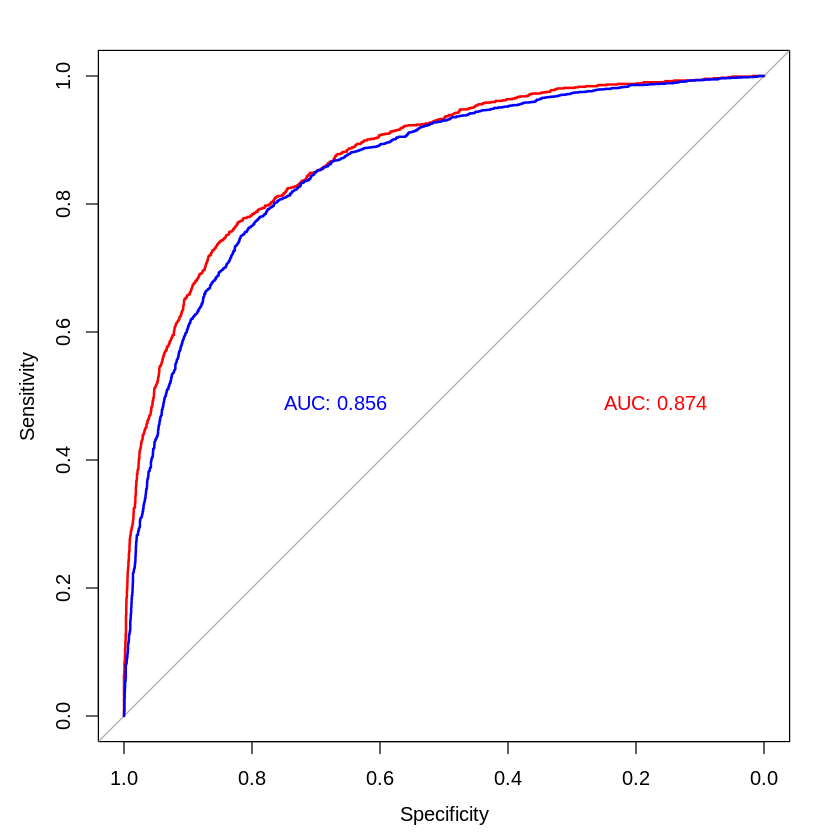

In [152]:
#feature ordering
features_h1n1 <- MRMR("h1n1_vaccine")
features_seasonal <- MRMR("seasonal_vaccine")
#Preprocessed data from mrMR pipeline
training_set <- read.csv("normalized_data.csv")
training_matrix <- data.matrix(training_set)
pred_set <- read.csv("normalized_test.csv")
#Formatting data for xgboost package
training_set$seasonal_vaccine <- as.factor(training_set$seasonal_vaccine)
training_set$h1n1_vaccine <- as.factor(training_set$h1n1_vaccine)

label_h1n1 <- data.matrix(training_set$h1n1_vaccine)
label_seasonal <- data.matrix(training_set$seasonal_vaccine)

best_mean=0
for (nbr_features in (c(10,20,25,30,35))){
    for (depth in c(1,2,3,4)){
        for (eta_value in c(0.01,0.1,0.3,0.5,0.9)){
            for(nrounds_val in c(1,2,5,10)){
                #Define train and test sample from training sample.
                training_label.samples <- training_label$respondent_id%>%createDataPartition(p = 0.8, list = FALSE)
                train_h1n1.data = training_matrix[training_label.samples,features_h1n1[1:nbr_features]]
                train_seasonal.data = training_matrix[training_label.samples,features_seasonal[1:nbr_features]]
                test_label_h1n1=label_h1n1[-training_label.samples,]
                test_label_seasonal=label_seasonal[-training_label.samples,]
                train_label_h1n1=label_h1n1[training_label.samples,]
                train_label_seasonal=label_seasonal[training_label.samples,]
                pred_mat_h1n1 <- training_matrix[-training_label.samples,features_h1n1[1:nbr_features]]
                pred_mat_seasonal <- training_matrix[-training_label.samples,features_seasonal[1:nbr_features]]
                # Build the model proba.
                print(dim(train_h1n1.data))
                print(dim(pred_mat_h1n1))
                bst_h1n1 <- xgboost(data = train_h1n1.data, label = train_label_h1n1, max_depth = depth,
                eta = eta_value,nrounds = nrounds_val, objective = "binary:logistic")
                bst_seasonal <- xgboost(data = train_seasonal.data, label = train_label_seasonal,
                max_depth = depth, eta = eta_value,nrounds = nrounds_val, objective = "binary:logistic")
                pred_h1n1 <- predict(bst_h1n1, pred_mat_h1n1, type="prob")
                pred_seasonal <- predict(bst_seasonal, pred_mat_seasonal, type="prob")
                #Compute the AUC-ROC curve.
                roc_h1n1=roc(test_label_h1n1, pred_h1n1,auc=TRUE)
                roc_seasonal=roc(test_label_seasonal, pred_seasonal,auc=TRUE)
                actual_mean=mean(mean(c(auc(roc_h1n1),auc(roc_seasonal))))
                print(unlist(list('AUC-ROC curves for' , nbr_features,'features, depth of',depth,'eta_value of',eta_value,'and nrounds,',nrounds_val,'with mean AUC of',actual_mean)))
                if (actual_mean>best_mean)
                    {
                    best_mean=actual_mean
                    best_roc_h1n1=roc_h1n1
                    best_roc_seasonal=roc_seasonal
                    f_best=nbr_features
                    best_depth=depth
                    best_eta=eta_value
                    best_rounds=nrounds_val
                    }
                }
            }
        }
    }
#Plot best ROC curve with AUC
print(unlist(list('our best hyperparameter are for' , f_best,'features, depth of',best_depth,'eta_value of',best_eta,'and nrounds,',best_rounds,'with mean AUC of',best_mean)))
print('The corresponding ROC curves are :')
plot.roc(best_roc_h1n1,print.auc=TRUE,print.auc.x=0.25, print.auc.y=0.5,col='red')
plot.roc(best_roc_seasonal,add=TRUE,print.auc=TRUE,print.auc.x=0.75, print.auc.y=0.5,col = 'blue')

In [178]:
training_matrix=as.matrix(training_set)
test_matrix=as.matrix(test_set_norm[,2:36])

bst_h1n1 <- xgboost(data = training_matrix, label = label_h1n1, max_depth = 4,
                eta = 0.9,nrounds = 10, objective = "binary:logistic")
bst_seasonal <- xgboost(data = training_matrix, label = label_seasonal,
                max_depth = 4, eta =0.9,nrounds = 10, objective = "binary:logistic")
xg_pred_h1n1 <- predict(bst_h1n1, test_matrix, type="prob")
xg_pred_seasonal <- predict(bst_seasonal, test_matrix, type="prob")

xg_full_matrix=do.call("cbind", list(test_set$respondent_id, xg_pred_h1n1,xg_pred_seasonal))
xg_return_frame=tibble('respondent_id'=xg_full_matrix[,1],'h1n1_vaccine'=xg_full_matrix[,2],'seasonal_vaccine'=xg_full_matrix[,3])
write.csv(xg_return_frame,'xg_best.csv', row.names = FALSE)

[1] 26707    35

[1] 26708    35

[1]	train-logloss:0.410838 
[2]	train-logloss:0.373897 
[3]	train-logloss:0.360112 
[4]	train-logloss:0.352337 
[5]	train-logloss:0.347469 
[6]	train-logloss:0.344404 
[7]	train-logloss:0.341362 
[8]	train-logloss:0.339187 
[9]	train-logloss:0.337315 
[10]	train-logloss:0.334949 
[1]	train-logloss:0.529393 
[2]	train-logloss:0.495429 
[3]	train-logloss:0.479255 
[4]	train-logloss:0.471143 
[5]	train-logloss:0.466360 
[6]	train-logloss:0.462440 
[7]	train-logloss:0.459206 
[8]	train-logloss:0.457184 
[9]	train-logloss:0.454477 
[10]	train-logloss:0.452956 


# Conclusions

In conclusion, the project is divided into four main tasks:

- Pre-processing of data consisting of:
    - Data loading - installing the relevant library and uploading the datasets (training set, training labels, test set), checking the relative shares of vaccinated respondents (20-80% for h1n1 and 45- 55% for seasonal flu)
    - Feature engineering and imputation of missing values - Creating a list of features, cleaning datasets (replacing empty string with most common values and normalizing training and testing sets), identifying the correlation matrix between characteristics
- Selection of features consisting of:
     - MRMR filter – Sorting features in order from the one capturing the most information (highest correlation, highest mrmr score) to the least. This mrmr filter is defined for both h1n1 and seasonal labels. This mrmr filter is then used for random forest, neural network and xgboost
     - LDA – Features are transformed into booleans and data is cleaned. Correlation is calculated between features. When two features are strongly correlated, one is removed. LDA is applied on the dataset for the KNN.
- Model selection consisting of:
     - Pre-selection of the model to implement – 8 packages can be used and the possible machine learnings are reviewed according to relevant criteria (objective, interpretability, set size, data format, etc.). Three models are selected: Random Forest, KNN and Neural network
     - Random forest - Multiple random forests are calculated by varying the number of features selected from the mrmr and the number of trees. A heat map is used to identify the best random forest.
     - KNN – KNN were calculated by varying the number of neighbors for Manhattan and Euclid distances (p Minkoswki equal to 1 and 2 respectively). Auroc are calculated for each scenario.
     - Neural Network - Neural networks are calculated using a single intermediate line of neurons. The neural networks are tested with a variable number of features (of the mrmr filter), a variable size on the intermediate neurons and a different decay rate. Auroc are calculated for each scenario
- Alternative model - the alternative model is the xgboost. It was chosen because no gradient algorithms are used so far and they are known to be efficient for binary classification. The xgboost are tested by varying the nulber of features, the number of branching level, the shrinkage parameter (eta) and the number of rounds. 

## Results

- The optimal random forest is calculated for 300 trees with 34 features for h1n1 and 35 features for seasonal. For these parameters, the AUROC is 0.8542

- The optimal KNN is given for 100 neighbours and for a Euclid distance. With these parameters, the AUROC reaches 0.8367. The submitted KNN prediction is for 25 neighbors and for a Euclidean distance. For these parameters, the AUROC is 0.8255

- The optimal neural network is given for 35 features with 30 intermediate neurons. The AUROC is 0.8586. This neural network has been submitted on the Drivendata platform and the calculated AUROC reaches 0.5761. This indicates that this neural network model should heavily overfit the dataset. Another neural network prediction is submitted for 36 features and 14 intermediate neurons and the AUROC is 0.8308.

- The optimal xgboost is given for a branching level of 4, eta of 0.9, a round number of 10 and a feature count of 35. The AUROC reaches 0.8471 given by the DrivenData platform.

By comparing the AUROC of the four models implemented with optimal parameters, it follows that the random forest achieves the highest score for this problem.
